# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [38]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


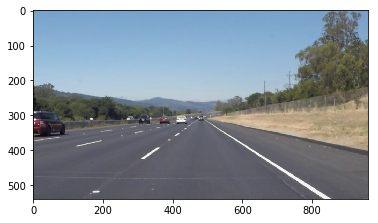

In [39]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [40]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    left_avg = 0
    right_avg = 0
    infinity = math.inf
    x = 0
    two_line = 0
    for lin_num in range(0,len(lines)):
        print ("[%s] is the line now!" % lin_num)
        line = lines[lin_num]
        if two_line == 2:
            x = x + 1
            two_line = 0
        for x1,y1,x2,y2 in line:
            print ( line)
            slope = (y2 - y1)/(x2 - x1)
            if slope > 0:
                left_avg = ((x) * left_avg + slope)/(x + 1)
                print ("[%d] We have +ve slope here is %s (left line) avg: %s" % (x, slope, left_avg))
                two_line = two_line + 1
            elif slope < 0:
                right_avg = -((-x) * right_avg + (-slope))/(x + 1)
                print ("[%d] We have -ve slope here is %s (right line) avg: %s" % (x, slope, right_avg))
                two_line = two_line + 1
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

Processing test_images/whiteCarLaneSwitch.jpg
[0] is the line now!
[[194 538 473 320]]
[0] We have -ve slope here is -0.781362007168 (right line) avg: -0.781362007168
[1] is the line now!
[[497 319 863 539]]
[0] We have +ve slope here is 0.601092896175 (left line) avg: 0.601092896175
[2] is the line now!
[[277 462 473 319]]
[1] We have -ve slope here is -0.729591836735 (right line) avg: -0.755476921952
[3] is the line now!
[[505 322 793 488]]
[1] We have +ve slope here is 0.576388888889 (left line) avg: 0.588740892532
[4] is the line now!
[[175 538 468 325]]
[2] We have -ve slope here is -0.726962457338 (right line) avg: -0.745972100414
[5] is the line now!
[[581 371 884 538]]
[2] We have +ve slope here is 0.551155115512 (left line) avg: 0.576212300192
[6] is the line now!
[[363 355 459 320]]
[3] We have -ve slope here is -0.364583333333 (right line) avg: -0.650624908644
[7] is the line now!
[[253 480 443 346]]
[3] We have -ve slope here is -0.705263157895 (right line) avg: -0.66428447

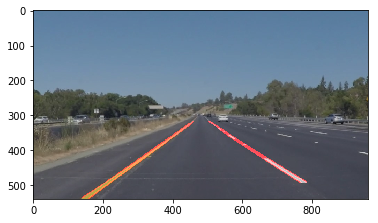

In [41]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.
# This pipeline is highly based on snippet code shared in lectures

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2

    
def process_individual_frame(image):
    each_gray = grayscale(image)
    plt.imshow(each_gray)
    
    # Define a kernel size and apply Gaussian smoothing
    kernel_size = 5
    each_blur_gray = gaussian_blur(each_gray,kernel_size)

    # Define our parameters for Canny and apply
    low_threshold = 50
    high_threshold = 150
    edges = canny(each_blur_gray, low_threshold, high_threshold)

    # creating here a image mask
    a = (0, image.shape[0])
    b = (image.shape[1]/2 - (image.shape[0] * 0.08), image.shape[0]/2 + (image.shape[1] * 0.05))
    c = (image.shape[1]/2 + (image.shape[0] * 0.08), image.shape[0]/2 + (image.shape[1] * 0.05))
    d = (image.shape[1], image.shape[0])
    vertices = np.array([[a, b, c, d]], dtype=np.int32)
    
    masked_edges = region_of_interest(edges, vertices)
    
    rho = 2 # distance resolution in pixels of the Hough grid
    theta = np.pi/180 # angular resolution in radians of the Hough grid
    threshold = 65 # minimum number of votes (intersections in Hough grid cell)
    min_line_len = 4 #minimum number of pixels making up a line
    max_line_gap = 240  # maximum gap in pixels between connectable line segments
    
    lines = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)
    
    lines_edges = weighted_img(lines, image)
    plt.imshow(lines_edges)
    return lines_edges

import os
os.listdir("test_images/")
test_images = os.listdir("test_images/")

for each_inp in test_images:
    each_inp = "test_images/" + each_inp
    print ("Processing " + each_inp)
    image = mpimg.imread(each_inp)
    process_individual_frame(image)
    
    
    

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [42]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [43]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    return process_individual_frame(image)

Let's try the one with the solid white lane on the right first ...

[0] is the line now!
[[513 324 869 538]]
[0] We have +ve slope here is 0.601123595506 (left line) avg: 0.601123595506
[1] is the line now!
[[498 318 742 471]]
[0] We have +ve slope here is 0.627049180328 (left line) avg: 0.627049180328
[2] is the line now!
[[200 515 462 318]]
[1] We have -ve slope here is -0.751908396947 (right line) avg: -0.375954198473
[3] is the line now!
[[504 318 870 538]]
[1] We have +ve slope here is 0.601092896175 (left line) avg: 0.614071038251
[4] is the line now!
[[187 512 464 318]]
[2] We have -ve slope here is -0.70036101083 (right line) avg: -0.484089802592
[5] is the line now!
[[724 461 847 538]]
[2] We have +ve slope here is 0.626016260163 (left line) avg: 0.618052778888
[6] is the line now!
[[500 318 685 434]]
[3] We have +ve slope here is 0.627027027027 (left line) avg: 0.620296340923
[7] is the line now!
[[187 513 427 339]]
[3] We have -ve slope here is -0.725 (right line) avg: -0.544317351944
[8] is the line now!
[[278 458 458 318]]
[4] We have -ve 

  1%|▏         | 3/222 [00:00<00:07, 28.55it/s]

[0] is the line now!
[[513 324 869 538]]
[0] We have +ve slope here is 0.601123595506 (left line) avg: 0.601123595506
[1] is the line now!
[[498 318 742 471]]
[0] We have +ve slope here is 0.627049180328 (left line) avg: 0.627049180328
[2] is the line now!
[[200 515 462 318]]
[1] We have -ve slope here is -0.751908396947 (right line) avg: -0.375954198473
[3] is the line now!
[[504 318 870 538]]
[1] We have +ve slope here is 0.601092896175 (left line) avg: 0.614071038251
[4] is the line now!
[[187 512 464 318]]
[2] We have -ve slope here is -0.70036101083 (right line) avg: -0.484089802592
[5] is the line now!
[[724 461 847 538]]
[2] We have +ve slope here is 0.626016260163 (left line) avg: 0.618052778888
[6] is the line now!
[[500 318 685 434]]
[3] We have +ve slope here is 0.627027027027 (left line) avg: 0.620296340923
[7] is the line now!
[[187 513 427 339]]
[3] We have -ve slope here is -0.725 (right line) avg: -0.544317351944
[8] is the line now!
[[278 458 458 318]]
[4] We have -ve 

  3%|▎         | 6/222 [00:00<00:07, 28.67it/s]

[0] is the line now!
[[499 318 721 457]]
[0] We have +ve slope here is 0.626126126126 (left line) avg: 0.626126126126
[1] is the line now!
[[507 320 870 538]]
[0] We have +ve slope here is 0.600550964187 (left line) avg: 0.600550964187
[2] is the line now!
[[504 318 869 537]]
[1] We have +ve slope here is 0.6 (left line) avg: 0.600275482094
[3] is the line now!
[[498 318 808 512]]
[1] We have +ve slope here is 0.625806451613 (left line) avg: 0.613040966853
[4] is the line now!
[[778 495 849 538]]
[2] We have +ve slope here is 0.605633802817 (left line) avg: 0.610571912174
[5] is the line now!
[[169 532 464 318]]
[2] We have -ve slope here is -0.725423728814 (right line) avg: -0.241807909605
[6] is the line now!
[[301 428 459 318]]
[3] We have -ve slope here is -0.696202531646 (right line) avg: -0.355406565115
[7] is the line now!
[[739 470 811 514]]
[3] We have +ve slope here is 0.611111111111 (left line) avg: 0.610706711909
[0] is the line now!
[[505 322 779 494]]
[0] We have +ve slop

  4%|▍         | 9/222 [00:00<00:07, 28.72it/s]

[0] is the line now!
[[499 318 790 500]]
[0] We have +ve slope here is 0.625429553265 (left line) avg: 0.625429553265
[1] is the line now!
[[505 318 871 538]]
[0] We have +ve slope here is 0.601092896175 (left line) avg: 0.601092896175
[2] is the line now!
[[514 324 870 538]]
[1] We have +ve slope here is 0.601123595506 (left line) avg: 0.60110824584
[3] is the line now!
[[256 462 456 321]]
[1] We have -ve slope here is -0.705 (right line) avg: -0.3525
[4] is the line now!
[[511 326 810 513]]
[2] We have +ve slope here is 0.625418060201 (left line) avg: 0.609211517294
[5] is the line now!
[[263 463 463 318]]
[2] We have -ve slope here is -0.725 (right line) avg: -0.476666666667
[6] is the line now!
[[254 461 457 319]]
[3] We have -ve slope here is -0.699507389163 (right line) avg: -0.532376847291
[7] is the line now!
[[788 500 830 526]]
[3] We have +ve slope here is 0.619047619048 (left line) avg: 0.611670542732
[0] is the line now!
[[499 318 851 538]]
[0] We have +ve slope here is 0.6

  5%|▌         | 12/222 [00:00<00:07, 28.51it/s]

[0] is the line now!
[[493 318 859 538]]
[0] We have +ve slope here is 0.601092896175 (left line) avg: 0.601092896175
[1] is the line now!
[[672 434 838 538]]
[0] We have +ve slope here is 0.626506024096 (left line) avg: 0.626506024096
[2] is the line now!
[[604 390 798 512]]
[1] We have +ve slope here is 0.628865979381 (left line) avg: 0.627686001739
[3] is the line now!
[[263 458 463 318]]
[1] We have -ve slope here is -0.7 (right line) avg: -0.35
[4] is the line now!
[[500 318 595 384]]
[2] We have +ve slope here is 0.694736842105 (left line) avg: 0.650036281861
[5] is the line now!
[[277 459 408 357]]
[2] We have -ve slope here is -0.778625954198 (right line) avg: -0.492875318066
[6] is the line now!
[[515 333 604 383]]
[3] We have +ve slope here is 0.561797752809 (left line) avg: 0.627976649598
[7] is the line now!
[[508 323 609 393]]
[3] We have +ve slope here is 0.693069306931 (left line) avg: 0.644249813931
[8] is the line now!
[[272 461 469 318]]
[4] We have -ve slope here is 

  7%|▋         | 15/222 [00:00<00:07, 25.97it/s]

[0] is the line now!
[[494 318 833 538]]
[0] We have +ve slope here is 0.648967551622 (left line) avg: 0.648967551622
[1] is the line now!
[[532 340 721 458]]
[0] We have +ve slope here is 0.624338624339 (left line) avg: 0.624338624339
[2] is the line now!
[[195 516 468 318]]
[1] We have -ve slope here is -0.725274725275 (right line) avg: -0.362637362637
[3] is the line now!
[[183 513 462 318]]
[1] We have -ve slope here is -0.698924731183 (right line) avg: -0.53078104691
[4] is the line now!
[[498 318 767 486]]
[2] We have +ve slope here is 0.624535315985 (left line) avg: 0.624404188221
[5] is the line now!
[[495 319 833 539]]
[2] We have +ve slope here is 0.650887573964 (left line) avg: 0.633231983469
[6] is the line now!
[[500 318 845 533]]
[3] We have +ve slope here is 0.623188405797 (left line) avg: 0.630721089051
[7] is the line now!
[[199 515 455 322]]
[3] We have -ve slope here is -0.75390625 (right line) avg: -0.586562347683
[8] is the line now!
[[521 337 817 529]]
[4] We have

  9%|▉         | 21/222 [00:00<00:07, 27.22it/s]

[0] We have +ve slope here is 0.626112759644 (left line) avg: 0.626112759644
[1] is the line now!
[[502 318 666 425]]
[0] We have +ve slope here is 0.65243902439 (left line) avg: 0.65243902439
[2] is the line now!
[[721 463 836 538]]
[1] We have +ve slope here is 0.652173913043 (left line) avg: 0.652306468717
[3] is the line now!
[[565 354 729 468]]
[1] We have +ve slope here is 0.69512195122 (left line) avg: 0.673714209968
[4] is the line now!
[[353 388 460 318]]
[2] We have -ve slope here is -0.654205607477 (right line) avg: -0.218068535826
[5] is the line now!
[[290 439 442 332]]
[2] We have -ve slope here is -0.703947368421 (right line) avg: -0.380028146691
[6] is the line now!
[[283 439 455 318]]
[3] We have -ve slope here is -0.703488372093 (right line) avg: -0.460893203041
[7] is the line now!
[[508 319 709 455]]
[3] We have +ve slope here is 0.676616915423 (left line) avg: 0.674439886332
[0] is the line now!
[[504 318 856 538]]
[0] We have +ve slope here is 0.625 (left line) av

 11%|█         | 24/222 [00:00<00:07, 27.66it/s]

[0] is the line now!
[[502 318 853 537]]
[0] We have +ve slope here is 0.623931623932 (left line) avg: 0.623931623932
[1] is the line now!
[[497 318 785 506]]
[0] We have +ve slope here is 0.652777777778 (left line) avg: 0.652777777778
[2] is the line now!
[[231 476 466 318]]
[1] We have -ve slope here is -0.672340425532 (right line) avg: -0.336170212766
[3] is the line now!
[[697 450 833 539]]
[1] We have +ve slope here is 0.654411764706 (left line) avg: 0.653594771242
[4] is the line now!
[[244 479 450 324]]
[2] We have -ve slope here is -0.752427184466 (right line) avg: -0.474922536666
[5] is the line now!
[[548 351 758 478]]
[2] We have +ve slope here is 0.604761904762 (left line) avg: 0.637317149082
[6] is the line now!
[[248 477 465 319]]
[3] We have -ve slope here is -0.728110599078 (right line) avg: -0.538219552269
[7] is the line now!
[[521 330 854 538]]
[3] We have +ve slope here is 0.624624624625 (left line) avg: 0.634144017968
[0] is the line now!
[[523 331 855 539]]
[0] We

 12%|█▏        | 27/222 [00:00<00:07, 26.78it/s]

[0] is the line now!
[[506 320 855 538]]
[0] We have +ve slope here is 0.624641833811 (left line) avg: 0.624641833811
[1] is the line now!
[[499 319 795 512]]
[0] We have +ve slope here is 0.652027027027 (left line) avg: 0.652027027027
[2] is the line now!
[[147 536 459 318]]
[1] We have -ve slope here is -0.698717948718 (right line) avg: -0.349358974359
[3] is the line now!
[[503 318 856 538]]
[1] We have +ve slope here is 0.623229461756 (left line) avg: 0.637628244392
[4] is the line now!
[[165 539 226 494]]
[2] We have -ve slope here is -0.737704918033 (right line) avg: -0.47880762225
[5] is the line now!
[[741 478 807 520]]
[2] We have +ve slope here is 0.636363636364 (left line) avg: 0.637206708382
[6] is the line now!
[[199 498 466 318]]
[3] We have -ve slope here is -0.674157303371 (right line) avg: -0.52764504253
[7] is the line now!
[[164 538 465 319]]
[3] We have -ve slope here is -0.727574750831 (right line) avg: -0.577627469605


 14%|█▎        | 30/222 [00:01<00:07, 26.40it/s]

[0] is the line now!
[[498 318 743 478]]
[0] We have +ve slope here is 0.65306122449 (left line) avg: 0.65306122449
[1] is the line now!
[[535 339 855 539]]
[0] We have +ve slope here is 0.625 (left line) avg: 0.625
[2] is the line now!
[[677 436 834 538]]
[1] We have +ve slope here is 0.649681528662 (left line) avg: 0.637340764331
[3] is the line now!
[[149 535 459 318]]
[1] We have -ve slope here is -0.7 (right line) avg: -0.35
[4] is the line now!
[[308 425 466 318]]
[2] We have -ve slope here is -0.677215189873 (right line) avg: -0.459071729958
[5] is the line now!
[[503 318 856 538]]
[2] We have +ve slope here is 0.623229461756 (left line) avg: 0.632636996806
[6] is the line now!
[[371 388 458 320]]
[3] We have -ve slope here is -0.781609195402 (right line) avg: -0.539706096319
[0] is the line now!
[[501 320 834 537]]
[0] We have +ve slope here is 0.651651651652 (left line) avg: 0.651651651652
[1] is the line now!
[[505 319 856 539]]
[0] We have +ve slope here is 0.626780626781 (l

 16%|█▌        | 36/222 [00:01<00:08, 22.12it/s]

[0] is the line now!
[[556 356 836 538]]
[0] We have +ve slope here is 0.65 (left line) avg: 0.65
[1] is the line now!
[[528 333 845 531]]
[0] We have +ve slope here is 0.624605678233 (left line) avg: 0.624605678233
[2] is the line now!
[[292 436 452 324]]
[1] We have -ve slope here is -0.7 (right line) avg: -0.35
[3] is the line now!
[[292 435 457 319]]
[1] We have -ve slope here is -0.70303030303 (right line) avg: -0.526515151515
[4] is the line now!
[[300 437 464 318]]
[2] We have -ve slope here is -0.725609756098 (right line) avg: -0.592880019709
[5] is the line now!
[[505 322 690 434]]
[2] We have +ve slope here is 0.605405405405 (left line) avg: 0.618205587291
[6] is the line now!
[[550 352 857 537]]
[3] We have +ve slope here is 0.602605863192 (left line) avg: 0.614305656266
[0] is the line now!
[[540 342 855 539]]
[0] We have +ve slope here is 0.625396825397 (left line) avg: 0.625396825397
[1] is the line now!
[[508 325 833 537]]
[0] We have +ve slope here is 0.652307692308 (le

 18%|█▊        | 39/222 [00:01<00:08, 22.84it/s]

[0] is the line now!
[[500 318 854 539]]
[0] We have +ve slope here is 0.624293785311 (left line) avg: 0.624293785311
[1] is the line now!
[[501 319 683 441]]
[0] We have +ve slope here is 0.67032967033 (left line) avg: 0.67032967033
[2] is the line now!
[[504 318 802 519]]
[1] We have +ve slope here is 0.674496644295 (left line) avg: 0.672413157312
[3] is the line now!
[[166 539 460 318]]
[1] We have -ve slope here is -0.751700680272 (right line) avg: -0.375850340136
[4] is the line now!
[[145 538 456 320]]
[2] We have -ve slope here is -0.700964630225 (right line) avg: -0.484221770166
[5] is the line now!
[[512 322 833 538]]
[2] We have +ve slope here is 0.672897196262 (left line) avg: 0.672574503629
[6] is the line now!
[[150 536 455 323]]
[3] We have -ve slope here is -0.698360655738 (right line) avg: -0.537756491559
[7] is the line now!
[[686 443 833 539]]
[3] We have +ve slope here is 0.65306122449 (left line) avg: 0.667696183844
[8] is the line now!
[[346 406 458 322]]
[4] We ha

 19%|█▉        | 42/222 [00:01<00:07, 24.36it/s]

[0] is the line now!
[[501 318 854 538]]
[0] We have +ve slope here is 0.623229461756 (left line) avg: 0.623229461756
[1] is the line now!
[[534 339 826 535]]
[0] We have +ve slope here is 0.671232876712 (left line) avg: 0.671232876712
[2] is the line now!
[[506 318 570 358]]
[1] We have +ve slope here is 0.625 (left line) avg: 0.648116438356
[3] is the line now!
[[273 458 456 320]]
[1] We have -ve slope here is -0.754098360656 (right line) avg: -0.377049180328
[4] is the line now!
[[257 457 463 318]]
[2] We have -ve slope here is -0.674757281553 (right line) avg: -0.47628521407
[5] is the line now!
[[635 400 832 538]]
[2] We have +ve slope here is 0.700507614213 (left line) avg: 0.665580163642
[6] is the line now!
[[510 324 720 465]]
[3] We have +ve slope here is 0.671428571429 (left line) avg: 0.667042265589
[7] is the line now!
[[259 456 456 318]]
[3] We have -ve slope here is -0.700507614213 (right line) avg: -0.532340814106
[8] is the line now!
[[535 335 619 391]]
[4] We have +ve 

 20%|██        | 45/222 [00:01<00:06, 25.46it/s]

[0] is the line now!
[[501 318 854 538]]
[0] We have +ve slope here is 0.623229461756 (left line) avg: 0.623229461756
[1] is the line now!
[[502 318 792 513]]
[0] We have +ve slope here is 0.672413793103 (left line) avg: 0.672413793103
[2] is the line now!
[[513 323 619 390]]
[1] We have +ve slope here is 0.632075471698 (left line) avg: 0.652244632401
[3] is the line now!
[[173 517 455 320]]
[1] We have -ve slope here is -0.698581560284 (right line) avg: -0.349290780142
[4] is the line now!
[[198 514 452 323]]
[2] We have -ve slope here is -0.751968503937 (right line) avg: -0.483516688074
[5] is the line now!
[[606 382 831 539]]
[2] We have +ve slope here is 0.697777777778 (left line) avg: 0.667422347526
[6] is the line now!
[[517 324 740 468]]
[3] We have +ve slope here is 0.645739910314 (left line) avg: 0.662001738223
[0] is the line now!
[[502 318 749 484]]
[0] We have +ve slope here is 0.672064777328 (left line) avg: 0.672064777328
[1] is the line now!
[[506 318 655 414]]
[0] We ha

 22%|██▏       | 48/222 [00:01<00:06, 25.02it/s]

[0] is the line now!
[[524 333 792 513]]
[0] We have +ve slope here is 0.671641791045 (left line) avg: 0.671641791045
[1] is the line now!
[[501 318 854 538]]
[0] We have +ve slope here is 0.623229461756 (left line) avg: 0.623229461756
[2] is the line now!
[[209 502 442 327]]
[1] We have -ve slope here is -0.751072961373 (right line) avg: -0.375536480687
[3] is the line now!
[[197 499 456 318]]
[1] We have -ve slope here is -0.698841698842 (right line) avg: -0.537189089764
[4] is the line now!
[[215 500 457 318]]
[2] We have -ve slope here is -0.752066115702 (right line) avg: -0.608814765077
[5] is the line now!
[[505 318 618 389]]
[2] We have +ve slope here is 0.628318584071 (left line) avg: 0.624925835861
[6] is the line now!
[[505 322 660 416]]
[3] We have +ve slope here is 0.606451612903 (left line) avg: 0.620307280122
[7] is the line now!
[[213 501 398 357]]
[3] We have -ve slope here is -0.778378378378 (right line) avg: -0.651205668402
[8] is the line now!
[[587 370 801 519]]
[4]

 23%|██▎       | 51/222 [00:02<00:06, 24.49it/s]

[0] is the line now!
[[501 318 853 538]]
[0] We have +ve slope here is 0.625 (left line) avg: 0.625
[1] is the line now!
[[506 319 831 538]]
[0] We have +ve slope here is 0.673846153846 (left line) avg: 0.673846153846
[2] is the line now!
[[140 538 448 323]]
[1] We have -ve slope here is -0.698051948052 (right line) avg: -0.349025974026
[3] is the line now!
[[161 539 440 329]]
[1] We have -ve slope here is -0.752688172043 (right line) avg: -0.550857073034
[4] is the line now!
[[509 325 679 428]]
[2] We have +ve slope here is 0.605882352941 (left line) avg: 0.651191553544
[5] is the line now!
[[549 345 767 497]]
[2] We have +ve slope here is 0.697247706422 (left line) avg: 0.666543604504
[6] is the line now!
[[506 318 642 413]]
[3] We have +ve slope here is 0.698529411765 (left line) avg: 0.674540056319
[7] is the line now!
[[580 365 713 461]]
[3] We have +ve slope here is 0.721804511278 (left line) avg: 0.686356170059
[8] is the line now!
[[614 393 824 520]]
[4] We have +ve slope here 

 24%|██▍       | 54/222 [00:02<00:06, 25.11it/s]

[[504 318 697 439]]
[1] We have +ve slope here is 0.626943005181 (left line) avg: 0.649135838255
[3] is the line now!
[[772 487 852 539]]
[1] We have +ve slope here is 0.65 (left line) avg: 0.649567919128
[4] is the line now!
[[293 437 457 318]]
[2] We have -ve slope here is -0.725609756098 (right line) avg: -0.241869918699
[5] is the line now!
[[281 436 462 318]]
[2] We have -ve slope here is -0.651933701657 (right line) avg: -0.378557846352
[6] is the line now!
[[283 435 456 318]]
[3] We have -ve slope here is -0.676300578035 (right line) avg: -0.452993529273
[7] is the line now!
[[504 322 697 448]]
[3] We have +ve slope here is 0.652849740933 (left line) avg: 0.650388374579
[8] is the line now!
[[764 494 831 538]]
[4] We have +ve slope here is 0.65671641791 (left line) avg: 0.651653983245
[0] is the line now!
[[508 321 766 483]]
[0] We have +ve slope here is 0.627906976744 (left line) avg: 0.627906976744
[1] is the line now!
[[540 344 808 524]]
[0] We have +ve slope here is 0.671641

 26%|██▌       | 57/222 [00:02<00:06, 25.58it/s]

[0] is the line now!
[[505 320 813 513]]
[0] We have +ve slope here is 0.626623376623 (left line) avg: 0.626623376623
[1] is the line now!
[[497 318 620 398]]
[0] We have +ve slope here is 0.650406504065 (left line) avg: 0.650406504065
[2] is the line now!
[[512 329 768 496]]
[1] We have +ve slope here is 0.65234375 (left line) avg: 0.651375127033
[3] is the line now!
[[218 479 457 318]]
[1] We have -ve slope here is -0.673640167364 (right line) avg: -0.336820083682
[4] is the line now!
[[231 480 461 319]]
[2] We have -ve slope here is -0.7 (right line) avg: -0.457880055788
[5] is the line now!
[[593 381 848 535]]
[2] We have +ve slope here is 0.603921568627 (left line) avg: 0.635557274231
[6] is the line now!
[[503 318 830 539]]
[3] We have +ve slope here is 0.675840978593 (left line) avg: 0.645628200321
[0] is the line now!
[[495 318 705 455]]
[0] We have +ve slope here is 0.652380952381 (left line) avg: 0.652380952381
[1] is the line now!
[[501 318 814 514]]
[0] We have +ve slope he

 27%|██▋       | 60/222 [00:02<00:06, 26.06it/s]

[0] is the line now!
[[496 318 848 538]]
[0] We have +ve slope here is 0.625 (left line) avg: 0.625
[1] is the line now!
[[553 355 826 539]]
[0] We have +ve slope here is 0.673992673993 (left line) avg: 0.673992673993
[2] is the line now!
[[240 476 457 319]]
[1] We have -ve slope here is -0.723502304147 (right line) avg: -0.361751152074
[3] is the line now!
[[542 348 802 523]]
[1] We have +ve slope here is 0.673076923077 (left line) avg: 0.673534798535
[4] is the line now!
[[226 474 441 329]]
[2] We have -ve slope here is -0.674418604651 (right line) avg: -0.465973636266
[5] is the line now!
[[501 318 597 380]]
[2] We have +ve slope here is 0.645833333333 (left line) avg: 0.664300976801
[6] is the line now!
[[596 378 785 500]]
[3] We have +ve slope here is 0.645502645503 (left line) avg: 0.659601393976
[7] is the line now!
[[239 466 466 318]]
[3] We have -ve slope here is -0.651982378855 (right line) avg: -0.512475821913
[8] is the line now!
[[498 320 848 539]]
[4] We have +ve slope he

 28%|██▊       | 63/222 [00:02<00:05, 26.85it/s]

[0] is the line now!
[[496 318 823 538]]
[0] We have +ve slope here is 0.672782874618 (left line) avg: 0.672782874618
[1] is the line now!
[[765 487 844 538]]
[0] We have +ve slope here is 0.645569620253 (left line) avg: 0.645569620253
[2] is the line now!
[[545 348 723 460]]
[1] We have +ve slope here is 0.629213483146 (left line) avg: 0.6373915517
[3] is the line now!
[[131 538 457 319]]
[1] We have -ve slope here is -0.671779141104 (right line) avg: -0.335889570552
[4] is the line now!
[[152 537 465 318]]
[2] We have -ve slope here is -0.699680511182 (right line) avg: -0.457153217429
[5] is the line now!
[[506 326 814 519]]
[2] We have +ve slope here is 0.626623376623 (left line) avg: 0.633802160008
[6] is the line now!
[[500 318 595 379]]
[3] We have +ve slope here is 0.642105263158 (left line) avg: 0.635877935795
[7] is the line now!
[[623 403 748 476]]
[3] We have +ve slope here is 0.584 (left line) avg: 0.622908451846
[0] is the line now!
[[496 318 823 538]]
[0] We have +ve slop

 30%|██▉       | 66/222 [00:02<00:06, 23.49it/s]

[0] is the line now!
[[510 328 823 539]]
[0] We have +ve slope here is 0.674121405751 (left line) avg: 0.674121405751
[1] is the line now!
[[503 318 844 539]]
[0] We have +ve slope here is 0.648093841642 (left line) avg: 0.648093841642
[2] is the line now!
[[497 318 823 538]]
[1] We have +ve slope here is 0.674846625767 (left line) avg: 0.661470233705
[3] is the line now!
[[509 323 691 441]]
[1] We have +ve slope here is 0.648351648352 (left line) avg: 0.654910941028
[4] is the line now!
[[248 457 434 332]]
[2] We have -ve slope here is -0.672043010753 (right line) avg: -0.224014336918
[5] is the line now!
[[260 455 463 318]]
[2] We have -ve slope here is -0.674876847291 (right line) avg: -0.374301840375
[6] is the line now!
[[787 500 844 538]]
[3] We have +ve slope here is 0.666666666667 (left line) avg: 0.657849872438
[7] is the line now!
[[740 470 817 521]]
[3] We have +ve slope here is 0.662337662338 (left line) avg: 0.658971819913
[0] is the line now!
[[497 318 824 539]]
[0] We ha

 31%|███       | 69/222 [00:02<00:06, 22.06it/s]

[4] is the line now!
[[505 324 847 538]]
[2] We have +ve slope here is 0.625730994152 (left line) avg: 0.640615409986
[5] is the line now!
[[187 509 451 324]]
[2] We have -ve slope here is -0.700757575758 (right line) avg: -0.458099031553
[6] is the line now!
[[604 384 825 538]]
[3] We have +ve slope here is 0.696832579186 (left line) avg: 0.654669702286
[7] is the line now!
[[498 319 824 539]]
[3] We have +ve slope here is 0.674846625767 (left line) avg: 0.659713933156
[0] is the line now!
[[502 318 809 517]]
[0] We have +ve slope here is 0.648208469055 (left line) avg: 0.648208469055
[1] is the line now!
[[496 318 823 538]]
[0] We have +ve slope here is 0.672782874618 (left line) avg: 0.672782874618
[2] is the line now!
[[286 433 457 318]]
[1] We have -ve slope here is -0.672514619883 (right line) avg: -0.336257309942
[3] is the line now!
[[294 433 454 321]]
[1] We have -ve slope here is -0.7 (right line) avg: -0.518128654971
[4] is the line now!
[[511 329 822 539]]
[2] We have +ve s

 32%|███▏      | 72/222 [00:02<00:06, 23.29it/s]

[0] is the line now!
[[512 329 822 538]]
[0] We have +ve slope here is 0.674193548387 (left line) avg: 0.674193548387
[1] is the line now!
[[502 318 784 501]]
[0] We have +ve slope here is 0.648936170213 (left line) avg: 0.648936170213
[2] is the line now!
[[506 319 844 538]]
[1] We have +ve slope here is 0.647928994083 (left line) avg: 0.648432582148
[3] is the line now!
[[241 470 451 323]]
[1] We have -ve slope here is -0.7 (right line) avg: -0.35
[4] is the line now!
[[230 467 424 341]]
[2] We have -ve slope here is -0.649484536082 (right line) avg: -0.449828178694
[5] is the line now!
[[503 318 843 539]]
[2] We have +ve slope here is 0.65 (left line) avg: 0.648955054765
[6] is the line now!
[[231 466 443 328]]
[3] We have -ve slope here is -0.650943396226 (right line) avg: -0.500106983077
[7] is the line now!
[[497 318 712 463]]
[3] We have +ve slope here is 0.674418604651 (left line) avg: 0.655320942237
[8] is the line now!
[[240 470 457 318]]
[4] We have -ve slope here is -0.7004

 34%|███▍      | 75/222 [00:02<00:06, 24.31it/s]

[0] is the line now!
[[519 335 820 538]]
[0] We have +ve slope here is 0.674418604651 (left line) avg: 0.674418604651
[1] is the line now!
[[501 318 841 539]]
[0] We have +ve slope here is 0.65 (left line) avg: 0.65
[2] is the line now!
[[123 538 462 318]]
[1] We have -ve slope here is -0.648967551622 (right line) avg: -0.324483775811
[3] is the line now!
[[142 538 457 318]]
[1] We have -ve slope here is -0.698412698413 (right line) avg: -0.511448237112
[4] is the line now!
[[143 539 458 318]]
[2] We have -ve slope here is -0.701587301587 (right line) avg: -0.57482792527
[5] is the line now!
[[522 333 690 442]]
[2] We have +ve slope here is 0.64880952381 (left line) avg: 0.649603174603
[6] is the line now!
[[495 318 741 484]]
[3] We have +ve slope here is 0.674796747967 (left line) avg: 0.655901567944
[0] is the line now!
[[515 327 841 539]]
[0] We have +ve slope here is 0.650306748466 (left line) avg: 0.650306748466
[1] is the line now!
[[516 332 798 523]]
[0] We have +ve slope here i

 35%|███▌      | 78/222 [00:03<00:05, 25.14it/s]

[0] is the line now!
[[523 333 839 539]]
[0] We have +ve slope here is 0.651898734177 (left line) avg: 0.651898734177
[1] is the line now!
[[585 380 818 538]]
[0] We have +ve slope here is 0.678111587983 (left line) avg: 0.678111587983
[2] is the line now!
[[666 436 817 538]]
[1] We have +ve slope here is 0.675496688742 (left line) avg: 0.676804138362
[3] is the line now!
[[498 318 811 521]]
[1] We have +ve slope here is 0.648562300319 (left line) avg: 0.662683219341
[4] is the line now!
[[497 318 662 433]]
[2] We have +ve slope here is 0.69696969697 (left line) avg: 0.674112045217
[5] is the line now!
[[353 391 454 318]]
[2] We have -ve slope here is -0.722772277228 (right line) avg: -0.240924092409
[6] is the line now!
[[349 388 461 318]]
[3] We have -ve slope here is -0.625 (right line) avg: -0.336943069307
[0] is the line now!
[[498 318 837 538]]
[0] We have +ve slope here is 0.648967551622 (left line) avg: 0.648967551622
[1] is the line now!
[[496 318 734 484]]
[0] We have +ve slo

 36%|███▋      | 81/222 [00:03<00:06, 22.18it/s]

[0] is the line now!
[[496 318 835 538]]
[0] We have +ve slope here is 0.648967551622 (left line) avg: 0.648967551622
[1] is the line now!
[[502 322 787 521]]
[0] We have +ve slope here is 0.698245614035 (left line) avg: 0.698245614035
[2] is the line now!
[[499 319 813 539]]
[1] We have +ve slope here is 0.700636942675 (left line) avg: 0.699441278355
[3] is the line now!
[[319 407 461 318]]
[1] We have -ve slope here is -0.62676056338 (right line) avg: -0.31338028169
[4] is the line now!
[[229 477 456 318]]
[2] We have -ve slope here is -0.700440528634 (right line) avg: -0.442400364005
[5] is the line now!
[[503 318 576 369]]
[2] We have +ve slope here is 0.698630136986 (left line) avg: 0.699170897899
[0] is the line now!
[[499 320 834 538]]
[0] We have +ve slope here is 0.650746268657 (left line) avg: 0.650746268657
[1] is the line now!
[[496 318 745 492]]
[0] We have +ve slope here is 0.698795180723 (left line) avg: 0.698795180723
[2] is the line now!
[[602 385 813 538]]
[1] We have

 38%|███▊      | 84/222 [00:03<00:06, 20.10it/s]

[0] is the line now!
[[497 318 811 538]]
[0] We have +ve slope here is 0.700636942675 (left line) avg: 0.700636942675
[1] is the line now!
[[503 318 832 539]]
[0] We have +ve slope here is 0.671732522796 (left line) avg: 0.671732522796
[2] is the line now!
[[225 466 454 318]]
[1] We have -ve slope here is -0.646288209607 (right line) avg: -0.323144104803
[3] is the line now!
[[543 347 601 386]]
[1] We have +ve slope here is 0.672413793103 (left line) avg: 0.67207315795
[4] is the line now!
[[238 468 461 318]]
[2] We have -ve slope here is -0.67264573991 (right line) avg: -0.439644649839
[5] is the line now!
[[227 466 455 318]]
[2] We have -ve slope here is -0.649122807018 (right line) avg: -0.509470702232
[6] is the line now!
[[513 329 812 524]]
[3] We have +ve slope here is 0.652173913043 (left line) avg: 0.667098346723
[7] is the line now!
[[502 318 710 458]]
[3] We have +ve slope here is 0.673076923077 (left line) avg: 0.668592990812
[8] is the line now!
[[225 469 451 323]]
[4] We h

 39%|███▉      | 87/222 [00:03<00:06, 20.40it/s]

[0] is the line now!
[[497 318 811 538]]
[0] We have +ve slope here is 0.700636942675 (left line) avg: 0.700636942675
[1] is the line now!
[[137 537 462 318]]
[0] We have -ve slope here is -0.673846153846 (right line) avg: -0.673846153846
[2] is the line now!
[[503 318 803 520]]
[1] We have +ve slope here is 0.673333333333 (left line) avg: 0.686985138004
[3] is the line now!
[[521 331 705 455]]
[1] We have +ve slope here is 0.673913043478 (left line) avg: 0.680449090741
[4] is the line now!
[[122 536 457 318]]
[2] We have -ve slope here is -0.650746268657 (right line) avg: -0.666146192116
[5] is the line now!
[[122 534 456 318]]
[2] We have -ve slope here is -0.646706586826 (right line) avg: -0.659666323686
[6] is the line now!
[[498 318 634 407]]
[3] We have +ve slope here is 0.654411764706 (left line) avg: 0.673939759232
[0] is the line now!
[[497 318 809 537]]
[0] We have +ve slope here is 0.701923076923 (left line) avg: 0.701923076923
[1] is the line now!
[[504 318 831 538]]
[0] We

 41%|████      | 90/222 [00:03<00:05, 22.16it/s]

[0] is the line now!
[[537 347 809 538]]
[0] We have +ve slope here is 0.702205882353 (left line) avg: 0.702205882353
[1] is the line now!
[[528 336 768 498]]
[0] We have +ve slope here is 0.675 (left line) avg: 0.675
[2] is the line now!
[[503 318 830 538]]
[1] We have +ve slope here is 0.672782874618 (left line) avg: 0.673891437309
[3] is the line now!
[[118 539 458 318]]
[1] We have -ve slope here is -0.65 (right line) avg: -0.325
[4] is the line now!
[[577 376 809 539]]
[2] We have +ve slope here is 0.702586206897 (left line) avg: 0.683456360505
[5] is the line now!
[[139 537 463 318]]
[2] We have -ve slope here is -0.675925925926 (right line) avg: -0.441975308642
[6] is the line now!
[[528 340 749 484]]
[3] We have +ve slope here is 0.651583710407 (left line) avg: 0.67548819798
[0] is the line now!
[[539 348 831 538]]
[0] We have +ve slope here is 0.650684931507 (left line) avg: 0.650684931507
[1] is the line now!
[[498 318 555 358]]
[0] We have +ve slope here is 0.701754385965 (l

 42%|████▏     | 93/222 [00:03<00:05, 22.78it/s]

[0] is the line now!
[[543 347 749 486]]
[0] We have +ve slope here is 0.674757281553 (left line) avg: 0.674757281553
[1] is the line now!
[[573 373 808 538]]
[0] We have +ve slope here is 0.702127659574 (left line) avg: 0.702127659574
[2] is the line now!
[[503 318 829 538]]
[1] We have +ve slope here is 0.674846625767 (left line) avg: 0.688487142671
[3] is the line now!
[[498 318 609 398]]
[1] We have +ve slope here is 0.720720720721 (left line) avg: 0.704603931696
[4] is the line now!
[[334 401 466 318]]
[2] We have -ve slope here is -0.628787878788 (right line) avg: -0.209595959596
[5] is the line now!
[[247 457 461 318]]
[2] We have -ve slope here is -0.64953271028 (right line) avg: -0.356241543157
[6] is the line now!
[[254 456 420 349]]
[3] We have -ve slope here is -0.644578313253 (right line) avg: -0.428325735681
[7] is the line now!
[[704 455 748 485]]
[3] We have +ve slope here is 0.681818181818 (left line) avg: 0.698907494226
[0] is the line now!
[[537 342 829 539]]
[0] We 

 43%|████▎     | 96/222 [00:03<00:05, 21.82it/s]

[0] is the line now!
[[506 320 831 539]]
[0] We have +ve slope here is 0.673846153846 (left line) avg: 0.673846153846
[1] is the line now!
[[503 318 714 471]]
[0] We have +ve slope here is 0.725118483412 (left line) avg: 0.725118483412
[2] is the line now!
[[507 318 811 539]]
[1] We have +ve slope here is 0.726973684211 (left line) avg: 0.726046083811
[3] is the line now!
[[231 465 462 320]]
[1] We have -ve slope here is -0.627705627706 (right line) avg: -0.313852813853
[4] is the line now!
[[243 468 458 318]]
[2] We have -ve slope here is -0.697674418605 (right line) avg: -0.44179334877
[5] is the line now!
[[534 335 730 482]]
[2] We have +ve slope here is 0.75 (left line) avg: 0.734030722541
[6] is the line now!
[[231 466 422 347]]
[3] We have -ve slope here is -0.623036649215 (right line) avg: -0.487104173881
[7] is the line now!
[[524 328 739 478]]
[3] We have +ve slope here is 0.697674418605 (left line) avg: 0.724941646557
[8] is the line now!
[[519 329 739 488]]
[4] We have +ve s

 45%|████▍     | 99/222 [00:04<00:05, 22.09it/s]

[2] We have -ve slope here is -0.675078864353 (right line) avg: -0.441436544528
[5] is the line now!
[[504 318 831 539]]
[2] We have +ve slope here is 0.675840978593 (left line) avg: 0.69032499616
[6] is the line now!
[[770 510 811 538]]
[3] We have +ve slope here is 0.682926829268 (left line) avg: 0.688475454437
[7] is the line now!
[[145 532 463 318]]
[3] We have -ve slope here is -0.672955974843 (right line) avg: -0.499316402107
[8] is the line now!
[[132 529 458 318]]
[4] We have -ve slope here is -0.647239263804 (right line) avg: -0.528900974446
[9] is the line now!
[[579 367 763 505]]
[4] We have +ve slope here is 0.75 (left line) avg: 0.70078036355
[0] is the line now!
[[554 349 784 505]]
[0] We have +ve slope here is 0.678260869565 (left line) avg: 0.678260869565
[1] is the line now!
[[508 320 732 482]]
[0] We have +ve slope here is 0.723214285714 (left line) avg: 0.723214285714
[2] is the line now!
[[117 538 449 323]]
[1] We have -ve slope here is -0.647590361446 (right line) 

 46%|████▌     | 102/222 [00:04<00:05, 23.29it/s]

[0] is the line now!
[[505 318 832 538]]
[0] We have +ve slope here is 0.672782874618 (left line) avg: 0.672782874618
[1] is the line now!
[[509 321 736 485]]
[0] We have +ve slope here is 0.722466960352 (left line) avg: 0.722466960352
[2] is the line now!
[[551 345 767 507]]
[1] We have +ve slope here is 0.75 (left line) avg: 0.736233480176
[3] is the line now!
[[603 382 812 539]]
[1] We have +ve slope here is 0.751196172249 (left line) avg: 0.743714826213
[4] is the line now!
[[137 537 456 322]]
[2] We have -ve slope here is -0.673981191223 (right line) avg: -0.224660397074
[5] is the line now!
[[512 319 644 418]]
[2] We have +ve slope here is 0.75 (left line) avg: 0.745809884142
[6] is the line now!
[[117 539 456 319]]
[3] We have -ve slope here is -0.648967551622 (right line) avg: -0.330737185711
[7] is the line now!
[[526 328 671 429]]
[3] We have +ve slope here is 0.696551724138 (left line) avg: 0.733495344141
[8] is the line now!
[[137 539 418 343]]
[4] We have -ve slope here is

 47%|████▋     | 105/222 [00:04<00:05, 22.59it/s]

[0] is the line now!
[[499 318 813 538]]
[0] We have +ve slope here is 0.700636942675 (left line) avg: 0.700636942675
[1] is the line now!
[[504 318 833 539]]
[0] We have +ve slope here is 0.671732522796 (left line) avg: 0.671732522796
[2] is the line now!
[[525 330 832 537]]
[1] We have +ve slope here is 0.674267100977 (left line) avg: 0.672999811887
[3] is the line now!
[[506 318 832 538]]
[1] We have +ve slope here is 0.674846625767 (left line) avg: 0.673923218827
[4] is the line now!
[[220 481 463 318]]
[2] We have -ve slope here is -0.670781893004 (right line) avg: -0.223593964335
[5] is the line now!
[[334 410 460 322]]
[2] We have -ve slope here is -0.698412698413 (right line) avg: -0.381866875694
[6] is the line now!
[[506 322 579 372]]
[3] We have +ve slope here is 0.684931506849 (left line) avg: 0.676675290832
[0] is the line now!
[[506 318 830 536]]
[0] We have +ve slope here is 0.672839506173 (left line) avg: 0.672839506173
[1] is the line now!
[[501 319 814 539]]
[0] We ha

 49%|████▊     | 108/222 [00:04<00:04, 23.60it/s]

[0] is the line now!
[[508 318 836 539]]
[0] We have +ve slope here is 0.673780487805 (left line) avg: 0.673780487805
[1] is the line now!
[[501 318 816 538]]
[0] We have +ve slope here is 0.698412698413 (left line) avg: 0.698412698413
[2] is the line now!
[[292 430 460 321]]
[1] We have -ve slope here is -0.64880952381 (right line) avg: -0.324404761905
[3] is the line now!
[[329 414 462 318]]
[1] We have -ve slope here is -0.721804511278 (right line) avg: -0.523104636591
[4] is the line now!
[[507 318 700 458]]
[2] We have +ve slope here is 0.725388601036 (left line) avg: 0.707404665954
[5] is the line now!
[[512 320 835 538]]
[2] We have +ve slope here is 0.674922600619 (left line) avg: 0.696577310842
[6] is the line now!
[[326 416 434 335]]
[3] We have -ve slope here is -0.75 (right line) avg: -0.579828477444
[7] is the line now!
[[528 336 716 459]]
[3] We have +ve slope here is 0.654255319149 (left line) avg: 0.685996812919
[0] is the line now!
[[501 318 814 522]]
[0] We have +ve s

 50%|█████     | 111/222 [00:04<00:04, 23.92it/s]

[0] is the line now!
[[532 338 818 538]]
[0] We have +ve slope here is 0.699300699301 (left line) avg: 0.699300699301
[1] is the line now!
[[597 376 838 538]]
[0] We have +ve slope here is 0.672199170124 (left line) avg: 0.672199170124
[2] is the line now!
[[505 318 539 340]]
[1] We have +ve slope here is 0.647058823529 (left line) avg: 0.659628996827
[3] is the line now!
[[153 538 468 318]]
[1] We have -ve slope here is -0.698412698413 (right line) avg: -0.349206349206
[4] is the line now!
[[509 319 680 434]]
[2] We have +ve slope here is 0.672514619883 (left line) avg: 0.663924204512
[5] is the line now!
[[654 415 719 460]]
[2] We have +ve slope here is 0.692307692308 (left line) avg: 0.673385367111
[6] is the line now!
[[589 371 670 427]]
[3] We have +ve slope here is 0.691358024691 (left line) avg: 0.677878531506
[7] is the line now!
[[224 479 463 318]]
[3] We have -ve slope here is -0.673640167364 (right line) avg: -0.430314803746
[8] is the line now!
[[133 538 426 341]]
[4] We ha

 51%|█████▏    | 114/222 [00:04<00:04, 22.52it/s]

[0] is the line now!
[[505 318 821 539]]
[0] We have +ve slope here is 0.699367088608 (left line) avg: 0.699367088608
[1] is the line now!
[[540 339 691 440]]
[0] We have +ve slope here is 0.668874172185 (left line) avg: 0.668874172185
[2] is the line now!
[[506 318 719 457]]
[1] We have +ve slope here is 0.652582159624 (left line) avg: 0.660728165905
[3] is the line now!
[[501 318 841 539]]
[1] We have +ve slope here is 0.65 (left line) avg: 0.655364082952
[4] is the line now!
[[295 436 463 318]]
[2] We have -ve slope here is -0.702380952381 (right line) avg: -0.234126984127
[5] is the line now!
[[577 369 746 475]]
[2] We have +ve slope here is 0.627218934911 (left line) avg: 0.645982366939
[6] is the line now!
[[509 319 656 415]]
[3] We have +ve slope here is 0.65306122449 (left line) avg: 0.647752081326
[7] is the line now!
[[359 385 461 323]]
[3] We have -ve slope here is -0.607843137255 (right line) avg: -0.327556022409
[8] is the line now!
[[778 496 841 538]]
[4] We have +ve slop

 53%|█████▎    | 117/222 [00:04<00:04, 23.90it/s]

[0] is the line now!
[[506 318 846 539]]
[0] We have +ve slope here is 0.65 (left line) avg: 0.65
[1] is the line now!
[[512 320 825 539]]
[0] We have +ve slope here is 0.699680511182 (left line) avg: 0.699680511182
[2] is the line now!
[[501 318 715 452]]
[1] We have +ve slope here is 0.626168224299 (left line) avg: 0.662924367741
[3] is the line now!
[[543 345 567 361]]
[1] We have +ve slope here is 0.666666666667 (left line) avg: 0.664795517204
[4] is the line now!
[[197 503 462 318]]
[2] We have -ve slope here is -0.698113207547 (right line) avg: -0.232704402516
[5] is the line now!
[[508 318 705 456]]
[2] We have +ve slope here is 0.700507614213 (left line) avg: 0.67669954954
[6] is the line now!
[[520 326 610 383]]
[3] We have +ve slope here is 0.633333333333 (left line) avg: 0.665857995488
[7] is the line now!
[[182 504 410 351]]
[3] We have -ve slope here is -0.671052631579 (right line) avg: -0.342291459782
[8] is the line now!
[[528 336 678 427]]
[4] We have +ve slope here is 

 54%|█████▍    | 120/222 [00:04<00:04, 25.16it/s]

[0] is the line now!
[[552 347 847 538]]
[0] We have +ve slope here is 0.647457627119 (left line) avg: 0.647457627119
[1] is the line now!
[[501 318 827 538]]
[0] We have +ve slope here is 0.674846625767 (left line) avg: 0.674846625767
[2] is the line now!
[[547 348 741 479]]
[1] We have +ve slope here is 0.675257731959 (left line) avg: 0.675052178863
[3] is the line now!
[[244 462 436 337]]
[1] We have -ve slope here is -0.651041666667 (right line) avg: -0.325520833333
[4] is the line now!
[[255 464 463 318]]
[2] We have -ve slope here is -0.701923076923 (right line) avg: -0.450988247863
[5] is the line now!
[[513 322 575 363]]
[2] We have +ve slope here is 0.661290322581 (left line) avg: 0.670464893435
[6] is the line now!
[[685 432 847 537]]
[3] We have +ve slope here is 0.648148148148 (left line) avg: 0.664885707114
[7] is the line now!
[[308 418 468 318]]
[3] We have -ve slope here is -0.625 (right line) avg: -0.494491185897
[8] is the line now!
[[293 428 413 356]]
[4] We have -ve

 55%|█████▌    | 123/222 [00:05<00:03, 25.66it/s]

[0] is the line now!
[[499 318 852 538]]
[0] We have +ve slope here is 0.623229461756 (left line) avg: 0.623229461756
[1] is the line now!
[[503 318 829 538]]
[0] We have +ve slope here is 0.674846625767 (left line) avg: 0.674846625767
[2] is the line now!
[[532 339 829 539]]
[1] We have +ve slope here is 0.673400673401 (left line) avg: 0.674123649584
[3] is the line now!
[[151 538 463 319]]
[1] We have -ve slope here is -0.701923076923 (right line) avg: -0.350961538462
[4] is the line now!
[[162 517 458 324]]
[2] We have -ve slope here is -0.652027027027 (right line) avg: -0.451316701317
[5] is the line now!
[[513 323 670 424]]
[2] We have +ve slope here is 0.643312101911 (left line) avg: 0.663853133693
[6] is the line now!
[[527 337 702 443]]
[3] We have +ve slope here is 0.605714285714 (left line) avg: 0.649318421698
[7] is the line now!
[[426 343 464 318]]
[3] We have -ve slope here is -0.657894736842 (right line) avg: -0.502961210198
[8] is the line now!
[[497 318 682 430]]
[4] We

 57%|█████▋    | 126/222 [00:05<00:03, 24.84it/s]

[0] is the line now!
[[564 359 832 539]]
[0] We have +ve slope here is 0.671641791045 (left line) avg: 0.671641791045
[1] is the line now!
[[506 319 780 491]]
[0] We have +ve slope here is 0.627737226277 (left line) avg: 0.627737226277
[2] is the line now!
[[130 538 469 318]]
[1] We have -ve slope here is -0.648967551622 (right line) avg: -0.324483775811
[3] is the line now!
[[514 326 854 538]]
[1] We have +ve slope here is 0.623529411765 (left line) avg: 0.625633319021
[4] is the line now!
[[515 323 586 370]]
[2] We have +ve slope here is 0.661971830986 (left line) avg: 0.637746156343
[5] is the line now!
[[150 538 463 318]]
[2] We have -ve slope here is -0.702875399361 (right line) avg: -0.450614316994
[6] is the line now!
[[500 318 675 432]]
[3] We have +ve slope here is 0.651428571429 (left line) avg: 0.641166760114
[7] is the line now!
[[498 318 718 461]]
[3] We have +ve slope here is 0.65 (left line) avg: 0.643375070086
[8] is the line now!
[[150 539 454 326]]
[4] We have -ve slo

 58%|█████▊    | 129/222 [00:05<00:03, 25.68it/s]

[0] is the line now!
[[505 318 858 539]]
[0] We have +ve slope here is 0.626062322946 (left line) avg: 0.626062322946
[1] is the line now!
[[501 318 713 456]]
[0] We have +ve slope here is 0.650943396226 (left line) avg: 0.650943396226
[2] is the line now!
[[499 318 837 538]]
[1] We have +ve slope here is 0.650887573964 (left line) avg: 0.650915485095
[3] is the line now!
[[248 473 469 318]]
[1] We have -ve slope here is -0.701357466063 (right line) avg: -0.350678733032
[4] is the line now!
[[234 474 463 319]]
[2] We have -ve slope here is -0.676855895197 (right line) avg: -0.459404453753
[5] is the line now!
[[500 318 818 525]]
[2] We have +ve slope here is 0.650943396226 (left line) avg: 0.650924788806
[6] is the line now!
[[506 318 858 538]]
[3] We have +ve slope here is 0.625 (left line) avg: 0.644443591604
[0] is the line now!
[[505 318 858 539]]
[0] We have +ve slope here is 0.626062322946 (left line) avg: 0.626062322946
[1] is the line now!
[[499 318 830 533]]
[0] We have +ve sl

 59%|█████▉    | 132/222 [00:05<00:03, 25.26it/s]

[0] is the line now!
[[505 318 842 528]]
[0] We have +ve slope here is 0.623145400593 (left line) avg: 0.623145400593
[1] is the line now!
[[499 318 838 538]]
[0] We have +ve slope here is 0.648967551622 (left line) avg: 0.648967551622
[2] is the line now!
[[280 446 470 318]]
[1] We have -ve slope here is -0.673684210526 (right line) avg: -0.336842105263
[3] is the line now!
[[543 343 708 446]]
[1] We have +ve slope here is 0.624242424242 (left line) avg: 0.636604987932
[4] is the line now!
[[289 447 458 325]]
[2] We have -ve slope here is -0.721893491124 (right line) avg: -0.465192567217
[5] is the line now!
[[325 423 465 318]]
[2] We have -ve slope here is -0.75 (right line) avg: -0.560128378145
[0] is the line now!
[[497 318 837 538]]
[0] We have +ve slope here is 0.647058823529 (left line) avg: 0.647058823529
[1] is the line now!
[[503 318 845 531]]
[0] We have +ve slope here is 0.622807017544 (left line) avg: 0.622807017544
[2] is the line now!
[[252 464 458 325]]
[1] We have -ve 

 61%|██████    | 135/222 [00:05<00:03, 25.71it/s]


[[503 320 657 420]]
[1] We have +ve slope here is 0.649350649351 (left line) avg: 0.649159100487
[3] is the line now!
[[222 487 464 318]]
[1] We have -ve slope here is -0.698347107438 (right line) avg: -0.349173553719
[4] is the line now!
[[228 493 408 358]]
[2] We have -ve slope here is -0.75 (right line) avg: -0.482782369146
[5] is the line now!
[[232 491 470 318]]
[2] We have -ve slope here is -0.726890756303 (right line) avg: -0.564151831532
[6] is the line now!
[[499 318 838 538]]
[3] We have +ve slope here is 0.648967551622 (left line) avg: 0.649111213271
[7] is the line now!
[[510 322 787 495]]
[3] We have +ve slope here is 0.624548736462 (left line) avg: 0.642970594068
[8] is the line now!
[[227 493 455 328]]
[4] We have -ve slope here is -0.723684210526 (right line) avg: -0.59605830733
[0] is the line now!
[[506 318 860 539]]
[0] We have +ve slope here is 0.624293785311 (left line) avg: 0.624293785311
[1] is the line now!
[[500 318 839 538]]
[0] We have +ve slope here is 0.64

 62%|██████▏   | 138/222 [00:05<00:03, 26.50it/s]

[0] is the line now!
[[504 318 840 536]]
[0] We have +ve slope here is 0.64880952381 (left line) avg: 0.64880952381
[1] is the line now!
[[511 319 780 487]]
[0] We have +ve slope here is 0.624535315985 (left line) avg: 0.624535315985
[2] is the line now!
[[161 539 465 318]]
[1] We have -ve slope here is -0.726973684211 (right line) avg: -0.363486842105
[3] is the line now!
[[511 318 864 538]]
[1] We have +ve slope here is 0.623229461756 (left line) avg: 0.623882388871
[4] is the line now!
[[141 538 192 502]]
[2] We have -ve slope here is -0.705882352941 (right line) avg: -0.477618679051
[5] is the line now!
[[195 502 457 319]]
[2] We have -ve slope here is -0.698473282443 (right line) avg: -0.551236880181
[0] is the line now!
[[503 318 836 534]]
[0] We have +ve slope here is 0.648648648649 (left line) avg: 0.648648648649
[1] is the line now!
[[510 318 844 526]]
[0] We have +ve slope here is 0.622754491018 (left line) avg: 0.622754491018
[2] is the line now!
[[504 318 844 539]]
[1] We h

 64%|██████▎   | 141/222 [00:05<00:03, 25.33it/s]

[0] is the line now!
[[509 318 863 539]]
[0] We have +ve slope here is 0.624293785311 (left line) avg: 0.624293785311
[1] is the line now!
[[502 318 842 538]]
[0] We have +ve slope here is 0.647058823529 (left line) avg: 0.647058823529
[2] is the line now!
[[509 319 759 475]]
[1] We have +ve slope here is 0.624 (left line) avg: 0.635529411765
[3] is the line now!
[[287 449 461 318]]
[1] We have -ve slope here is -0.752873563218 (right line) avg: -0.376436781609
[4] is the line now!
[[350 395 457 323]]
[2] We have -ve slope here is -0.672897196262 (right line) avg: -0.475256919827
[5] is the line now!
[[508 318 718 459]]
[2] We have +ve slope here is 0.671428571429 (left line) avg: 0.647495798319
[6] is the line now!
[[286 449 467 318]]
[3] We have -ve slope here is -0.723756906077 (right line) avg: -0.537381916389
[7] is the line now!
[[807 503 862 538]]
[3] We have +ve slope here is 0.636363636364 (left line) avg: 0.64471275783
[0] is the line now!
[[501 318 840 538]]
[0] We have +ve 

 65%|██████▍   | 144/222 [00:05<00:03, 24.39it/s]

[0] is the line now!
[[505 318 859 539]]
[0] We have +ve slope here is 0.624293785311 (left line) avg: 0.624293785311
[1] is the line now!
[[502 320 838 538]]
[0] We have +ve slope here is 0.64880952381 (left line) avg: 0.64880952381
[2] is the line now!
[[259 464 452 328]]
[1] We have -ve slope here is -0.704663212435 (right line) avg: -0.352331606218
[3] is the line now!
[[269 465 472 318]]
[1] We have -ve slope here is -0.724137931034 (right line) avg: -0.538234768626
[4] is the line now!
[[500 319 838 539]]
[2] We have +ve slope here is 0.650887573964 (left line) avg: 0.649502207195
[5] is the line now!
[[504 318 608 388]]
[2] We have +ve slope here is 0.673076923077 (left line) avg: 0.657360445822
[0] is the line now!
[[506 319 859 539]]
[0] We have +ve slope here is 0.623229461756 (left line) avg: 0.623229461756
[1] is the line now!
[[510 324 784 502]]
[0] We have +ve slope here is 0.649635036496 (left line) avg: 0.649635036496
[2] is the line now!
[[236 490 464 318]]
[1] We have

 66%|██████▌   | 147/222 [00:06<00:02, 25.38it/s]


[4] is the line now!
[[755 470 865 538]]
[2] We have +ve slope here is 0.618181818182 (left line) avg: 0.618963831867
[5] is the line now!
[[534 333 864 539]]
[2] We have +ve slope here is 0.624242424242 (left line) avg: 0.620723362659
[6] is the line now!
[[209 497 406 364]]
[3] We have -ve slope here is -0.675126903553 (right line) avg: -0.571953611081
[7] is the line now!
[[171 539 456 324]]
[3] We have -ve slope here is -0.754385964912 (right line) avg: -0.617561699539
[8] is the line now!
[[502 318 615 391]]
[4] We have +ve slope here is 0.646017699115 (left line) avg: 0.62578222995
[9] is the line now!
[[531 335 844 538]]
[4] We have +ve slope here is 0.648562300319 (left line) avg: 0.630338244024
[0] is the line now!
[[501 318 868 538]]
[0] We have +ve slope here is 0.599455040872 (left line) avg: 0.599455040872
[1] is the line now!
[[542 341 846 538]]
[0] We have +ve slope here is 0.648026315789 (left line) avg: 0.648026315789
[2] is the line now!
[[510 318 703 438]]
[1] We ha

 68%|██████▊   | 150/222 [00:06<00:02, 25.82it/s]

[0] is the line now!
[[507 320 871 538]]
[0] We have +ve slope here is 0.598901098901 (left line) avg: 0.598901098901
[1] is the line now!
[[510 318 850 539]]
[0] We have +ve slope here is 0.65 (left line) avg: 0.65
[2] is the line now!
[[524 332 713 442]]
[1] We have +ve slope here is 0.582010582011 (left line) avg: 0.616005291005
[3] is the line now!
[[501 318 801 506]]
[1] We have +ve slope here is 0.626666666667 (left line) avg: 0.621335978836
[4] is the line now!
[[615 382 656 408]]
[2] We have +ve slope here is 0.634146341463 (left line) avg: 0.625606099712
[5] is the line now!
[[586 370 813 502]]
[2] We have +ve slope here is 0.581497797357 (left line) avg: 0.61090333226
[6] is the line now!
[[521 330 619 385]]
[3] We have +ve slope here is 0.561224489796 (left line) avg: 0.598483621644
[7] is the line now!
[[509 318 607 377]]
[3] We have +ve slope here is 0.602040816327 (left line) avg: 0.599372920315
[8] is the line now!
[[314 434 462 318]]
[4] We have -ve slope here is -0.783

 69%|██████▉   | 153/222 [00:06<00:02, 25.34it/s]

[0] is the line now!
[[501 318 868 538]]
[0] We have +ve slope here is 0.599455040872 (left line) avg: 0.599455040872
[1] is the line now!
[[672 427 794 504]]
[0] We have +ve slope here is 0.631147540984 (left line) avg: 0.631147540984
[2] is the line now!
[[506 318 675 420]]
[1] We have +ve slope here is 0.603550295858 (left line) avg: 0.617348918421
[3] is the line now!
[[704 448 847 538]]
[1] We have +ve slope here is 0.629370629371 (left line) avg: 0.623359773896
[4] is the line now!
[[212 497 460 323]]
[2] We have -ve slope here is -0.701612903226 (right line) avg: -0.233870967742
[5] is the line now!
[[510 319 640 406]]
[2] We have +ve slope here is 0.669230769231 (left line) avg: 0.638650105674
[6] is the line now!
[[226 500 467 319]]
[3] We have -ve slope here is -0.751037344398 (right line) avg: -0.363162561906
[7] is the line now!
[[557 347 669 425]]
[3] We have +ve slope here is 0.696428571429 (left line) avg: 0.653094722113
[8] is the line now!
[[590 373 748 465]]
[4] We ha

 70%|███████   | 156/222 [00:06<00:02, 26.01it/s]

[3] is the line now!
[[289 442 465 319]]
[1] We have -ve slope here is -0.698863636364 (right line) avg: -0.349431818182
[4] is the line now!
[[296 445 444 337]]
[2] We have -ve slope here is -0.72972972973 (right line) avg: -0.476197788698
[5] is the line now!
[[502 318 869 538]]
[2] We have +ve slope here is 0.599455040872 (left line) avg: 0.613976581021
[6] is the line now!
[[300 444 468 318]]
[3] We have -ve slope here is -0.75 (right line) avg: -0.544648341523
[0] is the line now!
[[509 318 849 539]]
[0] We have +ve slope here is 0.65 (left line) avg: 0.65
[1] is the line now!
[[573 355 805 499]]
[0] We have +ve slope here is 0.620689655172 (left line) avg: 0.620689655172
[2] is the line now!
[[510 318 849 538]]
[1] We have +ve slope here is 0.648967551622 (left line) avg: 0.634828603397
[3] is the line now!
[[292 450 462 318]]
[1] We have -ve slope here is -0.776470588235 (right line) avg: -0.388235294118
[4] is the line now!
[[262 461 466 318]]
[2] We have -ve slope here is -0.7

 72%|███████▏  | 159/222 [00:06<00:02, 26.01it/s]

[5] is the line now!
[[502 318 715 441]]
[2] We have +ve slope here is 0.577464788732 (left line) avg: 0.616460432424
[6] is the line now!
[[559 347 698 440]]
[3] We have +ve slope here is 0.669064748201 (left line) avg: 0.629611511368
[7] is the line now!
[[525 332 659 407]]
[3] We have +ve slope here is 0.559701492537 (left line) avg: 0.61213400666
[8] is the line now!
[[573 355 743 469]]
[4] We have +ve slope here is 0.670588235294 (left line) avg: 0.623824852387
[9] is the line now!
[[185 526 462 318]]
[4] We have -ve slope here is -0.750902527076 (right line) avg: -0.544060931296
[10] is the line now!
[[610 377 817 516]]
[5] We have +ve slope here is 0.671497584541 (left line) avg: 0.631770307746
[0] is the line now!
[[509 318 876 538]]
[0] We have +ve slope here is 0.599455040872 (left line) avg: 0.599455040872
[1] is the line now!
[[504 318 856 538]]
[0] We have +ve slope here is 0.625 (left line) avg: 0.625
[2] is the line now!
[[156 538 278 450]]
[1] We have -ve slope here is 

 73%|███████▎  | 162/222 [00:06<00:02, 24.63it/s]

[0] is the line now!
[[587 363 861 527]]
[0] We have +ve slope here is 0.598540145985 (left line) avg: 0.598540145985
[1] is the line now!
[[508 318 860 538]]
[0] We have +ve slope here is 0.625 (left line) avg: 0.625
[2] is the line now!
[[507 318 860 539]]
[1] We have +ve slope here is 0.626062322946 (left line) avg: 0.625531161473
[3] is the line now!
[[511 319 593 368]]
[1] We have +ve slope here is 0.59756097561 (left line) avg: 0.611546068541
[4] is the line now!
[[160 538 463 318]]
[2] We have -ve slope here is -0.726072607261 (right line) avg: -0.24202420242
[5] is the line now!
[[179 539 403 370]]
[2] We have -ve slope here is -0.754464285714 (right line) avg: -0.412837563518
[6] is the line now!
[[179 538 398 367]]
[3] We have -ve slope here is -0.780821917808 (right line) avg: -0.504833652091
[7] is the line now!
[[818 500 882 539]]
[3] We have +ve slope here is 0.609375 (left line) avg: 0.611003301406
[8] is the line now!
[[205 518 470 318]]
[4] We have -ve slope here is -0

 74%|███████▍  | 165/222 [00:06<00:02, 23.57it/s]

[0] is the line now!
[[505 318 887 538]]
[0] We have +ve slope here is 0.575916230366 (left line) avg: 0.575916230366
[1] is the line now!
[[505 321 862 536]]
[0] We have +ve slope here is 0.602240896359 (left line) avg: 0.602240896359
[2] is the line now!
[[167 538 464 323]]
[1] We have -ve slope here is -0.723905723906 (right line) avg: -0.361952861953
[3] is the line now!
[[189 538 469 320]]
[1] We have -ve slope here is -0.778571428571 (right line) avg: -0.570262145262
[4] is the line now!
[[501 318 772 481]]
[2] We have +ve slope here is 0.60147601476 (left line) avg: 0.601985935826
[0] is the line now!
[[502 318 885 539]]
[0] We have +ve slope here is 0.577023498695 (left line) avg: 0.577023498695
[1] is the line now!
[[498 318 864 538]]
[0] We have +ve slope here is 0.601092896175 (left line) avg: 0.601092896175
[2] is the line now!
[[506 319 886 538]]
[1] We have +ve slope here is 0.576315789474 (left line) avg: 0.588704342824
[3] is the line now!
[[301 442 468 321]]
[1] We hav

 77%|███████▋  | 171/222 [00:06<00:01, 25.70it/s]

[0] is the line now!
[[498 318 864 538]]
[0] We have +ve slope here is 0.601092896175 (left line) avg: 0.601092896175
[1] is the line now!
[[502 318 885 539]]
[0] We have +ve slope here is 0.577023498695 (left line) avg: 0.577023498695
[2] is the line now!
[[278 458 464 323]]
[1] We have -ve slope here is -0.725806451613 (right line) avg: -0.362903225806
[3] is the line now!
[[285 464 471 319]]
[1] We have -ve slope here is -0.779569892473 (right line) avg: -0.57123655914
[4] is the line now!
[[824 502 885 538]]
[2] We have +ve slope here is 0.590163934426 (left line) avg: 0.581403643938
[5] is the line now!
[[275 461 461 321]]
[2] We have -ve slope here is -0.752688172043 (right line) avg: -0.631720430108
[6] is the line now!
[[503 318 877 534]]
[3] We have +ve slope here is 0.577540106952 (left line) avg: 0.580437759692
[7] is the line now!
[[275 462 467 318]]
[3] We have -ve slope here is -0.75 (right line) avg: -0.661290322581
[8] is the line now!
[[283 464 463 324]]
[4] We have -v

 78%|███████▊  | 174/222 [00:07<00:01, 25.66it/s]

[0] is the line now!
[[503 318 885 538]]
[0] We have +ve slope here is 0.575916230366 (left line) avg: 0.575916230366
[1] is the line now!
[[502 321 863 538]]
[0] We have +ve slope here is 0.601108033241 (left line) avg: 0.601108033241
[2] is the line now!
[[515 326 659 415]]
[1] We have +ve slope here is 0.618055555556 (left line) avg: 0.609581794398
[3] is the line now!
[[512 321 681 422]]
[1] We have +ve slope here is 0.597633136095 (left line) avg: 0.603607465246
[4] is the line now!
[[319 432 453 327]]
[2] We have -ve slope here is -0.783582089552 (right line) avg: -0.261194029851
[5] is the line now!
[[329 431 449 334]]
[2] We have -ve slope here is -0.808333333333 (right line) avg: -0.443573797678
[0] is the line now!
[[501 320 865 539]]
[0] We have +ve slope here is 0.601648351648 (left line) avg: 0.601648351648
[1] is the line now!
[[503 318 860 524]]
[0] We have +ve slope here is 0.577030812325 (left line) avg: 0.577030812325
[2] is the line now!
[[505 318 887 538]]
[1] We ha

 80%|███████▉  | 177/222 [00:07<00:01, 26.11it/s]

[0] is the line now!
[[505 319 885 539]]
[0] We have +ve slope here is 0.578947368421 (left line) avg: 0.578947368421
[1] is the line now!
[[612 387 864 539]]
[0] We have +ve slope here is 0.603174603175 (left line) avg: 0.603174603175
[2] is the line now!
[[500 318 578 364]]
[1] We have +ve slope here is 0.589743589744 (left line) avg: 0.596459096459
[3] is the line now!
[[180 536 468 318]]
[1] We have -ve slope here is -0.756944444444 (right line) avg: -0.378472222222
[4] is the line now!
[[514 322 649 409]]
[2] We have +ve slope here is 0.644444444444 (left line) avg: 0.612454212454
[5] is the line now!
[[525 328 682 429]]
[2] We have +ve slope here is 0.643312101911 (left line) avg: 0.622740175606
[6] is the line now!
[[338 426 467 318]]
[3] We have -ve slope here is -0.837209302326 (right line) avg: -0.493156492248
[7] is the line now!
[[505 322 863 537]]
[3] We have +ve slope here is 0.600558659218 (left line) avg: 0.617194796509
[8] is the line now!
[[202 533 417 359]]
[4] We ha

 81%|████████  | 180/222 [00:07<00:01, 26.38it/s]

[0] is the line now!
[[506 318 887 538]]
[0] We have +ve slope here is 0.577427821522 (left line) avg: 0.577427821522
[1] is the line now!
[[501 318 867 538]]
[0] We have +ve slope here is 0.601092896175 (left line) avg: 0.601092896175
[2] is the line now!
[[283 459 464 318]]
[1] We have -ve slope here is -0.779005524862 (right line) avg: -0.389502762431
[3] is the line now!
[[292 461 465 321]]
[1] We have -ve slope here is -0.809248554913 (right line) avg: -0.599375658672
[4] is the line now!
[[503 320 866 538]]
[2] We have +ve slope here is 0.600550964187 (left line) avg: 0.600912252179
[5] is the line now!
[[510 319 597 375]]
[2] We have +ve slope here is 0.64367816092 (left line) avg: 0.615167555093
[6] is the line now!
[[296 460 465 318]]
[3] We have -ve slope here is -0.840236686391 (right line) avg: -0.659590915602
[7] is the line now!
[[515 321 693 427]]
[3] We have +ve slope here is 0.595505617978 (left line) avg: 0.610252070814
[0] is the line now!
[[507 318 889 538]]
[0] We 

 82%|████████▏ | 183/222 [00:07<00:01, 26.37it/s]

[0] is the line now!
[[507 318 889 539]]
[0] We have +ve slope here is 0.578534031414 (left line) avg: 0.578534031414
[1] is the line now!
[[501 318 869 539]]
[0] We have +ve slope here is 0.600543478261 (left line) avg: 0.600543478261
[2] is the line now!
[[181 538 461 320]]
[1] We have -ve slope here is -0.778571428571 (right line) avg: -0.389285714286
[3] is the line now!
[[231 514 465 318]]
[1] We have -ve slope here is -0.837606837607 (right line) avg: -0.613446275946
[4] is the line now!
[[516 322 611 383]]
[2] We have +ve slope here is 0.642105263158 (left line) avg: 0.61439740656
[5] is the line now!
[[200 538 263 487]]
[2] We have -ve slope here is -0.809523809524 (right line) avg: -0.678805453805
[6] is the line now!
[[561 347 814 530]]
[3] We have +ve slope here is 0.723320158103 (left line) avg: 0.641628094446
[7] is the line now!
[[527 328 804 501]]
[3] We have +ve slope here is 0.624548736462 (left line) avg: 0.63735825495
[8] is the line now!
[[511 323 584 365]]
[4] We h

 84%|████████▍ | 186/222 [00:07<00:01, 26.70it/s]

[0] is the line now!
[[510 319 771 470]]
[0] We have +ve slope here is 0.578544061303 (left line) avg: 0.578544061303
[1] is the line now!
[[509 322 762 474]]
[0] We have +ve slope here is 0.600790513834 (left line) avg: 0.600790513834
[2] is the line now!
[[506 318 594 371]]
[1] We have +ve slope here is 0.602272727273 (left line) avg: 0.601531620553
[3] is the line now!
[[774 472 887 539]]
[1] We have +ve slope here is 0.592920353982 (left line) avg: 0.597225987268
[4] is the line now!
[[772 482 840 522]]
[2] We have +ve slope here is 0.588235294118 (left line) avg: 0.594229089551
[5] is the line now!
[[519 327 669 417]]
[2] We have +ve slope here is 0.6 (left line) avg: 0.596152726367
[6] is the line now!
[[328 431 462 319]]
[3] We have -ve slope here is -0.835820895522 (right line) avg: -0.208955223881
[7] is the line now!
[[542 336 866 538]]
[3] We have +ve slope here is 0.623456790123 (left line) avg: 0.602978742306
[8] is the line now!
[[373 387 469 319]]
[4] We have -ve slope h

 85%|████████▌ | 189/222 [00:07<00:01, 26.71it/s]

[0] is the line now!
[[538 334 764 469]]
[0] We have +ve slope here is 0.597345132743 (left line) avg: 0.597345132743
[1] is the line now!
[[572 349 882 527]]
[0] We have +ve slope here is 0.574193548387 (left line) avg: 0.574193548387
[2] is the line now!
[[636 386 882 539]]
[1] We have +ve slope here is 0.621951219512 (left line) avg: 0.59807238395
[3] is the line now!
[[601 366 836 512]]
[1] We have +ve slope here is 0.621276595745 (left line) avg: 0.609674489847
[4] is the line now!
[[208 528 458 318]]
[2] We have -ve slope here is -0.84 (right line) avg: -0.28
[5] is the line now!
[[510 319 860 513]]
[2] We have +ve slope here is 0.554285714286 (left line) avg: 0.59121156466
[6] is the line now!
[[324 419 456 319]]
[3] We have -ve slope here is -0.757575757576 (right line) avg: -0.399393939394
[7] is the line now!
[[326 418 463 318]]
[3] We have -ve slope here is -0.729927007299 (right line) avg: -0.48202720637
[8] is the line now!
[[513 318 584 356]]
[4] We have +ve slope here is

 88%|████████▊ | 195/222 [00:07<00:00, 27.95it/s]

[0] is the line now!
[[508 318 901 536]]
[0] We have +ve slope here is 0.554707379135 (left line) avg: 0.554707379135
[1] is the line now!
[[502 318 881 537]]
[0] We have +ve slope here is 0.577836411609 (left line) avg: 0.577836411609
[2] is the line now!
[[503 318 618 382]]
[1] We have +ve slope here is 0.55652173913 (left line) avg: 0.56717907537
[3] is the line now!
[[511 319 686 416]]
[1] We have +ve slope here is 0.554285714286 (left line) avg: 0.560732394828
[4] is the line now!
[[294 458 459 320]]
[2] We have -ve slope here is -0.836363636364 (right line) avg: -0.278787878788
[5] is the line now!
[[282 456 456 325]]
[2] We have -ve slope here is -0.752873563218 (right line) avg: -0.436816440265
[6] is the line now!
[[609 378 794 477]]
[3] We have +ve slope here is 0.535135135135 (left line) avg: 0.554333079905
[7] is the line now!
[[656 406 904 538]]
[3] We have +ve slope here is 0.532258064516 (left line) avg: 0.548814326058
[0] is the line now!
[[517 325 811 501]]
[0] We have

 89%|████████▉ | 198/222 [00:07<00:00, 27.39it/s]

[0] is the line now!
[[639 394 890 538]]
[0] We have +ve slope here is 0.573705179283 (left line) avg: 0.573705179283
[1] is the line now!
[[505 319 869 538]]
[0] We have +ve slope here is 0.601648351648 (left line) avg: 0.601648351648
[2] is the line now!
[[503 322 663 408]]
[1] We have +ve slope here is 0.5375 (left line) avg: 0.569574175824
[3] is the line now!
[[547 342 605 376]]
[1] We have +ve slope here is 0.586206896552 (left line) avg: 0.577890536188
[4] is the line now!
[[325 431 467 320]]
[2] We have -ve slope here is -0.781690140845 (right line) avg: -0.260563380282
[5] is the line now!
[[316 431 453 327]]
[2] We have -ve slope here is -0.759124087591 (right line) avg: -0.426750282718
[6] is the line now!
[[505 318 622 391]]
[3] We have +ve slope here is 0.623931623932 (left line) avg: 0.589400808124
[0] is the line now!
[[505 319 871 539]]
[0] We have +ve slope here is 0.601092896175 (left line) avg: 0.601092896175
[1] is the line now!
[[557 347 891 539]]
[0] We have +ve s

 91%|█████████ | 201/222 [00:08<00:00, 27.51it/s]

[0] is the line now!
[[506 319 761 472]]
[0] We have +ve slope here is 0.6 (left line) avg: 0.6
[1] is the line now!
[[502 319 896 538]]
[0] We have +ve slope here is 0.555837563452 (left line) avg: 0.555837563452
[2] is the line now!
[[510 321 673 412]]
[1] We have +ve slope here is 0.558282208589 (left line) avg: 0.55705988602
[3] is the line now!
[[324 425 457 325]]
[1] We have -ve slope here is -0.751879699248 (right line) avg: -0.375939849624
[4] is the line now!
[[683 426 872 536]]
[2] We have +ve slope here is 0.582010582011 (left line) avg: 0.565376784684
[5] is the line now!
[[206 533 463 318]]
[2] We have -ve slope here is -0.836575875486 (right line) avg: -0.529485191578
[6] is the line now!
[[493 318 715 436]]
[3] We have +ve slope here is 0.531531531532 (left line) avg: 0.556915471396
[7] is the line now!
[[183 535 440 334]]
[3] We have -ve slope here is -0.782101167315 (right line) avg: -0.592639185512
[8] is the line now!
[[203 532 468 318]]
[4] We have -ve slope here is

 93%|█████████▎| 207/222 [00:08<00:00, 27.90it/s]

[0] is the line now!
[[505 321 772 476]]
[0] We have +ve slope here is 0.580524344569 (left line) avg: 0.580524344569
[1] is the line now!
[[507 319 728 442]]
[0] We have +ve slope here is 0.556561085973 (left line) avg: 0.556561085973
[2] is the line now!
[[493 318 756 458]]
[1] We have +ve slope here is 0.532319391635 (left line) avg: 0.544440238804
[3] is the line now!
[[630 393 873 523]]
[1] We have +ve slope here is 0.534979423868 (left line) avg: 0.539709831336
[4] is the line now!
[[293 460 469 318]]
[2] We have -ve slope here is -0.806818181818 (right line) avg: -0.268939393939
[5] is the line now!
[[281 458 448 328]]
[2] We have -ve slope here is -0.778443113772 (right line) avg: -0.438773967217
[6] is the line now!
[[793 490 877 537]]
[3] We have +ve slope here is 0.559523809524 (left line) avg: 0.544663325883
[7] is the line now!
[[503 319 899 538]]
[3] We have +ve slope here is 0.55303030303 (left line) avg: 0.54675507017
[8] is the line now!
[[507 318 853 525]]
[4] We have

 95%|█████████▍| 210/222 [00:08<00:00, 23.44it/s]

[0] is the line now!
[[509 319 906 539]]
[0] We have +ve slope here is 0.554156171285 (left line) avg: 0.554156171285
[1] is the line now!
[[505 319 884 538]]
[0] We have +ve slope here is 0.577836411609 (left line) avg: 0.577836411609
[2] is the line now!
[[793 475 881 525]]
[1] We have +ve slope here is 0.568181818182 (left line) avg: 0.573009114896
[3] is the line now!
[[379 380 464 318]]
[1] We have -ve slope here is -0.729411764706 (right line) avg: -0.364705882353
[4] is the line now!
[[188 537 467 319]]
[2] We have -ve slope here is -0.781362007168 (right line) avg: -0.503591257291
[5] is the line now!
[[731 441 807 484]]
[2] We have +ve slope here is 0.565789473684 (left line) avg: 0.570602567825
[0] is the line now!
[[505 319 885 538]]
[0] We have +ve slope here is 0.576315789474 (left line) avg: 0.576315789474
[1] is the line now!
[[509 320 808 485]]
[0] We have +ve slope here is 0.551839464883 (left line) avg: 0.551839464883
[2] is the line now!
[[816 488 890 530]]
[1] We ha

 96%|█████████▌| 213/222 [00:08<00:00, 22.87it/s]

[0] is the line now!
[[505 318 872 521]]
[0] We have +ve slope here is 0.553133514986 (left line) avg: 0.553133514986
[1] is the line now!
[[505 320 883 539]]
[0] We have +ve slope here is 0.579365079365 (left line) avg: 0.579365079365
[2] is the line now!
[[508 319 905 539]]
[1] We have +ve slope here is 0.554156171285 (left line) avg: 0.566760625325
[3] is the line now!
[[287 467 465 318]]
[1] We have -ve slope here is -0.837078651685 (right line) avg: -0.418539325843
[4] is the line now!
[[277 468 462 324]]
[2] We have -ve slope here is -0.778378378378 (right line) avg: -0.538485676688
[5] is the line now!
[[360 396 465 319]]
[2] We have -ve slope here is -0.733333333333 (right line) avg: -0.60343489557
[0] is the line now!
[[505 320 833 501]]
[0] We have +ve slope here is 0.551829268293 (left line) avg: 0.551829268293
[1] is the line now!
[[505 321 881 538]]
[0] We have +ve slope here is 0.577127659574 (left line) avg: 0.577127659574
[2] is the line now!
[[505 318 902 538]]
[1] We 

 97%|█████████▋| 216/222 [00:08<00:00, 22.98it/s]

[0] is the line now!
[[505 320 899 538]]
[0] We have +ve slope here is 0.553299492386 (left line) avg: 0.553299492386
[1] is the line now!
[[497 318 879 538]]
[0] We have +ve slope here is 0.575916230366 (left line) avg: 0.575916230366
[2] is the line now!
[[497 319 878 539]]
[1] We have +ve slope here is 0.577427821522 (left line) avg: 0.576672025944
[3] is the line now!
[[344 409 420 351]]
[1] We have -ve slope here is -0.763157894737 (right line) avg: -0.381578947368
[4] is the line now!
[[207 535 461 322]]
[2] We have -ve slope here is -0.838582677165 (right line) avg: -0.533913523967
[5] is the line now!
[[325 425 470 320]]
[2] We have -ve slope here is -0.724137931034 (right line) avg: -0.597321659656
[6] is the line now!
[[336 426 423 350]]
[3] We have -ve slope here is -0.873563218391 (right line) avg: -0.66638204934
[7] is the line now!
[[324 425 464 320]]
[3] We have -ve slope here is -0.75 (right line) avg: -0.687286537005
[0] is the line now!
[[506 320 900 538]]
[0] We have

 99%|█████████▊| 219/222 [00:08<00:00, 20.95it/s]

[0] is the line now!
[[507 322 897 538]]
[0] We have +ve slope here is 0.553846153846 (left line) avg: 0.553846153846
[1] is the line now!
[[497 319 876 538]]
[0] We have +ve slope here is 0.577836411609 (left line) avg: 0.577836411609
[2] is the line now!
[[217 522 467 320]]
[1] We have -ve slope here is -0.808 (right line) avg: -0.404
[3] is the line now!
[[222 504 466 320]]
[1] We have -ve slope here is -0.754098360656 (right line) avg: -0.579049180328
[4] is the line now!
[[203 520 368 391]]
[2] We have -ve slope here is -0.781818181818 (right line) avg: -0.646638847491
[5] is the line now!
[[218 522 462 325]]
[2] We have -ve slope here is -0.80737704918 (right line) avg: -0.700218248054
[6] is the line now!
[[251 481 464 320]]
[3] We have -ve slope here is -0.755868544601 (right line) avg: -0.714130822191
[0] is the line now!
[[507 322 897 538]]
[0] We have +ve slope here is 0.553846153846 (left line) avg: 0.553846153846
[1] is the line now!
[[495 318 876 538]]
[0] We have +ve slo

100%|█████████▉| 221/222 [00:08<00:00, 24.59it/s]

[0] is the line now!
[[499 318 896 538]]
[0] We have +ve slope here is 0.554156171285 (left line) avg: 0.554156171285
[1] is the line now!
[[513 328 876 538]]
[0] We have +ve slope here is 0.578512396694 (left line) avg: 0.578512396694
[2] is the line now!
[[178 535 464 319]]
[1] We have -ve slope here is -0.755244755245 (right line) avg: -0.377622377622
[3] is the line now!
[[497 318 699 435]]
[1] We have +ve slope here is 0.579207920792 (left line) avg: 0.578860158743
[4] is the line now!
[[498 318 610 378]]
[2] We have +ve slope here is 0.535714285714 (left line) avg: 0.564478201067
[5] is the line now!
[[196 537 465 319]]
[2] We have -ve slope here is -0.810408921933 (right line) avg: -0.521884559059
[6] is the line now!
[[432 348 467 320]]
[3] We have -ve slope here is -0.8 (right line) avg: -0.591413419294
[7] is the line now!
[[507 320 584 363]]
[3] We have +ve slope here is 0.558441558442 (left line) avg: 0.562969040411
[8] is the line now!
[[195 539 467 319]]
[4] We have -ve s

[MoviePy] Done.
[MoviePy] >>>> Video ready: mysolidWhiteRight.mp4 

CPU times: user 21.7 s, sys: 596 ms, total: 22.3 s
Wall time: 9.33 s


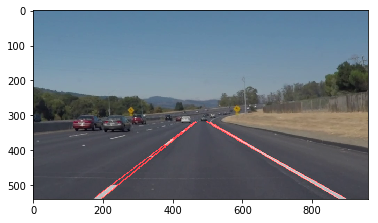

In [44]:
white_output = 'mysolidWhiteRight.mp4'
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [45]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

[0] is the line now!
[[109 535 457 325]]
[0] We have -ve slope here is -0.603448275862 (right line) avg: -0.603448275862
[1] is the line now!
[[124 538 414 357]]
[0] We have -ve slope here is -0.624137931034 (right line) avg: -0.624137931034
[2] is the line now!
[[217 479 440 339]]
[1] We have -ve slope here is -0.627802690583 (right line) avg: -0.625970310809
[3] is the line now!
[[524 332 759 497]]
[1] We have +ve slope here is 0.702127659574 (left line) avg: 0.351063829787
[4] is the line now!
[[563 359 775 497]]
[2] We have +ve slope here is 0.650943396226 (left line) avg: 0.451023685267
[5] is the line now!
[[105 538 453 329]]
[2] We have -ve slope here is -0.600574712644 (right line) avg: -0.61750511142
[6] is the line now!
[[508 318 711 465]]
[3] We have +ve slope here is 0.724137931034 (left line) avg: 0.519302246709
[7] is the line now!
[[512 319 774 495]]
[3] We have +ve slope here is 0.671755725191 (left line) avg: 0.557415616329
[8] is the line now!
[[510 320 773 497]]
[4] 

  0%|          | 0/682 [00:00<?, ?it/s]

[0] is the line now!
[[109 535 457 325]]
[0] We have -ve slope here is -0.603448275862 (right line) avg: -0.603448275862
[1] is the line now!
[[124 538 414 357]]
[0] We have -ve slope here is -0.624137931034 (right line) avg: -0.624137931034
[2] is the line now!
[[217 479 440 339]]
[1] We have -ve slope here is -0.627802690583 (right line) avg: -0.625970310809
[3] is the line now!
[[524 332 759 497]]
[1] We have +ve slope here is 0.702127659574 (left line) avg: 0.351063829787
[4] is the line now!
[[563 359 775 497]]
[2] We have +ve slope here is 0.650943396226 (left line) avg: 0.451023685267
[5] is the line now!
[[105 538 453 329]]
[2] We have -ve slope here is -0.600574712644 (right line) avg: -0.61750511142
[6] is the line now!
[[508 318 711 465]]
[3] We have +ve slope here is 0.724137931034 (left line) avg: 0.519302246709
[7] is the line now!
[[512 319 774 495]]
[3] We have +ve slope here is 0.671755725191 (left line) avg: 0.557415616329
[8] is the line now!
[[510 320 773 497]]
[4] 

  1%|          | 6/682 [00:00<00:24, 27.36it/s]

[0] is the line now!
[[132 539 450 332]]
[0] We have -ve slope here is -0.650943396226 (right line) avg: -0.650943396226
[1] is the line now!
[[186 493 460 322]]
[0] We have -ve slope here is -0.624087591241 (right line) avg: -0.624087591241
[2] is the line now!
[[525 333 839 537]]
[1] We have +ve slope here is 0.649681528662 (left line) avg: 0.324840764331
[3] is the line now!
[[517 327 820 539]]
[1] We have +ve slope here is 0.699669966997 (left line) avg: 0.512255365664
[4] is the line now!
[[131 538 453 329]]
[2] We have -ve slope here is -0.649068322981 (right line) avg: -0.632414501821
[5] is the line now!
[[514 324 819 538]]
[2] We have +ve slope here is 0.701639344262 (left line) avg: 0.57538335853
[6] is the line now!
[[115 535 445 336]]
[3] We have -ve slope here is -0.60303030303 (right line) avg: -0.625068452123
[7] is the line now!
[[508 318 748 480]]
[3] We have +ve slope here is 0.675 (left line) avg: 0.600287518898
[8] is the line now!
[[351 392 462 320]]
[4] We have -v

  1%|▏         | 9/682 [00:00<00:24, 27.76it/s]

[0] is the line now!
[[120 538 453 330]]
[0] We have -ve slope here is -0.624624624625 (right line) avg: -0.624624624625
[1] is the line now!
[[198 499 434 345]]
[0] We have -ve slope here is -0.652542372881 (right line) avg: -0.652542372881
[2] is the line now!
[[139 538 399 369]]
[1] We have -ve slope here is -0.65 (right line) avg: -0.651271186441
[3] is the line now!
[[510 318 693 451]]
[1] We have +ve slope here is 0.726775956284 (left line) avg: 0.363387978142
[4] is the line now!
[[119 538 457 326]]
[2] We have -ve slope here is -0.627218934911 (right line) avg: -0.643253769264
[5] is the line now!
[[515 320 709 451]]
[2] We have +ve slope here is 0.675257731959 (left line) avg: 0.467344562748
[6] is the line now!
[[518 327 705 448]]
[3] We have +ve slope here is 0.647058823529 (left line) avg: 0.512273127943
[0] is the line now!
[[120 538 449 332]]
[0] We have -ve slope here is -0.626139817629 (right line) avg: -0.626139817629
[1] is the line now!
[[240 471 431 346]]
[0] We hav

  2%|▏         | 12/682 [00:00<00:24, 26.93it/s]

[0] is the line now!
[[146 539 368 389]]
[0] We have -ve slope here is -0.675675675676 (right line) avg: -0.675675675676
[1] is the line now!
[[197 492 431 345]]
[0] We have -ve slope here is -0.628205128205 (right line) avg: -0.628205128205
[2] is the line now!
[[522 328 767 481]]
[1] We have +ve slope here is 0.624489795918 (left line) avg: 0.312244897959
[3] is the line now!
[[126 539 452 327]]
[1] We have -ve slope here is -0.650306748466 (right line) avg: -0.639255938336
[4] is the line now!
[[524 330 751 483]]
[2] We have +ve slope here is 0.674008810573 (left line) avg: 0.43283286883
[5] is the line now!
[[145 538 420 353]]
[2] We have -ve slope here is -0.672727272727 (right line) avg: -0.6504130498
[6] is the line now!
[[515 318 738 474]]
[3] We have +ve slope here is 0.699551569507 (left line) avg: 0.499512543999
[7] is the line now!
[[239 467 447 332]]
[3] We have -ve slope here is -0.649038461538 (right line) avg: -0.650069402734
[8] is the line now!
[[582 364 754 484]]
[4]

  2%|▏         | 15/682 [00:00<00:24, 27.09it/s]

[0] is the line now!
[[181 519 441 337]]
[0] We have -ve slope here is -0.7 (right line) avg: -0.7
[1] is the line now!
[[239 470 451 327]]
[0] We have -ve slope here is -0.674528301887 (right line) avg: -0.674528301887
[2] is the line now!
[[189 502 456 322]]
[1] We have -ve slope here is -0.674157303371 (right line) avg: -0.674342802629
[3] is the line now!
[[542 344 840 538]]
[1] We have +ve slope here is 0.651006711409 (left line) avg: 0.325503355705
[4] is the line now!
[[512 320 861 538]]
[2] We have +ve slope here is 0.624641833811 (left line) avg: 0.42521618174
[5] is the line now!
[[515 323 860 539]]
[2] We have +ve slope here is 0.626086956522 (left line) avg: 0.492173106667
[6] is the line now!
[[152 538 446 332]]
[3] We have -ve slope here is -0.700680272109 (right line) avg: -0.680927169999
[7] is the line now!
[[131 538 165 516]]
[3] We have -ve slope here is -0.647058823529 (right line) avg: -0.672460083381
[8] is the line now!
[[516 320 839 538]]
[4] We have +ve slope h

  3%|▎         | 21/682 [00:00<00:24, 27.33it/s]

[0] is the line now!
[[154 538 433 343]]
[0] We have -ve slope here is -0.698924731183 (right line) avg: -0.698924731183
[1] is the line now!
[[178 511 448 329]]
[0] We have -ve slope here is -0.674074074074 (right line) avg: -0.674074074074
[2] is the line now!
[[136 539 450 327]]
[1] We have -ve slope here is -0.675159235669 (right line) avg: -0.674616654871
[3] is the line now!
[[156 539 416 356]]
[1] We have -ve slope here is -0.703846153846 (right line) avg: -0.689231404359
[4] is the line now!
[[511 318 689 442]]
[2] We have +ve slope here is 0.696629213483 (left line) avg: 0.232209737828
[5] is the line now!
[[546 345 702 439]]
[2] We have +ve slope here is 0.602564102564 (left line) avg: 0.35566119274
[0] is the line now!
[[154 538 429 345]]
[0] We have -ve slope here is -0.701818181818 (right line) avg: -0.701818181818
[1] is the line now!
[[135 538 174 512]]
[0] We have -ve slope here is -0.666666666667 (right line) avg: -0.666666666667
[2] is the line now!
[[421 345 453 323]

  4%|▎         | 24/682 [00:00<00:24, 27.26it/s]

[0] is the line now!
[[155 539 394 371]]
[0] We have -ve slope here is -0.702928870293 (right line) avg: -0.702928870293
[1] is the line now!
[[134 539 449 326]]
[0] We have -ve slope here is -0.67619047619 (right line) avg: -0.67619047619
[2] is the line now!
[[534 337 745 474]]
[1] We have +ve slope here is 0.649289099526 (left line) avg: 0.324644549763
[3] is the line now!
[[256 457 429 344]]
[1] We have -ve slope here is -0.653179190751 (right line) avg: -0.664684833471
[4] is the line now!
[[520 326 759 475]]
[2] We have +ve slope here is 0.623430962343 (left line) avg: 0.424240020623
[5] is the line now!
[[155 538 455 320]]
[2] We have -ve slope here is -0.726666666667 (right line) avg: -0.685345444536
[6] is the line now!
[[134 538 415 355]]
[3] We have -ve slope here is -0.651245551601 (right line) avg: -0.676820471303
[7] is the line now!
[[343 405 406 362]]
[3] We have -ve slope here is -0.68253968254 (right line) avg: -0.678250274112
[8] is the line now!
[[211 499 443 331]]


  4%|▍         | 30/682 [00:01<00:23, 27.53it/s]

[0] is the line now!
[[139 538 435 338]]
[0] We have -ve slope here is -0.675675675676 (right line) avg: -0.675675675676
[1] is the line now!
[[523 327 855 527]]
[0] We have +ve slope here is 0.602409638554 (left line) avg: 0.602409638554
[2] is the line now!
[[160 537 363 394]]
[1] We have -ve slope here is -0.704433497537 (right line) avg: -0.690054586606
[3] is the line now!
[[539 338 872 538]]
[1] We have +ve slope here is 0.600600600601 (left line) avg: 0.601505119577
[4] is the line now!
[[361 394 404 363]]
[2] We have -ve slope here is -0.720930232558 (right line) avg: -0.70034646859
[5] is the line now!
[[635 403 852 538]]
[2] We have +ve slope here is 0.622119815668 (left line) avg: 0.608376684941
[6] is the line now!
[[299 442 447 322]]
[3] We have -ve slope here is -0.810810810811 (right line) avg: -0.727962554145
[7] is the line now!
[[162 537 429 343]]
[3] We have -ve slope here is -0.7265917603 (right line) avg: -0.727619855684
[8] is the line now!
[[242 470 449 325]]
[4]

  5%|▍         | 33/682 [00:01<00:23, 28.03it/s]

[0] is the line now!
[[200 499 447 326]]
[0] We have -ve slope here is -0.7004048583 (right line) avg: -0.7004048583
[1] is the line now!
[[162 539 393 371]]
[0] We have -ve slope here is -0.727272727273 (right line) avg: -0.727272727273
[2] is the line now!
[[163 538 406 361]]
[1] We have -ve slope here is -0.728395061728 (right line) avg: -0.727833894501
[3] is the line now!
[[141 539 456 318]]
[1] We have -ve slope here is -0.701587301587 (right line) avg: -0.714710598044
[4] is the line now!
[[161 538 445 323]]
[2] We have -ve slope here is -0.757042253521 (right line) avg: -0.72882114987
[5] is the line now!
[[180 511 425 345]]
[2] We have -ve slope here is -0.677551020408 (right line) avg: -0.711731106716
[6] is the line now!
[[527 328 702 433]]
[3] We have +ve slope here is 0.6 (left line) avg: 0.15
[7] is the line now!
[[520 319 608 383]]
[3] We have +ve slope here is 0.727272727273 (left line) avg: 0.294318181818
[0] is the line now!
[[163 539 388 375]]
[0] We have -ve slope h

  5%|▌         | 36/682 [00:01<00:22, 28.23it/s]

[0] is the line now!
[[145 538 443 329]]
[0] We have -ve slope here is -0.701342281879 (right line) avg: -0.701342281879
[1] is the line now!
[[165 538 383 380]]
[0] We have -ve slope here is -0.724770642202 (right line) avg: -0.724770642202
[2] is the line now!
[[254 464 455 318]]
[1] We have -ve slope here is -0.726368159204 (right line) avg: -0.725569400703
[3] is the line now!
[[517 319 803 498]]
[1] We have +ve slope here is 0.625874125874 (left line) avg: 0.312937062937
[4] is the line now!
[[181 514 434 337]]
[2] We have -ve slope here is -0.699604743083 (right line) avg: -0.71691451483
[5] is the line now!
[[530 330 661 415]]
[2] We have +ve slope here is 0.648854961832 (left line) avg: 0.424909695902
[6] is the line now!
[[263 468 405 361]]
[3] We have -ve slope here is -0.753521126761 (right line) avg: -0.726066167812
[7] is the line now!
[[381 383 447 319]]
[3] We have -ve slope here is -0.969696969697 (right line) avg: -0.786973868284
[0] is the line now!
[[145 538 439 332]

  6%|▌         | 39/682 [00:01<00:22, 28.45it/s]

[0] is the line now!
[[217 490 454 318]]
[0] We have -ve slope here is -0.725738396624 (right line) avg: -0.725738396624
[1] is the line now!
[[167 539 407 358]]
[0] We have -ve slope here is -0.754166666667 (right line) avg: -0.754166666667
[2] is the line now!
[[260 460 450 322]]
[1] We have -ve slope here is -0.726315789474 (right line) avg: -0.74024122807
[3] is the line now!
[[521 323 730 459]]
[1] We have +ve slope here is 0.650717703349 (left line) avg: 0.325358851675
[4] is the line now!
[[520 320 745 460]]
[2] We have +ve slope here is 0.622222222222 (left line) avg: 0.424313308524
[5] is the line now!
[[147 539 442 324]]
[2] We have -ve slope here is -0.728813559322 (right line) avg: -0.736432005154
[6] is the line now!
[[257 473 442 329]]
[3] We have -ve slope here is -0.778378378378 (right line) avg: -0.74691859846
[7] is the line now!
[[522 319 745 458]]
[3] We have +ve slope here is 0.62331838565 (left line) avg: 0.474064577805
[8] is the line now!
[[520 321 734 460]]
[4]

  6%|▌         | 42/682 [00:01<00:22, 28.44it/s]

[0] is the line now!
[[144 538 424 342]]
[0] We have -ve slope here is -0.7 (right line) avg: -0.7
[1] is the line now!
[[165 539 392 368]]
[0] We have -ve slope here is -0.753303964758 (right line) avg: -0.753303964758
[2] is the line now!
[[584 365 883 538]]
[1] We have +ve slope here is 0.578595317726 (left line) avg: 0.289297658863
[3] is the line now!
[[572 357 863 538]]
[1] We have +ve slope here is 0.621993127148 (left line) avg: 0.455645393005
[4] is the line now!
[[243 468 436 332]]
[2] We have -ve slope here is -0.704663212435 (right line) avg: -0.73709038065
[5] is the line now!
[[521 321 883 539]]
[2] We have +ve slope here is 0.602209944751 (left line) avg: 0.504500243587
[6] is the line now!
[[165 538 447 318]]
[3] We have -ve slope here is -0.780141843972 (right line) avg: -0.747853246481
[7] is the line now!
[[522 320 817 511]]
[3] We have +ve slope here is 0.647457627119 (left line) avg: 0.54023958947
[8] is the line now!
[[344 405 452 318]]
[4] We have -ve slope here 

  7%|▋         | 45/682 [00:01<00:22, 28.71it/s]

[0] is the line now!
[[143 538 431 336]]
[0] We have -ve slope here is -0.701388888889 (right line) avg: -0.701388888889
[1] is the line now!
[[186 523 385 373]]
[0] We have -ve slope here is -0.753768844221 (right line) avg: -0.753768844221
[2] is the line now!
[[183 525 439 325]]
[1] We have -ve slope here is -0.78125 (right line) avg: -0.767509422111
[3] is the line now!
[[143 539 425 341]]
[1] We have -ve slope here is -0.702127659574 (right line) avg: -0.734818540843
[4] is the line now!
[[514 318 851 528]]
[2] We have +ve slope here is 0.623145400593 (left line) avg: 0.207715133531
[5] is the line now!
[[164 539 415 349]]
[2] We have -ve slope here is -0.756972111554 (right line) avg: -0.742203064413
[6] is the line now!
[[523 325 676 424]]
[3] We have +ve slope here is 0.647058823529 (left line) avg: 0.317551056031
[7] is the line now!
[[516 318 883 539]]
[3] We have +ve slope here is 0.602179836512 (left line) avg: 0.388708251151
[0] is the line now!
[[201 512 379 378]]
[0] We 

  7%|▋         | 48/682 [00:01<00:22, 27.77it/s]

[0] is the line now!
[[168 537 391 369]]
[0] We have -ve slope here is -0.7533632287 (right line) avg: -0.7533632287
[1] is the line now!
[[146 538 431 338]]
[0] We have -ve slope here is -0.701754385965 (right line) avg: -0.701754385965
[2] is the line now!
[[330 408 447 320]]
[1] We have -ve slope here is -0.752136752137 (right line) avg: -0.726945569051
[3] is the line now!
[[520 322 668 422]]
[1] We have +ve slope here is 0.675675675676 (left line) avg: 0.337837837838
[4] is the line now!
[[544 343 727 449]]
[2] We have +ve slope here is 0.579234972678 (left line) avg: 0.418303549451
[5] is the line now!
[[254 461 401 361]]
[2] We have -ve slope here is -0.680272108844 (right line) avg: -0.711387748982
[6] is the line now!
[[279 443 444 327]]
[3] We have -ve slope here is -0.70303030303 (right line) avg: -0.709298387494
[7] is the line now!
[[516 323 712 450]]
[3] We have +ve slope here is 0.647959183673 (left line) avg: 0.475717458007
[0] is the line now!
[[165 539 432 337]]
[0] W

  7%|▋         | 51/682 [00:01<00:26, 23.52it/s]

[0] is the line now!
[[150 535 449 318]]
[0] We have -ve slope here is -0.725752508361 (right line) avg: -0.725752508361
[1] is the line now!
[[165 539 397 364]]
[0] We have -ve slope here is -0.754310344828 (right line) avg: -0.754310344828
[2] is the line now!
[[510 318 809 498]]
[1] We have +ve slope here is 0.602006688963 (left line) avg: 0.301003344482
[3] is the line now!
[[533 335 793 498]]
[1] We have +ve slope here is 0.626923076923 (left line) avg: 0.463963210702
[4] is the line now!
[[278 443 415 350]]
[2] We have -ve slope here is -0.678832116788 (right line) avg: -0.729150935481
[5] is the line now!
[[165 538 388 364]]
[2] We have -ve slope here is -0.780269058296 (right line) avg: -0.746190309753
[6] is the line now!
[[512 318 790 498]]
[3] We have +ve slope here is 0.647482014388 (left line) avg: 0.509842911624
[7] is the line now!
[[404 357 452 320]]
[3] We have -ve slope here is -0.770833333333 (right line) avg: -0.752351065648
[8] is the line now!
[[231 477 390 369]]


  8%|▊         | 54/682 [00:02<00:26, 23.41it/s]

[0] is the line now!
[[236 472 455 318]]
[0] We have -ve slope here is -0.703196347032 (right line) avg: -0.703196347032
[1] is the line now!
[[164 539 446 326]]
[0] We have -ve slope here is -0.755319148936 (right line) avg: -0.755319148936
[2] is the line now!
[[510 318 877 539]]
[1] We have +ve slope here is 0.602179836512 (left line) avg: 0.301089918256
[3] is the line now!
[[213 490 450 318]]
[1] We have -ve slope here is -0.725738396624 (right line) avg: -0.74052877278
[4] is the line now!
[[536 338 857 538]]
[2] We have +ve slope here is 0.623052959502 (left line) avg: 0.408410932005
[5] is the line now!
[[572 362 856 539]]
[2] We have +ve slope here is 0.62323943662 (left line) avg: 0.480020433543
[6] is the line now!
[[143 539 201 497]]
[3] We have -ve slope here is -0.724137931034 (right line) avg: -0.736431062344
[7] is the line now!
[[510 319 828 510]]
[3] We have +ve slope here is 0.600628930818 (left line) avg: 0.510172557862
[8] is the line now!
[[143 538 447 325]]
[4] W

  8%|▊         | 57/682 [00:02<00:25, 24.77it/s]

[0] is the line now!
[[142 539 452 321]]
[0] We have -ve slope here is -0.703225806452 (right line) avg: -0.703225806452
[1] is the line now!
[[259 468 446 327]]
[0] We have -ve slope here is -0.754010695187 (right line) avg: -0.754010695187
[2] is the line now!
[[162 538 454 318]]
[1] We have -ve slope here is -0.753424657534 (right line) avg: -0.753717676361
[3] is the line now!
[[230 489 450 318]]
[1] We have -ve slope here is -0.777272727273 (right line) avg: -0.765495201817
[4] is the line now!
[[512 321 615 390]]
[2] We have +ve slope here is 0.669902912621 (left line) avg: 0.223300970874
[5] is the line now!
[[509 318 690 431]]
[2] We have +ve slope here is 0.624309392265 (left line) avg: 0.356970444671
[6] is the line now!
[[212 502 456 318]]
[3] We have -ve slope here is -0.754098360656 (right line) avg: -0.762645991526
[0] is the line now!
[[141 539 452 321]]
[0] We have -ve slope here is -0.700964630225 (right line) avg: -0.700964630225
[1] is the line now!
[[162 539 454 319

  9%|▉         | 60/682 [00:02<00:24, 25.79it/s]

[0] is the line now!
[[141 539 452 321]]
[0] We have -ve slope here is -0.700964630225 (right line) avg: -0.700964630225
[1] is the line now!
[[182 524 453 320]]
[0] We have -ve slope here is -0.752767527675 (right line) avg: -0.752767527675
[2] is the line now!
[[364 389 441 331]]
[1] We have -ve slope here is -0.753246753247 (right line) avg: -0.753007140461
[3] is the line now!
[[513 323 654 415]]
[1] We have +ve slope here is 0.652482269504 (left line) avg: 0.326241134752
[4] is the line now!
[[341 406 450 318]]
[2] We have -ve slope here is -0.807339449541 (right line) avg: -0.771117910154
[5] is the line now!
[[510 318 787 491]]
[2] We have +ve slope here is 0.624548736462 (left line) avg: 0.425677001989
[6] is the line now!
[[161 538 339 399]]
[3] We have -ve slope here is -0.780898876404 (right line) avg: -0.773563151717
[7] is the line now!
[[141 538 455 318]]
[3] We have -ve slope here is -0.700636942675 (right line) avg: -0.755331599457
[8] is the line now!
[[507 318 770 489

  9%|▉         | 63/682 [00:02<00:25, 24.55it/s]

[0] is the line now!
[[158 538 423 345]]
[0] We have -ve slope here is -0.728301886792 (right line) avg: -0.728301886792
[1] is the line now!
[[138 539 454 318]]
[0] We have -ve slope here is -0.699367088608 (right line) avg: -0.699367088608
[2] is the line now!
[[528 334 732 456]]
[1] We have +ve slope here is 0.598039215686 (left line) avg: 0.299019607843
[3] is the line now!
[[511 319 685 436]]
[1] We have +ve slope here is 0.672413793103 (left line) avg: 0.485716700473
[4] is the line now!
[[288 435 456 318]]
[2] We have -ve slope here is -0.696428571429 (right line) avg: -0.698387582881
[5] is the line now!
[[200 494 439 332]]
[2] We have -ve slope here is -0.677824267782 (right line) avg: -0.691533144515
[6] is the line now!
[[555 353 723 458]]
[3] We have +ve slope here is 0.625 (left line) avg: 0.520537525355
[7] is the line now!
[[516 325 719 457]]
[3] We have +ve slope here is 0.650246305419 (left line) avg: 0.552964720371
[0] is the line now!
[[200 495 454 318]]
[0] We have 

 10%|▉         | 66/682 [00:02<00:25, 23.74it/s]

[0] is the line now!
[[158 539 434 338]]
[0] We have -ve slope here is -0.728260869565 (right line) avg: -0.728260869565
[1] is the line now!
[[137 538 435 337]]
[0] We have -ve slope here is -0.674496644295 (right line) avg: -0.674496644295
[2] is the line now!
[[310 421 452 318]]
[1] We have -ve slope here is -0.725352112676 (right line) avg: -0.699924378486
[3] is the line now!
[[507 318 848 539]]
[1] We have +ve slope here is 0.648093841642 (left line) avg: 0.324046920821
[4] is the line now!
[[520 329 868 538]]
[2] We have +ve slope here is 0.600574712644 (left line) avg: 0.416222851429
[5] is the line now!
[[351 393 439 329]]
[2] We have -ve slope here is -0.727272727273 (right line) avg: -0.709040494748
[6] is the line now!
[[576 368 848 538]]
[3] We have +ve slope here is 0.625 (left line) avg: 0.468417138571
[7] is the line now!
[[230 476 454 320]]
[3] We have -ve slope here is -0.696428571429 (right line) avg: -0.705887513918
[0] is the line now!
[[158 538 440 333]]
[0] We ha

 10%|█         | 69/682 [00:02<00:24, 24.84it/s]

[0] is the line now!
[[158 524 446 329]]
[0] We have -ve slope here is -0.677083333333 (right line) avg: -0.677083333333
[1] is the line now!
[[158 538 447 328]]
[0] We have -ve slope here is -0.726643598616 (right line) avg: -0.726643598616
[2] is the line now!
[[158 539 433 339]]
[1] We have -ve slope here is -0.727272727273 (right line) avg: -0.726958162944
[3] is the line now!
[[509 319 693 439]]
[1] We have +ve slope here is 0.652173913043 (left line) avg: 0.326086956522
[4] is the line now!
[[197 499 440 329]]
[2] We have -ve slope here is -0.699588477366 (right line) avg: -0.717834934418
[5] is the line now!
[[506 319 617 394]]
[2] We have +ve slope here is 0.675675675676 (left line) avg: 0.442616529573
[6] is the line now!
[[138 538 179 510]]
[3] We have -ve slope here is -0.682926829268 (right line) avg: -0.709107908131
[0] is the line now!
[[158 539 446 329]]
[0] We have -ve slope here is -0.729166666667 (right line) avg: -0.729166666667
[1] is the line now!
[[175 514 445 325

 11%|█         | 72/682 [00:02<00:23, 25.57it/s]

[0] is the line now!
[[157 539 451 325]]
[0] We have -ve slope here is -0.727891156463 (right line) avg: -0.727891156463
[1] is the line now!
[[211 489 448 323]]
[0] We have -ve slope here is -0.700421940928 (right line) avg: -0.700421940928
[2] is the line now!
[[213 499 440 334]]
[1] We have -ve slope here is -0.726872246696 (right line) avg: -0.713647093812
[3] is the line now!
[[331 408 454 322]]
[1] We have -ve slope here is -0.69918699187 (right line) avg: -0.706417042841
[4] is the line now!
[[505 318 686 431]]
[2] We have +ve slope here is 0.624309392265 (left line) avg: 0.208103130755
[5] is the line now!
[[137 538 437 335]]
[2] We have -ve slope here is -0.676666666667 (right line) avg: -0.696500250783
[6] is the line now!
[[619 397 847 539]]
[3] We have +ve slope here is 0.622807017544 (left line) avg: 0.311779102452
[7] is the line now!
[[528 336 673 430]]
[3] We have +ve slope here is 0.648275862069 (left line) avg: 0.395903292356
[0] is the line now!
[[218 496 430 342]]
[

 11%|█         | 75/682 [00:02<00:22, 26.45it/s]

[0] is the line now!
[[158 539 448 328]]
[0] We have -ve slope here is -0.727586206897 (right line) avg: -0.727586206897
[1] is the line now!
[[279 444 459 318]]
[0] We have -ve slope here is -0.7 (right line) avg: -0.7
[2] is the line now!
[[144 535 454 318]]
[1] We have -ve slope here is -0.7 (right line) avg: -0.7
[3] is the line now!
[[508 318 729 467]]
[1] We have +ve slope here is 0.674208144796 (left line) avg: 0.337104072398
[4] is the line now!
[[211 490 441 329]]
[2] We have -ve slope here is -0.7 (right line) avg: -0.7
[5] is the line now!
[[565 362 743 465]]
[2] We have +ve slope here is 0.578651685393 (left line) avg: 0.417619943397
[6] is the line now!
[[555 355 727 467]]
[3] We have +ve slope here is 0.651162790698 (left line) avg: 0.476005655222
[7] is the line now!
[[182 520 352 400]]
[3] We have -ve slope here is -0.705882352941 (right line) avg: -0.701470588235
[8] is the line now!
[[139 537 375 383]]
[4] We have -ve slope here is -0.652542372881 (right line) avg: -0

 11%|█▏        | 78/682 [00:02<00:24, 25.09it/s]

[3] is the line now!
[[168 532 453 318]]
[1] We have -ve slope here is -0.750877192982 (right line) avg: -0.738567088111
[4] is the line now!
[[510 321 750 482]]
[2] We have +ve slope here is 0.670833333333 (left line) avg: 0.424228395062
[5] is the line now!
[[519 330 836 536]]
[2] We have +ve slope here is 0.649842271293 (left line) avg: 0.499433020472
[6] is the line now!
[[222 493 449 322]]
[3] We have -ve slope here is -0.753303964758 (right line) avg: -0.742251307273
[7] is the line now!
[[314 418 451 325]]
[3] We have -ve slope here is -0.678832116788 (right line) avg: -0.726396509652
[8] is the line now!
[[158 539 448 328]]
[4] We have -ve slope here is -0.727586206897 (right line) avg: -0.726634449101
[9] is the line now!
[[565 362 800 514]]
[4] We have +ve slope here is 0.646808510638 (left line) avg: 0.528908118505
[0] is the line now!
[[169 518 449 322]]
[0] We have -ve slope here is -0.7 (right line) avg: -0.7
[1] is the line now!
[[158 539 449 327]]
[0] We have -ve slope 

 12%|█▏        | 81/682 [00:03<00:26, 23.00it/s]

[0] is the line now!
[[157 539 453 323]]
[0] We have -ve slope here is -0.72972972973 (right line) avg: -0.72972972973
[1] is the line now!
[[241 469 457 318]]
[0] We have -ve slope here is -0.699074074074 (right line) avg: -0.699074074074
[2] is the line now!
[[217 496 440 334]]
[1] We have -ve slope here is -0.726457399103 (right line) avg: -0.712765736589
[3] is the line now!
[[540 345 861 538]]
[1] We have +ve slope here is 0.601246105919 (left line) avg: 0.30062305296
[4] is the line now!
[[137 539 202 494]]
[2] We have -ve slope here is -0.692307692308 (right line) avg: -0.705946388495
[5] is the line now!
[[522 332 840 539]]
[2] We have +ve slope here is 0.650943396226 (left line) avg: 0.417396500715
[6] is the line now!
[[508 319 783 504]]
[3] We have +ve slope here is 0.672727272727 (left line) avg: 0.481229193718
[7] is the line now!
[[196 499 230 475]]
[3] We have -ve slope here is -0.705882352941 (right line) avg: -0.705930379607
[8] is the line now!
[[207 492 448 323]]
[4]

 13%|█▎        | 87/682 [00:03<00:24, 24.01it/s]


[0] We have -ve slope here is -0.676923076923 (right line) avg: -0.676923076923
[2] is the line now!
[[134 539 450 325]]
[1] We have -ve slope here is -0.677215189873 (right line) avg: -0.677069133398
[3] is the line now!
[[225 489 453 318]]
[1] We have -ve slope here is -0.75 (right line) avg: -0.713534566699
[4] is the line now!
[[507 318 755 479]]
[2] We have +ve slope here is 0.649193548387 (left line) avg: 0.216397849462
[5] is the line now!
[[154 539 455 320]]
[2] We have -ve slope here is -0.727574750831 (right line) avg: -0.718214628076
[6] is the line now!
[[506 320 746 482]]
[3] We have +ve slope here is 0.675 (left line) avg: 0.331048387097
[7] is the line now!
[[331 412 454 320]]
[3] We have -ve slope here is -0.747967479675 (right line) avg: -0.725652840976
[0] is the line now!
[[133 538 457 319]]
[0] We have -ve slope here is -0.675925925926 (right line) avg: -0.675925925926
[1] is the line now!
[[155 539 451 324]]
[0] We have -ve slope here is -0.726351351351 (right lin

 13%|█▎        | 90/682 [00:03<00:25, 23.63it/s]

[0] is the line now!
[[149 539 327 414]]
[0] We have -ve slope here is -0.702247191011 (right line) avg: -0.702247191011
[1] is the line now!
[[129 539 457 318]]
[0] We have -ve slope here is -0.673780487805 (right line) avg: -0.673780487805
[2] is the line now!
[[505 318 796 500]]
[1] We have +ve slope here is 0.625429553265 (left line) avg: 0.312714776632
[3] is the line now!
[[558 357 782 502]]
[1] We have +ve slope here is 0.647321428571 (left line) avg: 0.480018102602
[4] is the line now!
[[149 538 437 336]]
[2] We have -ve slope here is -0.701388888889 (right line) avg: -0.682983288166
[5] is the line now!
[[129 538 442 327]]
[2] We have -ve slope here is -0.674121405751 (right line) avg: -0.680029327361
[6] is the line now!
[[505 319 796 501]]
[3] We have +ve slope here is 0.625429553265 (left line) avg: 0.516370965268
[7] is the line now!
[[322 421 458 318]]
[3] We have -ve slope here is -0.757352941176 (right line) avg: -0.699360230815
[8] is the line now!
[[504 318 746 481]]


 14%|█▎        | 93/682 [00:03<00:25, 23.51it/s]

[0] is the line now!
[[135 539 462 318]]
[0] We have -ve slope here is -0.675840978593 (right line) avg: -0.675840978593
[1] is the line now!
[[155 538 437 340]]
[0] We have -ve slope here is -0.702127659574 (right line) avg: -0.702127659574
[2] is the line now!
[[505 318 832 539]]
[1] We have +ve slope here is 0.675840978593 (left line) avg: 0.337920489297
[3] is the line now!
[[154 538 446 333]]
[1] We have -ve slope here is -0.702054794521 (right line) avg: -0.702091227048
[4] is the line now!
[[308 424 455 325]]
[2] We have -ve slope here is -0.673469387755 (right line) avg: -0.69255061395
[5] is the line now!
[[575 372 853 539]]
[2] We have +ve slope here is 0.60071942446 (left line) avg: 0.425520134351
[6] is the line now!
[[213 487 464 318]]
[3] We have -ve slope here is -0.673306772908 (right line) avg: -0.68773965369
[7] is the line now!
[[500 318 805 516]]
[3] We have +ve slope here is 0.649180327869 (left line) avg: 0.481435182731


 14%|█▍        | 96/682 [00:03<00:27, 21.67it/s]

[0] is the line now!
[[155 538 444 335]]
[0] We have -ve slope here is -0.702422145329 (right line) avg: -0.702422145329
[1] is the line now!
[[151 529 464 318]]
[0] We have -ve slope here is -0.674121405751 (right line) avg: -0.674121405751
[2] is the line now!
[[136 539 463 318]]
[1] We have -ve slope here is -0.675840978593 (right line) avg: -0.674981192172
[3] is the line now!
[[499 318 675 432]]
[1] We have +ve slope here is 0.647727272727 (left line) avg: 0.323863636364
[4] is the line now!
[[512 329 665 432]]
[2] We have +ve slope here is 0.673202614379 (left line) avg: 0.440309962369
[5] is the line now!
[[157 537 227 489]]
[2] We have -ve slope here is -0.685714285714 (right line) avg: -0.678558890019
[6] is the line now!
[[441 336 457 324]]
[3] We have -ve slope here is -0.75 (right line) avg: -0.696419167515
[0] is the line now!
[[155 538 439 339]]
[0] We have -ve slope here is -0.700704225352 (right line) avg: -0.700704225352
[1] is the line now!
[[144 534 465 318]]
[0] We 

 15%|█▍        | 99/682 [00:03<00:26, 22.02it/s]

[0] is the line now!
[[136 538 463 318]]
[0] We have -ve slope here is -0.672782874618 (right line) avg: -0.672782874618
[1] is the line now!
[[157 537 423 350]]
[0] We have -ve slope here is -0.703007518797 (right line) avg: -0.703007518797
[2] is the line now!
[[137 539 458 322]]
[1] We have -ve slope here is -0.676012461059 (right line) avg: -0.689509989928
[3] is the line now!
[[308 430 441 336]]
[1] We have -ve slope here is -0.706766917293 (right line) avg: -0.698138453611
[4] is the line now!
[[508 324 819 518]]
[2] We have +ve slope here is 0.623794212219 (left line) avg: 0.207931404073
[5] is the line now!
[[609 394 799 517]]
[2] We have +ve slope here is 0.647368421053 (left line) avg: 0.354410409733
[6] is the line now!
[[166 531 373 391]]
[3] We have -ve slope here is -0.676328502415 (right line) avg: -0.692685965812
[7] is the line now!
[[501 318 796 517]]
[3] We have +ve slope here is 0.674576271186 (left line) avg: 0.434451875096
[0] is the line now!
[[137 538 463 318]]


 15%|█▍        | 102/682 [00:04<00:24, 23.65it/s]

[0] is the line now!
[[135 539 463 318]]
[0] We have -ve slope here is -0.673780487805 (right line) avg: -0.673780487805
[1] is the line now!
[[155 538 365 391]]
[0] We have -ve slope here is -0.7 (right line) avg: -0.7
[2] is the line now!
[[506 321 839 529]]
[1] We have +ve slope here is 0.624624624625 (left line) avg: 0.312312312312
[3] is the line now!
[[682 441 821 531]]
[1] We have +ve slope here is 0.647482014388 (left line) avg: 0.47989716335
[4] is the line now!
[[222 490 435 340]]
[2] We have -ve slope here is -0.704225352113 (right line) avg: -0.701408450704
[5] is the line now!
[[513 323 814 526]]
[2] We have +ve slope here is 0.674418604651 (left line) avg: 0.544737643784
[6] is the line now!
[[518 331 837 530]]
[3] We have +ve slope here is 0.623824451411 (left line) avg: 0.564509345691
[7] is the line now!
[[353 393 457 318]]
[3] We have -ve slope here is -0.721153846154 (right line) avg: -0.706344799567


 15%|█▌        | 105/682 [00:04<00:24, 23.69it/s]

[0] is the line now!
[[197 497 463 318]]
[0] We have -ve slope here is -0.672932330827 (right line) avg: -0.672932330827
[1] is the line now!
[[154 538 423 349]]
[0] We have -ve slope here is -0.702602230483 (right line) avg: -0.702602230483
[2] is the line now!
[[502 318 854 538]]
[1] We have +ve slope here is 0.625 (left line) avg: 0.3125
[3] is the line now!
[[708 458 832 539]]
[1] We have +ve slope here is 0.653225806452 (left line) avg: 0.482862903226
[4] is the line now!
[[185 505 240 467]]
[2] We have -ve slope here is -0.690909090909 (right line) avg: -0.698704517292
[5] is the line now!
[[568 365 828 521]]
[2] We have +ve slope here is 0.6 (left line) avg: 0.521908602151
[6] is the line now!
[[155 538 400 366]]
[3] We have -ve slope here is -0.702040816327 (right line) avg: -0.699538592051
[7] is the line now!
[[134 538 446 327]]
[3] We have -ve slope here is -0.676282051282 (right line) avg: -0.693724456858
[8] is the line now!
[[512 322 832 538]]
[4] We have +ve slope here i

 16%|█▌        | 108/682 [00:04<00:23, 24.71it/s]

[0] is the line now!
[[215 485 464 318]]
[0] We have -ve slope here is -0.670682730924 (right line) avg: -0.670682730924
[1] is the line now!
[[154 539 396 369]]
[0] We have -ve slope here is -0.702479338843 (right line) avg: -0.702479338843
[2] is the line now!
[[153 538 431 343]]
[1] We have -ve slope here is -0.701438848921 (right line) avg: -0.701959093882
[3] is the line now!
[[132 539 450 324]]
[1] We have -ve slope here is -0.676100628931 (right line) avg: -0.689029861406
[4] is the line now!
[[501 318 694 448]]
[2] We have +ve slope here is 0.673575129534 (left line) avg: 0.224525043178
[5] is the line now!
[[195 498 247 462]]
[2] We have -ve slope here is -0.692307692308 (right line) avg: -0.690122471707
[6] is the line now!
[[509 321 706 449]]
[3] We have +ve slope here is 0.649746192893 (left line) avg: 0.330830330607


 16%|█▋        | 111/682 [00:04<00:23, 24.22it/s]

[0] is the line now!
[[155 538 413 357]]
[0] We have -ve slope here is -0.701550387597 (right line) avg: -0.701550387597
[1] is the line now!
[[154 526 463 318]]
[0] We have -ve slope here is -0.673139158576 (right line) avg: -0.673139158576
[2] is the line now!
[[243 467 464 318]]
[1] We have -ve slope here is -0.674208144796 (right line) avg: -0.673673651686
[3] is the line now!
[[507 323 631 407]]
[1] We have +ve slope here is 0.677419354839 (left line) avg: 0.338709677419
[4] is the line now!
[[400 365 450 329]]
[2] We have -ve slope here is -0.72 (right line) avg: -0.689115767791
[5] is the line now!
[[524 336 743 468]]
[2] We have +ve slope here is 0.602739726027 (left line) avg: 0.426719693622
[6] is the line now!
[[501 318 741 468]]
[3] We have +ve slope here is 0.625 (left line) avg: 0.476289770217
[7] is the line now!
[[138 535 425 348]]
[3] We have -ve slope here is -0.651567944251 (right line) avg: -0.679728811906
[0] is the line now!
[[156 538 416 355]]
[0] We have -ve slo

 17%|█▋        | 117/682 [00:04<00:23, 23.74it/s]


[2] We have -ve slope here is -0.701030927835 (right line) avg: -0.69303185032
[6] is the line now!
[[340 413 466 318]]
[3] We have -ve slope here is -0.753968253968 (right line) avg: -0.708265951232
[7] is the line now!
[[505 320 710 458]]
[3] We have +ve slope here is 0.673170731707 (left line) avg: 0.492670510981
[8] is the line now!
[[343 414 450 324]]
[4] We have -ve slope here is -0.841121495327 (right line) avg: -0.734837060051
[0] is the line now!
[[137 539 465 318]]
[0] We have -ve slope here is -0.673780487805 (right line) avg: -0.673780487805
[1] is the line now!
[[157 538 391 374]]
[0] We have -ve slope here is -0.700854700855 (right line) avg: -0.700854700855
[2] is the line now!
[[501 318 756 477]]
[1] We have +ve slope here is 0.623529411765 (left line) avg: 0.311764705882
[3] is the line now!
[[533 342 744 479]]
[1] We have +ve slope here is 0.649289099526 (left line) avg: 0.480526902704
[4] is the line now!
[[137 538 429 341]]
[2] We have -ve slope here is -0.67465753

 18%|█▊        | 120/682 [00:04<00:23, 23.59it/s]

[0] is the line now!
[[137 539 465 318]]
[0] We have -ve slope here is -0.673780487805 (right line) avg: -0.673780487805
[1] is the line now!
[[177 526 292 443]]
[0] We have -ve slope here is -0.721739130435 (right line) avg: -0.721739130435
[2] is the line now!
[[181 529 461 318]]
[1] We have -ve slope here is -0.753571428571 (right line) avg: -0.737655279503
[3] is the line now!
[[179 528 450 324]]
[1] We have -ve slope here is -0.752767527675 (right line) avg: -0.745211403589
[4] is the line now!
[[501 318 823 519]]
[2] We have +ve slope here is 0.624223602484 (left line) avg: 0.208074534161
[5] is the line now!
[[444 333 461 321]]
[2] We have -ve slope here is -0.705882352941 (right line) avg: -0.73210172004
[6] is the line now!
[[544 348 832 535]]
[3] We have +ve slope here is 0.649305555556 (left line) avg: 0.31838228951
[7] is the line now!
[[335 414 464 320]]
[3] We have -ve slope here is -0.728682170543 (right line) avg: -0.731246832666
[8] is the line now!
[[197 530 459 318]]

 18%|█▊        | 123/682 [00:04<00:22, 24.66it/s]

[0] is the line now!
[[180 526 467 318]]
[0] We have -ve slope here is -0.724738675958 (right line) avg: -0.724738675958
[1] is the line now!
[[224 484 462 318]]
[0] We have -ve slope here is -0.697478991597 (right line) avg: -0.697478991597
[2] is the line now!
[[499 318 675 427]]
[1] We have +ve slope here is 0.619318181818 (left line) avg: 0.309659090909
[3] is the line now!
[[558 358 681 438]]
[1] We have +ve slope here is 0.650406504065 (left line) avg: 0.480032797487
[4] is the line now!
[[513 324 690 435]]
[2] We have +ve slope here is 0.627118644068 (left line) avg: 0.529061413014
[5] is the line now!
[[141 539 366 392]]
[2] We have -ve slope here is -0.653333333333 (right line) avg: -0.682763772176
[6] is the line now!
[[142 537 421 348]]
[3] We have -ve slope here is -0.677419354839 (right line) avg: -0.681427667841
[7] is the line now!
[[161 539 361 394]]
[3] We have -ve slope here is -0.725 (right line) avg: -0.692320750881
[8] is the line now!
[[195 503 465 321]]
[4] We ha

 18%|█▊        | 126/682 [00:04<00:21, 25.52it/s]

[0] is the line now!
[[163 539 467 318]]
[0] We have -ve slope here is -0.726973684211 (right line) avg: -0.726973684211
[1] is the line now!
[[224 484 462 318]]
[0] We have -ve slope here is -0.697478991597 (right line) avg: -0.697478991597
[2] is the line now!
[[178 515 349 396]]
[1] We have -ve slope here is -0.695906432749 (right line) avg: -0.696692712173
[3] is the line now!
[[498 318 706 453]]
[1] We have +ve slope here is 0.649038461538 (left line) avg: 0.324519230769
[4] is the line now!
[[499 318 716 453]]
[2] We have +ve slope here is 0.622119815668 (left line) avg: 0.423719425736
[5] is the line now!
[[516 326 717 452]]
[2] We have +ve slope here is 0.626865671642 (left line) avg: 0.491434841038
[6] is the line now!
[[142 539 180 512]]
[3] We have -ve slope here is -0.710526315789 (right line) avg: -0.700151113077
[0] is the line now!
[[164 539 468 318]]
[0] We have -ve slope here is -0.726973684211 (right line) avg: -0.726973684211
[1] is the line now!
[[311 422 461 320]]


 19%|█▉        | 129/682 [00:05<00:22, 25.09it/s]

[0] is the line now!
[[164 539 469 318]]
[0] We have -ve slope here is -0.724590163934 (right line) avg: -0.724590163934
[1] is the line now!
[[143 539 466 321]]
[0] We have -ve slope here is -0.674922600619 (right line) avg: -0.674922600619
[2] is the line now!
[[338 406 464 318]]
[1] We have -ve slope here is -0.698412698413 (right line) avg: -0.686667649516
[3] is the line now!

 19%|█▉        | 132/682 [00:05<00:21, 25.84it/s]


[[147 536 255 461]]
[1] We have -ve slope here is -0.694444444444 (right line) avg: -0.69055604698
[4] is the line now!
[[539 345 860 538]]
[2] We have +ve slope here is 0.601246105919 (left line) avg: 0.20041536864
[5] is the line now!
[[500 319 839 539]]
[2] We have +ve slope here is 0.648967551622 (left line) avg: 0.349932762967
[6] is the line now!
[[504 318 757 482]]
[3] We have +ve slope here is 0.648221343874 (left line) avg: 0.424504908194
[7] is the line now!
[[300 432 463 318]]
[3] We have -ve slope here is -0.699386503067 (right line) avg: -0.692763661002
[8] is the line now!
[[234 477 286 440]]
[4] We have -ve slope here is -0.711538461538 (right line) avg: -0.696518621109
[9] is the line now!
[[165 538 445 319]]
[4] We have -ve slope here is -0.782142857143 (right line) avg: -0.713643468316
[0] is the line now!
[[143 538 469 318]]
[0] We have -ve slope here is -0.674846625767 (right line) avg: -0.674846625767
[1] is the line now!
[[164 539 442 337]]
[0] We have -ve slope 

 20%|█▉        | 135/682 [00:05<00:20, 26.10it/s]

[0] is the line now!
[[143 538 469 318]]
[0] We have -ve slope here is -0.674846625767 (right line) avg: -0.674846625767
[1] is the line now!
[[164 539 446 335]]
[0] We have -ve slope here is -0.723404255319 (right line) avg: -0.723404255319
[2] is the line now!
[[503 319 841 530]]
[1] We have +ve slope here is 0.62426035503 (left line) avg: 0.312130177515
[3] is the line now!
[[505 323 831 535]]
[1] We have +ve slope here is 0.650306748466 (left line) avg: 0.481218462991
[4] is the line now!
[[375 380 464 319]]
[2] We have -ve slope here is -0.685393258427 (right line) avg: -0.710733923022
[5] is the line now!
[[241 484 467 320]]
[2] We have -ve slope here is -0.725663716814 (right line) avg: -0.715710520953


 20%|██        | 138/682 [00:05<00:20, 25.92it/s]

[0] is the line now!
[[145 537 469 318]]
[0] We have -ve slope here is -0.675925925926 (right line) avg: -0.675925925926
[1] is the line now!
[[165 539 467 320]]
[0] We have -ve slope here is -0.725165562914 (right line) avg: -0.725165562914
[2] is the line now!
[[495 319 701 442]]
[1] We have +ve slope here is 0.597087378641 (left line) avg: 0.29854368932
[3] is the line now!
[[525 332 647 417]]
[1] We have +ve slope here is 0.696721311475 (left line) avg: 0.497632500398
[4] is the line now!
[[397 365 466 318]]
[2] We have -ve slope here is -0.68115942029 (right line) avg: -0.710496848706
[5] is the line now!
[[506 321 689 444]]
[2] We have +ve slope here is 0.672131147541 (left line) avg: 0.555798716112
[6] is the line now!
[[144 539 468 320]]
[3] We have -ve slope here is -0.675925925926 (right line) avg: -0.701854118011
[0] is the line now!
[[225 482 458 324]]
[0] We have -ve slope here is -0.678111587983 (right line) avg: -0.678111587983
[1] is the line now!
[[165 538 469 318]]
[0

 21%|██        | 144/682 [00:05<00:21, 25.49it/s]

[0] is the line now!
[[164 539 468 318]]
[0] We have -ve slope here is -0.726973684211 (right line) avg: -0.726973684211
[1] is the line now!
[[208 495 322 416]]
[0] We have -ve slope here is -0.69298245614 (right line) avg: -0.69298245614
[2] is the line now!
[[504 324 863 539]]
[1] We have +ve slope here is 0.598885793872 (left line) avg: 0.299442896936
[3] is the line now!
[[371 382 464 319]]
[1] We have -ve slope here is -0.677419354839 (right line) avg: -0.68520090549
[4] is the line now!
[[175 516 448 331]]
[2] We have -ve slope here is -0.677655677656 (right line) avg: -0.682685829545
[5] is the line now!
[[498 318 836 538]]
[2] We have +ve slope here is 0.650887573964 (left line) avg: 0.416591122612
[6] is the line now!
[[191 520 468 319]]
[3] We have -ve slope here is -0.725631768953 (right line) avg: -0.693422314397
[7] is the line now!
[[499 318 837 538]]
[3] We have +ve slope here is 0.650887573964 (left line) avg: 0.47516523545
[8] is the line now!
[[509 323 742 468]]
[4] 

 22%|██▏       | 150/682 [00:05<00:21, 24.87it/s]

[0] is the line now!
[[218 500 467 319]]
[0] We have -ve slope here is -0.726907630522 (right line) avg: -0.726907630522
[1] is the line now!
[[246 467 467 318]]
[0] We have -ve slope here is -0.674208144796 (right line) avg: -0.674208144796
[2] is the line now!
[[163 539 466 319]]
[1] We have -ve slope here is -0.726072607261 (right line) avg: -0.700140376029
[3] is the line now!
[[142 538 324 415]]
[1] We have -ve slope here is -0.675824175824 (right line) avg: -0.687982275926
[4] is the line now!
[[498 318 802 516]]
[2] We have +ve slope here is 0.651315789474 (left line) avg: 0.217105263158
[5] is the line now!
[[544 344 812 511]]
[2] We have +ve slope here is 0.623134328358 (left line) avg: 0.352448284891
[6] is the line now!
[[505 321 803 515]]
[3] We have +ve slope here is 0.651006711409 (left line) avg: 0.427087891521
[7] is the line now!
[[335 414 463 318]]
[3] We have -ve slope here is -0.75 (right line) avg: -0.703486706945
[0] is the line now!
[[163 538 456 325]]
[0] We hav

 23%|██▎       | 156/682 [00:06<00:20, 25.96it/s]

[0] is the line now!
[[143 538 467 320]]
[0] We have -ve slope here is -0.672839506173 (right line) avg: -0.672839506173
[1] is the line now!
[[507 323 852 530]]
[0] We have +ve slope here is 0.6 (left line) avg: 0.6
[2] is the line now!
[[293 444 466 322]]
[1] We have -ve slope here is -0.705202312139 (right line) avg: -0.689020909156
[3] is the line now!
[[744 477 833 533]]
[1] We have +ve slope here is 0.629213483146 (left line) avg: 0.614606741573
[4] is the line now!
[[163 538 477 318]]
[2] We have -ve slope here is -0.700636942675 (right line) avg: -0.692892920329
[5] is the line now!
[[489 319 837 520]]
[2] We have +ve slope here is 0.577586206897 (left line) avg: 0.602266563348
[6] is the line now!
[[374 380 464 319]]
[3] We have -ve slope here is -0.677777777778 (right line) avg: -0.689114134691
[7] is the line now!
[[496 321 836 533]]
[3] We have +ve slope here is 0.623529411765 (left line) avg: 0.607582275452
[8] is the line now!
[[500 320 852 532]]
[4] We have +ve slope her

 24%|██▍       | 162/682 [00:06<00:20, 25.33it/s]

[0] is the line now!
[[151 538 473 321]]
[0] We have -ve slope here is -0.673913043478 (right line) avg: -0.673913043478
[1] is the line now!
[[171 538 468 322]]
[0] We have -ve slope here is -0.727272727273 (right line) avg: -0.727272727273
[2] is the line now!
[[496 321 757 471]]
[1] We have +ve slope here is 0.574712643678 (left line) avg: 0.287356321839
[3] is the line now!
[[246 485 466 326]]
[1] We have -ve slope here is -0.722727272727 (right line) avg: -0.725
[4] is the line now!
[[487 318 748 474]]
[2] We have +ve slope here is 0.597701149425 (left line) avg: 0.390804597701
[5] is the line now!
[[373 350 466 318]]
[2] We have -ve slope here is -0.344086021505 (right line) avg: -0.598028673835
[6] is the line now!
[[178 521 467 319]]
[3] We have -ve slope here is -0.698961937716 (right line) avg: -0.623261989805
[7] is the line now!
[[286 454 478 319]]
[3] We have -ve slope here is -0.703125 (right line) avg: -0.643227742354
[8] is the line now!
[[495 318 755 474]]
[4] We have 

 24%|██▍       | 165/682 [00:06<00:23, 22.04it/s]

[0] is the line now!
[[174 538 478 318]]
[0] We have -ve slope here is -0.723684210526 (right line) avg: -0.723684210526
[1] is the line now!
[[184 519 472 318]]
[0] We have -ve slope here is -0.697916666667 (right line) avg: -0.697916666667
[2] is the line now!
[[497 318 766 486]]
[1] We have +ve slope here is 0.624535315985 (left line) avg: 0.312267657993
[3] is the line now!
[[209 500 460 330]]
[1] We have -ve slope here is -0.677290836653 (right line) avg: -0.68760375166
[4] is the line now!
[[493 318 781 484]]
[2] We have +ve slope here is 0.576388888889 (left line) avg: 0.400308068291
[5] is the line now!
[[489 318 780 486]]
[2] We have +ve slope here is 0.577319587629 (left line) avg: 0.459311908071
[6] is the line now!
[[376 348 457 318]]
[3] We have -ve slope here is -0.37037037037 (right line) avg: -0.608295406338
[7] is the line now!
[[490 318 781 486]]
[3] We have +ve slope here is 0.577319587629 (left line) avg: 0.48881382796
[8] is the line now!
[[155 539 215 496]]
[4] We

 25%|██▌       | 171/682 [00:06<00:21, 23.57it/s]

[0] is the line now!
[[235 485 474 318]]
[0] We have -ve slope here is -0.698744769874 (right line) avg: -0.698744769874
[1] is the line now!
[[175 538 478 318]]
[0] We have -ve slope here is -0.726072607261 (right line) avg: -0.726072607261
[2] is the line now!
[[177 538 428 355]]
[1] We have -ve slope here is -0.729083665339 (right line) avg: -0.7275781363
[3] is the line now!
[[788 497 857 538]]
[1] We have +ve slope here is 0.594202898551 (left line) avg: 0.297101449275
[4] is the line now!
[[495 318 877 538]]
[2] We have +ve slope here is 0.575916230366 (left line) avg: 0.390039709639
[5] is the line now!
[[497 318 878 538]]
[2] We have +ve slope here is 0.577427821522 (left line) avg: 0.4525024136
[6] is the line now!
[[503 325 797 494]]
[3] We have +ve slope here is 0.574829931973 (left line) avg: 0.483084293193
[7] is the line now!
[[193 514 462 319]]
[3] We have -ve slope here is -0.724907063197 (right line) avg: -0.726910368024
[8] is the line now!
[[157 538 472 318]]
[4] We 

 26%|██▌       | 177/682 [00:07<00:19, 25.69it/s]

[0] is the line now!
[[248 490 414 365]]
[0] We have -ve slope here is -0.753012048193 (right line) avg: -0.753012048193
[1] is the line now!
[[161 538 476 318]]
[0] We have -ve slope here is -0.698412698413 (right line) avg: -0.698412698413
[2] is the line now!
[[203 523 465 319]]
[1] We have -ve slope here is -0.778625954198 (right line) avg: -0.738519326306
[3] is the line now!
[[502 320 699 438]]
[1] We have +ve slope here is 0.598984771574 (left line) avg: 0.299492385787
[4] is the line now!
[[565 354 706 435]]
[2] We have +ve slope here is 0.574468085106 (left line) avg: 0.391150952227
[5] is the line now!
[[182 539 444 341]]
[2] We have -ve slope here is -0.75572519084 (right line) avg: -0.744254614484
[6] is the line now!
[[498 321 706 436]]
[3] We have +ve slope here is 0.552884615385 (left line) avg: 0.431584368016
[7] is the line now!
[[333 419 467 322]]
[3] We have -ve slope here is -0.723880597015 (right line) avg: -0.739161110116
[8] is the line now!
[[493 320 698 438]]
[

 27%|██▋       | 183/682 [00:07<00:20, 24.93it/s]

[0] is the line now!
[[172 537 473 318]]
[0] We have -ve slope here is -0.727574750831 (right line) avg: -0.727574750831
[1] is the line now!
[[191 538 467 323]]
[0] We have -ve slope here is -0.778985507246 (right line) avg: -0.778985507246
[2] is the line now!
[[496 322 516 333]]
[1] We have +ve slope here is 0.55 (left line) avg: 0.275
[3] is the line now!
[[211 524 474 319]]
[1] We have -ve slope here is -0.779467680608 (right line) avg: -0.779226593927
[4] is the line now!
[[496 319 892 538]]
[2] We have +ve slope here is 0.55303030303 (left line) avg: 0.367676767677
[5] is the line now!
[[491 318 853 527]]
[2] We have +ve slope here is 0.577348066298 (left line) avg: 0.437567200551
[6] is the line now!
[[171 539 466 324]]
[3] We have -ve slope here is -0.728813559322 (right line) avg: -0.766623335276
[7] is the line now!
[[503 318 871 539]]
[3] We have +ve slope here is 0.600543478261 (left line) avg: 0.478311269978
[8] is the line now!
[[398 339 455 320]]
[4] We have -ve slope h

 27%|██▋       | 186/682 [00:07<00:19, 25.75it/s]


[9] is the line now!
[[494 318 820 498]]
[4] We have +ve slope here is 0.552147239264 (left line) avg: 0.441736556616
[10] is the line now!
[[194 539 376 396]]
[5] We have -ve slope here is -0.785714285714 (right line) avg: -0.777528906618
[11] is the line now!
[[389 342 445 323]]
[5] We have -ve slope here is -0.339285714286 (right line) avg: -0.704488374563
[0] is the line now!
[[255 479 468 319]]
[0] We have -ve slope here is -0.75117370892 (right line) avg: -0.75117370892
[1] is the line now!
[[194 538 474 319]]
[0] We have -ve slope here is -0.782142857143 (right line) avg: -0.782142857143
[2] is the line now!
[[193 538 473 319]]
[1] We have -ve slope here is -0.782142857143 (right line) avg: -0.782142857143
[3] is the line now!
[[509 326 884 533]]
[1] We have +ve slope here is 0.552 (left line) avg: 0.276
[4] is the line now!
[[493 319 869 536]]
[2] We have +ve slope here is 0.577127659574 (left line) avg: 0.376375886525
[5] is the line now!
[[173 538 463 320]]
[2] We have -ve s

 28%|██▊       | 189/682 [00:07<00:18, 26.13it/s]

[0] is the line now!
[[197 534 454 333]]
[0] We have -ve slope here is -0.782101167315 (right line) avg: -0.782101167315
[1] is the line now!
[[174 539 464 321]]
[0] We have -ve slope here is -0.751724137931 (right line) avg: -0.751724137931
[2] is the line now!
[[491 319 842 521]]
[1] We have +ve slope here is 0.575498575499 (left line) avg: 0.287749287749
[3] is the line now!
[[495 319 860 521]]
[1] We have +ve slope here is 0.553424657534 (left line) avg: 0.420586972642
[4] is the line now!
[[174 538 458 324]]
[2] We have -ve slope here is -0.753521126761 (right line) avg: -0.752323134208
[5] is the line now!
[[484 318 860 518]]
[2] We have +ve slope here is 0.531914893617 (left line) avg: 0.457696279634
[6] is the line now!
[[194 539 267 481]]
[3] We have -ve slope here is -0.794520547945 (right line) avg: -0.762872487642
[7] is the line now!
[[699 440 846 521]]
[3] We have +ve slope here is 0.551020408163 (left line) avg: 0.481027311766
[8] is the line now!
[[281 470 464 322]]
[4]

 28%|██▊       | 192/682 [00:07<00:18, 26.27it/s]

[0] is the line now!
[[209 513 467 319]]
[0] We have -ve slope here is -0.751937984496 (right line) avg: -0.751937984496
[1] is the line now!
[[193 538 373 397]]
[0] We have -ve slope here is -0.783333333333 (right line) avg: -0.783333333333
[2] is the line now!
[[495 320 873 538]]
[1] We have +ve slope here is 0.57671957672 (left line) avg: 0.28835978836
[3] is the line now!
[[173 539 465 319]]
[1] We have -ve slope here is -0.753424657534 (right line) avg: -0.768378995434
[4] is the line now!
[[497 319 894 539]]
[2] We have +ve slope here is 0.554156171285 (left line) avg: 0.376958582668
[5] is the line now!
[[279 475 466 319]]
[2] We have -ve slope here is -0.83422459893 (right line) avg: -0.790327529933
[6] is the line now!
[[486 318 599 383]]
[3] We have +ve slope here is 0.575221238938 (left line) avg: 0.426524246736
[7] is the line now!
[[208 528 410 365]]
[3] We have -ve slope here is -0.806930693069 (right line) avg: -0.794478320717
[8] is the line now!
[[502 318 822 510]]
[4]

 29%|██▊       | 195/682 [00:07<00:19, 25.42it/s]

[0] is the line now!
[[172 539 465 318]]
[0] We have -ve slope here is -0.754266211604 (right line) avg: -0.754266211604
[1] is the line now!
[[192 539 462 321]]
[0] We have -ve slope here is -0.807407407407 (right line) avg: -0.807407407407
[2] is the line now!
[[371 395 469 318]]
[1] We have -ve slope here is -0.785714285714 (right line) avg: -0.796560846561
[3] is the line now!
[[493 318 640 406]]
[1] We have +ve slope here is 0.598639455782 (left line) avg: 0.299319727891
[4] is the line now!
[[172 538 462 319]]
[2] We have -ve slope here is -0.755172413793 (right line) avg: -0.782764702305
[5] is the line now!
[[495 323 757 462]]
[2] We have +ve slope here is 0.530534351145 (left line) avg: 0.376391268976
[6] is the line now!
[[191 538 319 438]]
[3] We have -ve slope here is -0.78125 (right line) avg: -0.782386026729
[7] is the line now!
[[252 489 452 332]]
[3] We have -ve slope here is -0.785 (right line) avg: -0.783039520047


 29%|██▉       | 198/682 [00:07<00:19, 25.14it/s]

[0] is the line now!
[[171 539 465 318]]
[0] We have -ve slope here is -0.751700680272 (right line) avg: -0.751700680272
[1] is the line now!
[[282 467 467 318]]
[0] We have -ve slope here is -0.805405405405 (right line) avg: -0.805405405405
[2] is the line now!
[[171 538 462 319]]
[1] We have -ve slope here is -0.752577319588 (right line) avg: -0.778991362497
[3] is the line now!
[[493 318 654 414]]
[1] We have +ve slope here is 0.596273291925 (left line) avg: 0.298136645963
[4] is the line now!
[[488 318 798 482]]
[2] We have +ve slope here is 0.529032258065 (left line) avg: 0.375101849997
[5] is the line now!
[[190 538 384 387]]
[2] We have -ve slope here is -0.778350515464 (right line) avg: -0.778777746819
[6] is the line now!
[[195 534 377 391]]
[3] We have -ve slope here is -0.785714285714 (right line) avg: -0.780511881543
[7] is the line now!
[[550 354 665 413]]
[3] We have +ve slope here is 0.513043478261 (left line) avg: 0.409587257063
[0] is the line now!
[[256 476 465 319]]


 29%|██▉       | 201/682 [00:08<00:19, 24.38it/s]

[0] is the line now!
[[206 511 462 318]]
[0] We have -ve slope here is -0.75390625 (right line) avg: -0.75390625
[1] is the line now!
[[187 538 469 318]]
[0] We have -ve slope here is -0.780141843972 (right line) avg: -0.780141843972
[2] is the line now!
[[494 318 758 476]]
[1] We have +ve slope here is 0.598484848485 (left line) avg: 0.299242424242
[3] is the line now!
[[480 318 764 469]]
[1] We have +ve slope here is 0.531690140845 (left line) avg: 0.415466282544
[4] is the line now!
[[343 415 466 319]]
[2] We have -ve slope here is -0.780487804878 (right line) avg: -0.780257164274
[5] is the line now!
[[488 318 772 475]]
[2] We have +ve slope here is 0.552816901408 (left line) avg: 0.461249822165
[6] is the line now!
[[220 514 454 325]]
[3] We have -ve slope here is -0.807692307692 (right line) avg: -0.787115950128
[7] is the line now!
[[170 537 448 320]]
[3] We have -ve slope here is -0.780575539568 (right line) avg: -0.785480847488
[8] is the line now!
[[500 318 715 452]]
[4] We h

 30%|██▉       | 204/682 [00:08<00:19, 24.76it/s]

[0] is the line now!
[[208 509 461 319]]
[0] We have -ve slope here is -0.750988142292 (right line) avg: -0.750988142292
[1] is the line now!
[[186 538 468 318]]
[0] We have -ve slope here is -0.780141843972 (right line) avg: -0.780141843972
[2] is the line now!
[[487 318 820 502]]
[1] We have +ve slope here is 0.552552552553 (left line) avg: 0.276276276276
[3] is the line now!
[[493 318 802 503]]
[1] We have +ve slope here is 0.598705501618 (left line) avg: 0.437490888947
[4] is the line now!
[[187 538 467 319]]
[2] We have -ve slope here is -0.782142857143 (right line) avg: -0.780808848362
[5] is the line now!
[[167 539 457 320]]
[2] We have -ve slope here is -0.755172413793 (right line) avg: -0.772263370172
[6] is the line now!
[[496 320 810 494]]
[3] We have +ve slope here is 0.554140127389 (left line) avg: 0.466653198558
[7] is the line now!
[[495 324 820 504]]
[3] We have +ve slope here is 0.553846153846 (left line) avg: 0.48845143738
[8] is the line now!
[[498 322 820 501]]
[4] 

 31%|███       | 211/682 [00:08<00:17, 27.13it/s]

[0] is the line now!
[[183 539 464 320]]
[0] We have -ve slope here is -0.779359430605 (right line) avg: -0.779359430605
[1] is the line now!
[[163 538 460 322]]
[0] We have -ve slope here is -0.727272727273 (right line) avg: -0.727272727273
[2] is the line now!
[[496 323 734 455]]
[1] We have +ve slope here is 0.554621848739 (left line) avg: 0.27731092437
[3] is the line now!
[[482 318 723 457]]
[1] We have +ve slope here is 0.576763485477 (left line) avg: 0.427037204923
[4] is the line now!
[[258 479 452 332]]
[2] We have -ve slope here is -0.757731958763 (right line) avg: -0.737425804436
[5] is the line now!
[[400 367 455 324]]
[2] We have -ve slope here is -0.781818181818 (right line) avg: -0.752223263563
[6] is the line now!
[[480 319 734 454]]
[3] We have +ve slope here is 0.531496062992 (left line) avg: 0.453151919441
[0] is the line now!
[[162 538 460 322]]
[0] We have -ve slope here is -0.724832214765 (right line) avg: -0.724832214765
[1] is the line now!
[[242 491 448 335]]
[

 31%|███▏      | 214/682 [00:08<00:18, 24.66it/s]

[0] is the line now!
[[162 535 471 318]]
[0] We have -ve slope here is -0.702265372168 (right line) avg: -0.702265372168
[1] is the line now!
[[179 538 448 335]]
[0] We have -ve slope here is -0.754646840149 (right line) avg: -0.754646840149
[2] is the line now!
[[482 318 773 492]]
[1] We have +ve slope here is 0.59793814433 (left line) avg: 0.298969072165
[3] is the line now!
[[178 538 470 318]]
[1] We have -ve slope here is -0.753424657534 (right line) avg: -0.754035748841
[4] is the line now!
[[481 319 790 490]]
[2] We have +ve slope here is 0.553398058252 (left line) avg: 0.383778734194
[5] is the line now!
[[326 419 459 323]]
[2] We have -ve slope here is -0.721804511278 (right line) avg: -0.743292002987
[6] is the line now!
[[495 323 789 492]]
[3] We have +ve slope here is 0.574829931973 (left line) avg: 0.431541533639
[7] is the line now!
[[159 539 454 324]]
[3] We have -ve slope here is -0.728813559322 (right line) avg: -0.739672392071
[8] is the line now!
[[494 323 778 493]]
[

 32%|███▏      | 220/682 [00:08<00:21, 21.64it/s]

[0] is the line now!
[[175 539 449 332]]
[0] We have -ve slope here is -0.755474452555 (right line) avg: -0.755474452555
[1] is the line now!
[[153 538 454 327]]
[0] We have -ve slope here is -0.700996677741 (right line) avg: -0.700996677741
[2] is the line now!
[[493 325 848 538]]
[1] We have +ve slope here is 0.6 (left line) avg: 0.3
[3] is the line now!
[[492 321 870 539]]
[1] We have +ve slope here is 0.57671957672 (left line) avg: 0.43835978836
[4] is the line now!
[[175 538 450 331]]
[2] We have -ve slope here is -0.752727272727 (right line) avg: -0.718240209403
[5] is the line now!
[[484 318 849 538]]
[2] We have +ve slope here is 0.602739726027 (left line) avg: 0.493153100916
[6] is the line now!
[[357 396 458 320]]
[3] We have -ve slope here is -0.752475247525 (right line) avg: -0.726798968933
[7] is the line now!
[[499 324 870 538]]
[3] We have +ve slope here is 0.576819407008 (left line) avg: 0.514069677439
[0] is the line now!
[[153 538 467 318]]
[0] We have -ve slope here 

 33%|███▎      | 223/682 [00:08<00:20, 22.31it/s]

[0] is the line now!
[[151 539 467 318]]
[0] We have -ve slope here is -0.699367088608 (right line) avg: -0.699367088608
[1] is the line now!
[[172 538 372 393]]
[0] We have -ve slope here is -0.725 (right line) avg: -0.725
[2] is the line now!
[[316 433 456 320]]
[1] We have -ve slope here is -0.807142857143 (right line) avg: -0.766071428571
[3] is the line now!
[[496 322 668 429]]
[1] We have +ve slope here is 0.622093023256 (left line) avg: 0.311046511628
[4] is the line now!
[[358 400 441 339]]
[2] We have -ve slope here is -0.734939759036 (right line) avg: -0.755694205393
[5] is the line now!
[[490 323 853 524]]
[2] We have +ve slope here is 0.553719008264 (left line) avg: 0.39193734384
[6] is the line now!
[[494 321 853 528]]
[3] We have +ve slope here is 0.576601671309 (left line) avg: 0.438103425707
[7] is the line now!
[[486 318 839 530]]
[3] We have +ve slope here is 0.600566572238 (left line) avg: 0.47871921234
[8] is the line now!
[[212 497 468 318]]
[4] We have -ve slope h

 33%|███▎      | 226/682 [00:09<00:19, 22.86it/s]


[[490 323 756 482]]
[1] We have +ve slope here is 0.597744360902 (left line) avg: 0.44300029433
[4] is the line now!
[[153 539 453 329]]
[2] We have -ve slope here is -0.7 (right line) avg: -0.701282051282
[5] is the line now!
[[174 539 467 318]]
[2] We have -ve slope here is -0.754266211604 (right line) avg: -0.718943438056
[6] is the line now!
[[487 322 728 456]]
[3] We have +ve slope here is 0.55601659751 (left line) avg: 0.471254370125
[7] is the line now!
[[500 323 613 388]]
[3] We have +ve slope here is 0.575221238938 (left line) avg: 0.497246087328
[8] is the line now!
[[347 401 465 318]]
[4] We have -ve slope here is -0.703389830508 (right line) avg: -0.715832716547
[0] is the line now!
[[152 539 455 326]]
[0] We have -ve slope here is -0.70297029703 (right line) avg: -0.70297029703
[1] is the line now!
[[497 321 800 510]]
[0] We have +ve slope here is 0.623762376238 (left line) avg: 0.623762376238
[2] is the line now!
[[173 539 448 332]]
[1] We have -ve slope here is -0.75272

 34%|███▎      | 229/682 [00:09<00:20, 22.29it/s]

[0] is the line now!
[[152 539 455 326]]
[0] We have -ve slope here is -0.70297029703 (right line) avg: -0.70297029703
[1] is the line now!
[[229 497 452 329]]
[0] We have -ve slope here is -0.7533632287 (right line) avg: -0.7533632287
[2] is the line now!
[[499 322 847 539]]
[1] We have +ve slope here is 0.623563218391 (left line) avg: 0.311781609195
[3] is the line now!
[[488 318 868 538]]
[1] We have +ve slope here is 0.578947368421 (left line) avg: 0.445364488808
[4] is the line now!
[[214 508 456 319]]
[2] We have -ve slope here is -0.780991735537 (right line) avg: -0.762572730979
[5] is the line now!
[[287 453 460 318]]
[2] We have -ve slope here is -0.780346820809 (right line) avg: -0.768497427589
[6] is the line now!
[[492 319 871 538]]
[3] We have +ve slope here is 0.577836411609 (left line) avg: 0.478482469509
[7] is the line now!
[[275 453 461 318]]
[3] We have -ve slope here is -0.725806451613 (right line) avg: -0.757824683595
[8] is the line now!
[[172 539 444 319]]
[4] We

 34%|███▍      | 235/682 [00:09<00:18, 23.89it/s]

[0] is the line now!
[[228 483 460 321]]
[0] We have -ve slope here is -0.698275862069 (right line) avg: -0.698275862069
[1] is the line now!
[[167 539 433 345]]
[0] We have -ve slope here is -0.729323308271 (right line) avg: -0.729323308271
[2] is the line now!
[[166 538 450 331]]
[1] We have -ve slope here is -0.728873239437 (right line) avg: -0.729098273854
[3] is the line now!
[[506 325 718 462]]
[1] We have +ve slope here is 0.646226415094 (left line) avg: 0.323113207547
[4] is the line now!
[[147 538 434 344]]
[2] We have -ve slope here is -0.675958188153 (right line) avg: -0.711384911954
[5] is the line now!
[[489 318 738 462]]
[2] We have +ve slope here is 0.578313253012 (left line) avg: 0.408179889369
[6] is the line now!
[[492 319 738 461]]
[3] We have +ve slope here is 0.577235772358 (left line) avg: 0.450443860116
[7] is the line now!
[[326 414 457 325]]
[3] We have -ve slope here is -0.679389312977 (right line) avg: -0.703386012209
[0] is the line now!
[[167 539 431 347]]


 35%|███▍      | 238/682 [00:09<00:18, 23.60it/s]

[0] is the line now!
[[164 539 433 343]]
[0] We have -ve slope here is -0.728624535316 (right line) avg: -0.728624535316
[1] is the line now!
[[144 538 437 340]]
[0] We have -ve slope here is -0.675767918089 (right line) avg: -0.675767918089
[2] is the line now!
[[235 475 453 327]]
[1] We have -ve slope here is -0.678899082569 (right line) avg: -0.677333500329
[3] is the line now!
[[505 325 741 472]]
[1] We have +ve slope here is 0.622881355932 (left line) avg: 0.311440677966
[4] is the line now!
[[509 325 753 471]]
[2] We have +ve slope here is 0.598360655738 (left line) avg: 0.407080670557
[5] is the line now!
[[505 326 753 469]]
[2] We have +ve slope here is 0.576612903226 (left line) avg: 0.46359141478
[6] is the line now!
[[192 518 456 319]]
[3] We have -ve slope here is -0.753787878788 (right line) avg: -0.696447094944
[7] is the line now!
[[266 455 460 320]]
[3] We have -ve slope here is -0.69587628866 (right line) avg: -0.696304393373
[8] is the line now!
[[528 338 753 468]]
[4

 35%|███▌      | 241/682 [00:09<00:18, 24.33it/s]

[5] is the line now!
[[335 407 457 324]]
[2] We have -ve slope here is -0.680327868852 (right line) avg: -0.699284909307
[6] is the line now!
[[495 323 869 539]]
[3] We have +ve slope here is 0.577540106952 (left line) avg: 0.494786981341
[7] is the line now!
[[165 539 421 353]]
[3] We have -ve slope here is -0.7265625 (right line) avg: -0.70610430698
[8] is the line now!
[[510 327 859 528]]
[4] We have +ve slope here is 0.575931232092 (left line) avg: 0.511015831491
[9] is the line now!
[[642 402 869 538]]
[4] We have +ve slope here is 0.599118942731 (left line) avg: 0.528636453739
[10] is the line now!
[[144 538 324 416]]
[5] We have -ve slope here is -0.677777777778 (right line) avg: -0.70138321878
[0] is the line now!
[[145 538 438 340]]
[0] We have -ve slope here is -0.675767918089 (right line) avg: -0.675767918089
[1] is the line now!
[[164 538 457 325]]
[0] We have -ve slope here is -0.726962457338 (right line) avg: -0.726962457338
[2] is the line now!
[[258 461 460 320]]
[1] We

 36%|███▌      | 244/682 [00:09<00:19, 22.95it/s]

[0] is the line now!
[[148 534 457 325]]
[0] We have -ve slope here is -0.676375404531 (right line) avg: -0.676375404531
[1] is the line now!
[[182 526 434 343]]
[0] We have -ve slope here is -0.72619047619 (right line) avg: -0.72619047619
[2] is the line now!
[[497 318 850 539]]
[1] We have +ve slope here is 0.626062322946 (left line) avg: 0.313031161473
[3] is the line now!
[[192 506 461 318]]
[1] We have -ve slope here is -0.698884758364 (right line) avg: -0.712537617277
[4] is the line now!
[[492 319 870 537]]
[2] We have +ve slope here is 0.57671957672 (left line) avg: 0.400927299889
[5] is the line now!
[[498 325 821 511]]
[2] We have +ve slope here is 0.575851393189 (left line) avg: 0.459235330989
[6] is the line now!
[[164 538 451 330]]
[3] We have -ve slope here is -0.724738675958 (right line) avg: -0.715587881948
[7] is the line now!
[[242 472 460 320]]
[3] We have -ve slope here is -0.697247706422 (right line) avg: -0.711002838066
[0] is the line now!
[[143 539 445 335]]
[0]

 36%|███▌      | 247/682 [00:09<00:18, 23.19it/s]

[0] is the line now!
[[143 538 457 326]]
[0] We have -ve slope here is -0.675159235669 (right line) avg: -0.675159235669
[1] is the line now!
[[165 539 451 331]]
[0] We have -ve slope here is -0.727272727273 (right line) avg: -0.727272727273
[2] is the line now!
[[494 318 809 507]]
[1] We have +ve slope here is 0.6 (left line) avg: 0.3
[3] is the line now!
[[486 318 797 505]]
[1] We have +ve slope here is 0.601286173633 (left line) avg: 0.450643086817
[4] is the line now!
[[166 538 455 328]]
[2] We have -ve slope here is -0.726643598616 (right line) avg: -0.72706301772
[5] is the line now!
[[253 465 462 319]]
[2] We have -ve slope here is -0.698564593301 (right line) avg: -0.717563542914
[6] is the line now!
[[210 493 479 318]]
[3] We have -ve slope here is -0.650557620818 (right line) avg: -0.70081206239
[7] is the line now!
[[364 390 466 319]]
[3] We have -ve slope here is -0.696078431373 (right line) avg: -0.699628654636


 37%|███▋      | 250/682 [00:10<00:18, 23.56it/s]

[0] is the line now!
[[144 538 453 329]]
[0] We have -ve slope here is -0.676375404531 (right line) avg: -0.676375404531
[1] is the line now!
[[205 510 442 338]]
[0] We have -ve slope here is -0.725738396624 (right line) avg: -0.725738396624
[2] is the line now!
[[165 539 444 336]]
[1] We have -ve slope here is -0.727598566308 (right line) avg: -0.726668481466
[3] is the line now!
[[485 319 658 415]]
[1] We have +ve slope here is 0.554913294798 (left line) avg: 0.277456647399
[4] is the line now!
[[491 318 651 417]]
[2] We have +ve slope here is 0.61875 (left line) avg: 0.391221098266
[5] is the line now!
[[281 446 459 322]]
[2] We have -ve slope here is -0.696629213483 (right line) avg: -0.716655392139
[6] is the line now!
[[489 318 649 417]]
[3] We have +ve slope here is 0.61875 (left line) avg: 0.448103323699
[0] is the line now!
[[143 538 456 326]]
[0] We have -ve slope here is -0.67731629393 (right line) avg: -0.67731629393
[1] is the line now!
[[164 538 364 398]]
[0] We have -ve 

 38%|███▊      | 256/682 [00:10<00:16, 25.26it/s]


[4] is the line now!
[[306 430 461 318]]
[2] We have -ve slope here is -0.722580645161 (right line) avg: -0.690801322239
[5] is the line now!
[[485 318 812 507]]
[2] We have +ve slope here is 0.577981651376 (left line) avg: 0.499834843087
[6] is the line now!
[[145 538 448 333]]
[3] We have -ve slope here is -0.676567656766 (right line) avg: -0.68724290587
[7] is the line now!
[[504 327 805 508]]
[3] We have +ve slope here is 0.601328903654 (left line) avg: 0.525208358229
[0] is the line now!
[[146 538 439 340]]
[0] We have -ve slope here is -0.675767918089 (right line) avg: -0.675767918089
[1] is the line now!
[[167 538 450 332]]
[0] We have -ve slope here is -0.727915194346 (right line) avg: -0.727915194346
[2] is the line now!
[[485 319 866 539]]
[1] We have +ve slope here is 0.577427821522 (left line) avg: 0.288713910761
[3] is the line now!
[[168 539 460 319]]
[1] We have -ve slope here is -0.753424657534 (right line) avg: -0.74066992594
[4] is the line now!
[[477 318 846 539]]
[

 38%|███▊      | 259/682 [00:10<00:17, 24.07it/s]

[0] is the line now!
[[172 539 465 318]]
[0] We have -ve slope here is -0.754266211604 (right line) avg: -0.754266211604
[1] is the line now!
[[152 538 467 318]]
[0] We have -ve slope here is -0.698412698413 (right line) avg: -0.698412698413
[2] is the line now!
[[152 537 458 322]]
[1] We have -ve slope here is -0.702614379085 (right line) avg: -0.700513538749
[3] is the line now!
[[490 318 696 446]]
[1] We have +ve slope here is 0.621359223301 (left line) avg: 0.31067961165
[4] is the line now!
[[479 318 627 397]]
[2] We have +ve slope here is 0.533783783784 (left line) avg: 0.385047669028
[5] is the line now!
[[305 440 461 318]]
[2] We have -ve slope here is -0.782051282051 (right line) avg: -0.727692786516
[6] is the line now!
[[390 375 450 332]]
[3] We have -ve slope here is -0.716666666667 (right line) avg: -0.724936256554
[0] is the line now!
[[234 493 465 319]]
[0] We have -ve slope here is -0.753246753247 (right line) avg: -0.753246753247
[1] is the line now!
[[151 538 466 318]

 38%|███▊      | 262/682 [00:10<00:17, 23.85it/s]

[0] is the line now!
[[172 538 459 322]]
[0] We have -ve slope here is -0.752613240418 (right line) avg: -0.752613240418
[1] is the line now!
[[151 538 464 319]]
[0] We have -ve slope here is -0.699680511182 (right line) avg: -0.699680511182
[2] is the line now!
[[275 461 446 336]]
[1] We have -ve slope here is -0.730994152047 (right line) avg: -0.715337331614
[3] is the line now!
[[489 318 684 439]]
[1] We have +ve slope here is 0.620512820513 (left line) avg: 0.310256410256
[4] is the line now!
[[544 347 695 438]]
[2] We have +ve slope here is 0.602649006623 (left line) avg: 0.407720609045
[5] is the line now!
[[246 484 466 318]]
[2] We have -ve slope here is -0.754545454545 (right line) avg: -0.728406705925
[6] is the line now!
[[494 322 688 434]]
[3] We have +ve slope here is 0.577319587629 (left line) avg: 0.450120353691


 39%|███▉      | 265/682 [00:10<00:16, 24.70it/s]

[0] is the line now!
[[185 526 448 334]]
[0] We have -ve slope here is -0.730038022814 (right line) avg: -0.730038022814
[1] is the line now!
[[148 538 460 320]]
[0] We have -ve slope here is -0.698717948718 (right line) avg: -0.698717948718
[2] is the line now!
[[315 422 468 318]]
[1] We have -ve slope here is -0.679738562092 (right line) avg: -0.689228255405
[3] is the line now!
[[482 318 679 427]]
[1] We have +ve slope here is 0.553299492386 (left line) avg: 0.276649746193
[4] is the line now!
[[192 508 431 346]]
[2] We have -ve slope here is -0.677824267782 (right line) avg: -0.685426926197
[5] is the line now!
[[533 341 709 455]]
[2] We have +ve slope here is 0.647727272727 (left line) avg: 0.400342255038
[6] is the line now!
[[170 538 449 328]]
[3] We have -ve slope here is -0.752688172043 (right line) avg: -0.702242237659
[7] is the line now!
[[488 318 723 453]]
[3] We have +ve slope here is 0.574468085106 (left line) avg: 0.443873712555
[8] is the line now!
[[315 432 467 318]]


 40%|███▉      | 271/682 [00:10<00:18, 22.36it/s]

[0] is the line now!
[[149 539 460 322]]
[0] We have -ve slope here is -0.697749196141 (right line) avg: -0.697749196141
[1] is the line now!
[[169 538 451 333]]
[0] We have -ve slope here is -0.72695035461 (right line) avg: -0.72695035461
[2] is the line now!
[[489 319 869 538]]
[1] We have +ve slope here is 0.576315789474 (left line) avg: 0.288157894737
[3] is the line now!
[[493 318 848 539]]
[1] We have +ve slope here is 0.622535211268 (left line) avg: 0.455346553002
[4] is the line now!
[[150 538 460 321]]
[2] We have -ve slope here is -0.7 (right line) avg: -0.717966903073
[5] is the line now!
[[352 398 448 335]]
[2] We have -ve slope here is -0.65625 (right line) avg: -0.697394602049
[6] is the line now!
[[492 318 795 493]]
[3] We have +ve slope here is 0.577557755776 (left line) avg: 0.485899353696
[7] is the line now!
[[771 492 848 538]]
[3] We have +ve slope here is 0.597402597403 (left line) avg: 0.513775164622
[0] is the line now!
[[299 436 468 318]]
[0] We have -ve slope h

 41%|████      | 277/682 [00:11<00:18, 22.18it/s]

[0] is the line now!
[[172 538 452 334]]
[0] We have -ve slope here is -0.728571428571 (right line) avg: -0.728571428571
[1] is the line now!
[[151 538 461 321]]
[0] We have -ve slope here is -0.7 (right line) avg: -0.7
[2] is the line now!
[[214 496 461 323]]
[1] We have -ve slope here is -0.7004048583 (right line) avg: -0.70020242915
[3] is the line now!
[[152 539 461 322]]
[1] We have -ve slope here is -0.702265372168 (right line) avg: -0.701233900659
[4] is the line now!
[[482 318 656 410]]
[2] We have +ve slope here is 0.528735632184 (left line) avg: 0.176245210728
[5] is the line now!
[[492 319 761 480]]
[2] We have +ve slope here is 0.598513011152 (left line) avg: 0.317001144203
[6] is the line now!
[[376 388 476 318]]
[3] We have -ve slope here is -0.7 (right line) avg: -0.700925425494
[7] is the line now!
[[478 318 635 398]]
[3] We have +ve slope here is 0.509554140127 (left line) avg: 0.365139393184
[0] is the line now!
[[173 538 350 409]]
[0] We have -ve slope here is -0.728

 41%|████      | 280/682 [00:11<00:18, 21.74it/s]

[0] is the line now!
[[151 539 461 322]]
[0] We have -ve slope here is -0.7 (right line) avg: -0.7
[1] is the line now!
[[570 361 785 495]]
[0] We have +ve slope here is 0.623255813953 (left line) avg: 0.623255813953
[2] is the line now!
[[170 538 449 335]]
[1] We have -ve slope here is -0.727598566308 (right line) avg: -0.713799283154
[3] is the line now!
[[487 318 793 488]]
[1] We have +ve slope here is 0.555555555556 (left line) avg: 0.589405684755
[4] is the line now!
[[376 387 456 328]]
[2] We have -ve slope here is -0.7375 (right line) avg: -0.721699522103
[5] is the line now!
[[489 322 801 495]]
[2] We have +ve slope here is 0.554487179487 (left line) avg: 0.577766182999
[6] is the line now!
[[492 318 787 495]]
[3] We have +ve slope here is 0.6 (left line) avg: 0.583324637249
[7] is the line now!
[[507 319 800 495]]
[3] We have +ve slope here is 0.600682593857 (left line) avg: 0.587664126401
[8] is the line now!
[[186 526 451 333]]
[4] We have -ve slope here is -0.728301886792 (

 41%|████▏     | 283/682 [00:11<00:19, 20.48it/s]

[0] is the line now!
[[154 539 470 318]]
[0] We have -ve slope here is -0.699367088608 (right line) avg: -0.699367088608
[1] is the line now!
[[173 538 474 319]]
[0] We have -ve slope here is -0.727574750831 (right line) avg: -0.727574750831
[2] is the line now!
[[490 320 853 538]]
[1] We have +ve slope here is 0.600550964187 (left line) avg: 0.300275482094
[3] is the line now!
[[480 319 873 537]]
[1] We have +ve slope here is 0.554707379135 (left line) avg: 0.427491430614
[4] is the line now!
[[381 384 448 337]]
[2] We have -ve slope here is -0.701492537313 (right line) avg: -0.718880679658
[5] is the line now!
[[174 538 476 319]]
[2] We have -ve slope here is -0.725165562914 (right line) avg: -0.720975640743
[6] is the line now!
[[487 320 677 425]]
[3] We have +ve slope here is 0.552631578947 (left line) avg: 0.458776467698
[7] is the line now!
[[155 537 464 320]]
[3] We have -ve slope here is -0.702265372168 (right line) avg: -0.7162980736
[8] is the line now!
[[337 389 614 389]]
[0

 42%|████▏     | 289/682 [00:11<00:18, 21.38it/s]

[0] is the line now!
[[153 539 458 325]]
[0] We have -ve slope here is -0.701639344262 (right line) avg: -0.701639344262
[1] is the line now!
[[302 441 449 334]]
[0] We have -ve slope here is -0.727891156463 (right line) avg: -0.727891156463
[2] is the line now!
[[190 525 475 318]]
[1] We have -ve slope here is -0.726315789474 (right line) avg: -0.727103472968
[3] is the line now!
[[477 318 859 538]]
[1] We have +ve slope here is 0.575916230366 (left line) avg: 0.287958115183
[4] is the line now!
[[489 319 869 538]]
[2] We have +ve slope here is 0.576315789474 (left line) avg: 0.384077339947
[5] is the line now!
[[153 538 458 324]]
[2] We have -ve slope here is -0.701639344262 (right line) avg: -0.718615430066
[6] is the line now!
[[264 424 362 424]]
[7] is the line now!
[[268 421 359 421]]
[8] is the line now!
[[479 318 874 537]]
[3] We have +ve slope here is 0.554430379747 (left line) avg: 0.426665599897
[9] is the line now!
[[486 319 632 400]]
[3] We have +ve slope here is 0.5547945

 43%|████▎     | 295/682 [00:12<00:16, 22.89it/s]

[0] is the line now!
[[164 532 470 318]]
[0] We have -ve slope here is -0.699346405229 (right line) avg: -0.699346405229
[1] is the line now!
[[484 320 863 538]]
[0] We have +ve slope here is 0.575197889182 (left line) avg: 0.575197889182
[2] is the line now!
[[176 539 455 329]]
[1] We have -ve slope here is -0.752688172043 (right line) avg: -0.726017288636
[3] is the line now!
[[479 319 840 536]]
[1] We have +ve slope here is 0.601108033241 (left line) avg: 0.588152961212
[4] is the line now!
[[183 537 441 342]]
[2] We have -ve slope here is -0.755813953488 (right line) avg: -0.735949510253
[5] is the line now!
[[180 537 471 318]]
[2] We have -ve slope here is -0.752577319588 (right line) avg: -0.741492113365
[6] is the line now!
[[153 539 468 318]]
[3] We have -ve slope here is -0.701587301587 (right line) avg: -0.73151591042
[7] is the line now!
[[477 319 843 538]]
[3] We have +ve slope here is 0.598360655738 (left line) avg: 0.590704884843
[8] is the line now!
[[ 80 527 245 536]]
[

 44%|████▍     | 301/682 [00:12<00:16, 22.66it/s]

[0] is the line now!
[[177 537 449 332]]
[0] We have -ve slope here is -0.753676470588 (right line) avg: -0.753676470588
[1] is the line now!
[[153 538 456 326]]
[0] We have -ve slope here is -0.699669966997 (right line) avg: -0.699669966997
[2] is the line now!
[[495 321 744 470]]
[1] We have +ve slope here is 0.598393574297 (left line) avg: 0.299196787149
[3] is the line now!
[[156 537 450 331]]
[1] We have -ve slope here is -0.700680272109 (right line) avg: -0.700175119553
[4] is the line now!
[[496 325 624 404]]
[2] We have +ve slope here is 0.6171875 (left line) avg: 0.405193691432
[5] is the line now!
[[250 481 407 366]]
[2] We have -ve slope here is -0.732484076433 (right line) avg: -0.710944771846
[6] is the line now!
[[494 318 635 409]]
[3] We have +ve slope here is 0.645390070922 (left line) avg: 0.465242786305
[0] is the line now!
[[252 482 440 340]]
[0] We have -ve slope here is -0.755319148936 (right line) avg: -0.755319148936
[1] is the line now!
[[154 538 454 328]]
[0] W

 45%|████▍     | 304/682 [00:12<00:15, 23.73it/s]

[0] is the line now!
[[201 507 441 339]]
[0] We have -ve slope here is -0.7 (right line) avg: -0.7
[1] is the line now!
[[175 538 415 364]]
[0] We have -ve slope here is -0.725 (right line) avg: -0.725
[2] is the line now!
[[155 538 454 328]]
[1] We have -ve slope here is -0.702341137124 (right line) avg: -0.713670568562
[3] is the line now!
[[488 322 766 483]]
[1] We have +ve slope here is 0.579136690647 (left line) avg: 0.289568345324
[4] is the line now!
[[249 483 415 362]]
[2] We have -ve slope here is -0.728915662651 (right line) avg: -0.718752266591
[5] is the line now!
[[492 323 751 484]]
[2] We have +ve slope here is 0.621621621622 (left line) avg: 0.400252770756
[6] is the line now!
[[332 423 455 327]]
[3] We have -ve slope here is -0.780487804878 (right line) avg: -0.734186151163
[7] is the line now!
[[538 345 753 484]]
[3] We have +ve slope here is 0.646511627907 (left line) avg: 0.461817485044
[8] is the line now!
[[227 500 457 321]]
[4] We have -ve slope here is -0.7782608

 45%|████▌     | 310/682 [00:12<00:14, 24.81it/s]

[0] is the line now!
[[152 538 450 329]]
[0] We have -ve slope here is -0.701342281879 (right line) avg: -0.701342281879
[1] is the line now!
[[210 511 430 345]]
[0] We have -ve slope here is -0.754545454545 (right line) avg: -0.754545454545
[2] is the line now!
[[232 494 457 319]]
[1] We have -ve slope here is -0.777777777778 (right line) avg: -0.766161616162
[3] is the line now!
[[495 319 860 538]]
[1] We have +ve slope here is 0.6 (left line) avg: 0.3
[4] is the line now!
[[489 320 619 392]]
[2] We have +ve slope here is 0.553846153846 (left line) avg: 0.384615384615
[5] is the line now!
[[501 321 837 539]]
[2] We have +ve slope here is 0.64880952381 (left line) avg: 0.47268009768
[6] is the line now!
[[152 537 455 324]]
[3] We have -ve slope here is -0.70297029703 (right line) avg: -0.750363786379
[7] is the line now!
[[172 539 440 337]]
[3] We have -ve slope here is -0.753731343284 (right line) avg: -0.751205675605
[0] is the line now!
[[182 531 450 329]]
[0] We have -ve slope her

 46%|████▋     | 316/682 [00:12<00:14, 25.79it/s]

[0] is the line now!
[[144 538 417 354]]
[0] We have -ve slope here is -0.673992673993 (right line) avg: -0.673992673993
[1] is the line now!
[[165 538 411 359]]
[0] We have -ve slope here is -0.727642276423 (right line) avg: -0.727642276423
[2] is the line now!
[[283 444 453 325]]
[1] We have -ve slope here is -0.7 (right line) avg: -0.713821138211
[3] is the line now!
[[513 328 711 456]]
[1] We have +ve slope here is 0.646464646465 (left line) avg: 0.323232323232
[4] is the line now!
[[603 380 725 453]]
[2] We have +ve slope here is 0.598360655738 (left line) avg: 0.414941767401
[5] is the line now!
[[491 318 724 452]]
[2] We have +ve slope here is 0.575107296137 (left line) avg: 0.46833027698
[6] is the line now!
[[488 320 724 456]]
[3] We have +ve slope here is 0.576271186441 (left line) avg: 0.495315504345
[7] is the line now!
[[327 413 455 320]]
[3] We have -ve slope here is -0.7265625 (right line) avg: -0.717006478659
[8] is the line now!
[[492 321 725 455]]
[4] We have +ve slop

 47%|████▋     | 322/682 [00:13<00:13, 26.67it/s]

[0] is the line now!
[[188 511 454 325]]
[0] We have -ve slope here is -0.699248120301 (right line) avg: -0.699248120301
[1] is the line now!
[[167 538 388 377]]
[0] We have -ve slope here is -0.72850678733 (right line) avg: -0.72850678733
[2] is the line now!
[[285 454 451 329]]
[1] We have -ve slope here is -0.753012048193 (right line) avg: -0.740759417762
[3] is the line now!
[[498 326 825 522]]
[1] We have +ve slope here is 0.599388379205 (left line) avg: 0.299694189602
[4] is the line now!
[[500 323 681 427]]
[2] We have +ve slope here is 0.574585635359 (left line) avg: 0.391324671521
[5] is the line now!
[[241 486 455 319]]
[2] We have -ve slope here is -0.780373831776 (right line) avg: -0.753964222433
[6] is the line now!
[[146 538 408 361]]
[3] We have -ve slope here is -0.675572519084 (right line) avg: -0.734366296596
[7] is the line now!
[[489 319 868 538]]
[3] We have +ve slope here is 0.577836411609 (left line) avg: 0.437952606543
[8] is the line now!
[[408 360 444 334]]
[4

 48%|████▊     | 328/682 [00:13<00:14, 24.11it/s]

[0] is the line now!
[[146 539 454 323]]
[0] We have -ve slope here is -0.701298701299 (right line) avg: -0.701298701299
[1] is the line now!
[[262 469 453 325]]
[0] We have -ve slope here is -0.753926701571 (right line) avg: -0.753926701571
[2] is the line now!
[[503 324 691 433]]
[1] We have +ve slope here is 0.579787234043 (left line) avg: 0.289893617021
[3] is the line now!
[[496 325 685 438]]
[1] We have +ve slope here is 0.597883597884 (left line) avg: 0.443888607452
[4] is the line now!
[[506 330 696 436]]
[2] We have +ve slope here is 0.557894736842 (left line) avg: 0.481890650582
[5] is the line now!
[[166 539 454 322]]
[2] We have -ve slope here is -0.753472222222 (right line) avg: -0.753775208455
[6] is the line now!
[[299 442 451 328]]
[3] We have -ve slope here is -0.75 (right line) avg: -0.752831406341
[7] is the line now!
[[229 493 451 320]]
[3] We have -ve slope here is -0.779279279279 (right line) avg: -0.759443374575
[8] is the line now!
[[275 450 454 320]]
[4] We hav

 49%|████▊     | 331/682 [00:13<00:15, 22.37it/s]

[0] is the line now!
[[165 538 446 334]]
[0] We have -ve slope here is -0.725978647687 (right line) avg: -0.725978647687
[1] is the line now!
[[150 536 453 324]]
[0] We have -ve slope here is -0.699669966997 (right line) avg: -0.699669966997
[2] is the line now!
[[486 320 864 538]]
[1] We have +ve slope here is 0.57671957672 (left line) avg: 0.28835978836
[3] is the line now!
[[505 327 843 538]]
[1] We have +ve slope here is 0.62426035503 (left line) avg: 0.456310071695
[4] is the line now!
[[498 324 639 405]]
[2] We have +ve slope here is 0.574468085106 (left line) avg: 0.495696076165
[5] is the line now!
[[344 406 468 319]]
[2] We have -ve slope here is -0.701612903226 (right line) avg: -0.700317612406
[6] is the line now!
[[145 539 454 322]]
[3] We have -ve slope here is -0.702265372168 (right line) avg: -0.700804552347
[7] is the line now!
[[480 321 772 483]]
[3] We have +ve slope here is 0.554794520548 (left line) avg: 0.510470687261
[8] is the line now!
[[259 471 453 325]]
[4] We

 49%|████▉     | 337/682 [00:13<00:15, 21.72it/s]

[0] is the line now!
[[138 538 451 327]]
[0] We have -ve slope here is -0.674121405751 (right line) avg: -0.674121405751
[1] is the line now!
[[159 538 452 326]]
[0] We have -ve slope here is -0.723549488055 (right line) avg: -0.723549488055
[2] is the line now!
[[223 480 453 324]]
[1] We have -ve slope here is -0.678260869565 (right line) avg: -0.70090517881
[3] is the line now!
[[327 417 385 377]]
[1] We have -ve slope here is -0.689655172414 (right line) avg: -0.695280175612
[4] is the line now!
[[498 327 650 411]]
[2] We have +ve slope here is 0.552631578947 (left line) avg: 0.184210526316
[5] is the line now!
[[159 539 387 374]]
[2] We have -ve slope here is -0.723684210526 (right line) avg: -0.70474818725
[6] is the line now!
[[500 324 748 479]]
[3] We have +ve slope here is 0.625 (left line) avg: 0.294407894737
[7] is the line now!
[[392 372 448 330]]
[3] We have -ve slope here is -0.75 (right line) avg: -0.716061140438
[8] is the line now!
[[513 331 745 481]]
[4] We have +ve sl

 50%|████▉     | 340/682 [00:14<00:16, 20.42it/s]

[1] is the line now!
[[136 539 452 326]]
[0] We have -ve slope here is -0.674050632911 (right line) avg: -0.674050632911
[2] is the line now!
[[494 323 734 472]]
[1] We have +ve slope here is 0.620833333333 (left line) avg: 0.310416666667
[3] is the line now!
[[494 318 747 470]]
[1] We have +ve slope here is 0.600790513834 (left line) avg: 0.45560359025
[4] is the line now!
[[493 318 748 472]]
[2] We have +ve slope here is 0.603921568627 (left line) avg: 0.505042916376
[5] is the line now!
[[499 325 735 472]]
[2] We have +ve slope here is 0.622881355932 (left line) avg: 0.544322396228
[6] is the line now!
[[136 538 452 325]]
[3] We have -ve slope here is -0.674050632911 (right line) avg: -0.674050632911
[0] is the line now!
[[157 537 443 336]]
[0] We have -ve slope here is -0.702797202797 (right line) avg: -0.702797202797
[1] is the line now!
[[135 538 453 324]]
[0] We have -ve slope here is -0.672955974843 (right line) avg: -0.672955974843
[2] is the line now!
[[241 469 466 318]]
[1] 

 50%|█████     | 343/682 [00:14<00:16, 20.48it/s]

[0] is the line now!
[[156 538 440 339]]
[0] We have -ve slope here is -0.700704225352 (right line) avg: -0.700704225352
[1] is the line now!
[[336 406 467 318]]
[0] We have -ve slope here is -0.671755725191 (right line) avg: -0.671755725191
[2] is the line now!
[[489 320 839 538]]
[1] We have +ve slope here is 0.622857142857 (left line) avg: 0.311428571429
[3] is the line now!
[[136 538 453 324]]
[1] We have -ve slope here is -0.675078864353 (right line) avg: -0.673417294772
[4] is the line now!
[[144 534 451 327]]
[2] We have -ve slope here is -0.674267100977 (right line) avg: -0.673700563507
[5] is the line now!
[[494 318 860 538]]
[2] We have +ve slope here is 0.601092896175 (left line) avg: 0.407983346344
[6] is the line now!
[[521 336 860 539]]
[3] We have +ve slope here is 0.598820058997 (left line) avg: 0.455692524507
[0] is the line now!
[[157 538 435 343]]
[0] We have -ve slope here is -0.701438848921 (right line) avg: -0.701438848921
[1] is the line now!
[[237 472 466 318]]


 51%|█████     | 348/682 [00:14<00:17, 18.83it/s]

[0] is the line now!
[[138 539 448 330]]
[0] We have -ve slope here is -0.674193548387 (right line) avg: -0.674193548387
[1] is the line now!
[[157 538 436 342]]
[0] We have -ve slope here is -0.702508960573 (right line) avg: -0.702508960573
[2] is the line now!
[[158 538 425 351]]
[1] We have -ve slope here is -0.700374531835 (right line) avg: -0.701441746204
[3] is the line now!
[[493 322 752 471]]
[1] We have +ve slope here is 0.57528957529 (left line) avg: 0.287644787645
[4] is the line now!
[[483 318 745 475]]
[2] We have +ve slope here is 0.599236641221 (left line) avg: 0.391508738837
[5] is the line now!
[[140 537 195 499]]
[2] We have -ve slope here is -0.690909090909 (right line) avg: -0.697930861106
[0] is the line now!
[[138 538 452 326]]
[0] We have -ve slope here is -0.675159235669 (right line) avg: -0.675159235669
[1] is the line now!
[[158 538 429 348]]
[0] We have -ve slope here is -0.70110701107 (right line) avg: -0.70110701107
[2] is the line now!
[[138 539 449 329]]


 52%|█████▏    | 354/682 [00:14<00:15, 21.78it/s]

[0] is the line now!
[[160 539 343 410]]
[0] We have -ve slope here is -0.704918032787 (right line) avg: -0.704918032787
[1] is the line now!
[[140 539 468 318]]
[0] We have -ve slope here is -0.673780487805 (right line) avg: -0.673780487805
[2] is the line now!
[[492 318 738 466]]
[1] We have +ve slope here is 0.60162601626 (left line) avg: 0.30081300813
[3] is the line now!
[[495 323 728 468]]
[1] We have +ve slope here is 0.622317596567 (left line) avg: 0.461565302348
[4] is the line now!
[[159 538 424 352]]
[2] We have -ve slope here is -0.701886792453 (right line) avg: -0.683149256021
[5] is the line now!
[[515 333 723 468]]
[2] We have +ve slope here is 0.649038461538 (left line) avg: 0.524056355412
[6] is the line now!
[[140 538 467 318]]
[3] We have -ve slope here is -0.672782874618 (right line) avg: -0.68055766067
[7] is the line now!
[[500 319 738 467]]
[3] We have +ve slope here is 0.621848739496 (left line) avg: 0.548504451433
[0] is the line now!
[[158 538 430 347]]
[0] We

 53%|█████▎    | 360/682 [00:14<00:13, 23.26it/s]

[0] is the line now!
[[139 539 440 336]]
[0] We have -ve slope here is -0.674418604651 (right line) avg: -0.674418604651
[1] is the line now!
[[159 538 361 396]]
[0] We have -ve slope here is -0.70297029703 (right line) avg: -0.70297029703
[2] is the line now!
[[250 473 423 351]]
[1] We have -ve slope here is -0.705202312139 (right line) avg: -0.704086304584
[3] is the line now!
[[487 323 618 393]]
[1] We have +ve slope here is 0.534351145038 (left line) avg: 0.267175572519
[4] is the line now!
[[177 513 453 320]]
[2] We have -ve slope here is -0.699275362319 (right line) avg: -0.702482657162
[5] is the line now!
[[139 538 445 331]]
[2] We have -ve slope here is -0.676470588235 (right line) avg: -0.69381196752
[6] is the line now!
[[493 318 676 436]]
[3] We have +ve slope here is 0.644808743169 (left line) avg: 0.361583865182
[7] is the line now!
[[500 329 618 394]]
[3] We have +ve slope here is 0.550847457627 (left line) avg: 0.408899763293
[0] is the line now!
[[139 538 466 318]]
[0]

 54%|█████▎    | 366/682 [00:15<00:13, 24.17it/s]

[0] is the line now!
[[137 539 466 318]]
[0] We have -ve slope here is -0.671732522796 (right line) avg: -0.671732522796
[1] is the line now!
[[198 511 435 339]]
[0] We have -ve slope here is -0.725738396624 (right line) avg: -0.725738396624
[2] is the line now!
[[245 478 428 345]]
[1] We have -ve slope here is -0.726775956284 (right line) avg: -0.726257176454
[3] is the line now!
[[483 319 731 462]]
[1] We have +ve slope here is 0.576612903226 (left line) avg: 0.288306451613
[4] is the line now!
[[492 318 717 464]]
[2] We have +ve slope here is 0.648888888889 (left line) avg: 0.408500597372
[5] is the line now!
[[158 538 449 326]]
[2] We have -ve slope here is -0.72852233677 (right line) avg: -0.727012229893
[6] is the line now!
[[306 427 453 320]]
[3] We have -ve slope here is -0.727891156463 (right line) avg: -0.727231961535
[7] is the line now!
[[478 320 611 385]]
[3] We have +ve slope here is 0.488721804511 (left line) avg: 0.428555899156
[8] is the line now!
[[137 538 444 331]]
[

 54%|█████▍    | 369/682 [00:15<00:12, 24.18it/s]

[0] is the line now!
[[142 538 468 318]]
[0] We have -ve slope here is -0.674846625767 (right line) avg: -0.674846625767
[1] is the line now!
[[163 539 467 318]]
[0] We have -ve slope here is -0.726973684211 (right line) avg: -0.726973684211
[2] is the line now!
[[482 319 816 512]]
[1] We have +ve slope here is 0.577844311377 (left line) avg: 0.288922155689
[3] is the line now!
[[497 318 837 539]]
[1] We have +ve slope here is 0.65 (left line) avg: 0.469461077844
[4] is the line now!
[[488 324 858 538]]
[2] We have +ve slope here is 0.578378378378 (left line) avg: 0.505766844689
[5] is the line now!
[[163 538 453 320]]
[2] We have -ve slope here is -0.751724137931 (right line) avg: -0.735223835451
[6] is the line now!
[[168 522 451 324]]
[3] We have -ve slope here is -0.69964664311 (right line) avg: -0.726329537365
[7] is the line now!
[[486 320 663 418]]
[3] We have +ve slope here is 0.553672316384 (left line) avg: 0.517743212613
[8] is the line now!
[[228 500 443 332]]
[4] We have -v

 55%|█████▍    | 375/682 [00:15<00:12, 25.23it/s]

[0] is the line now!
[[193 505 447 327]]
[0] We have -ve slope here is -0.700787401575 (right line) avg: -0.700787401575
[1] is the line now!
[[163 539 353 401]]
[0] We have -ve slope here is -0.726315789474 (right line) avg: -0.726315789474
[2] is the line now!
[[501 327 826 530]]
[1] We have +ve slope here is 0.624615384615 (left line) avg: 0.312307692308
[3] is the line now!
[[162 538 411 357]]
[1] We have -ve slope here is -0.726907630522 (right line) avg: -0.726611709998
[4] is the line now!
[[142 538 415 354]]
[2] We have -ve slope here is -0.673992673993 (right line) avg: -0.709072031329
[5] is the line now!
[[490 321 841 523]]
[2] We have +ve slope here is 0.575498575499 (left line) avg: 0.400037986705
[6] is the line now!
[[482 321 829 529]]
[3] We have +ve slope here is 0.599423631124 (left line) avg: 0.449884397809
[7] is the line now!
[[164 538 453 320]]
[3] We have -ve slope here is -0.754325259516 (right line) avg: -0.720385338376
[8] is the line now!
[[488 320 841 524]]


 56%|█████▌    | 381/682 [00:15<00:11, 26.21it/s]

[0] is the line now!
[[188 505 454 319]]
[0] We have -ve slope here is -0.699248120301 (right line) avg: -0.699248120301
[1] is the line now!
[[159 538 438 335]]
[0] We have -ve slope here is -0.727598566308 (right line) avg: -0.727598566308
[2] is the line now!
[[481 319 805 506]]
[1] We have +ve slope here is 0.577160493827 (left line) avg: 0.288580246914
[3] is the line now!
[[516 334 857 539]]
[1] We have +ve slope here is 0.601173020528 (left line) avg: 0.444876633721
[4] is the line now!
[[138 538 448 321]]
[2] We have -ve slope here is -0.7 (right line) avg: -0.718399044205
[5] is the line now!
[[484 318 836 538]]
[2] We have +ve slope here is 0.625 (left line) avg: 0.504917755814
[6] is the line now!
[[234 472 445 329]]
[3] We have -ve slope here is -0.677725118483 (right line) avg: -0.708230562775
[7] is the line now!
[[485 318 797 513]]
[3] We have +ve slope here is 0.625 (left line) avg: 0.53493831686
[8] is the line now!
[[160 538 394 368]]
[4] We have -ve slope here is -0.

 57%|█████▋    | 387/682 [00:15<00:10, 27.03it/s]

[0] is the line now!
[[135 539 453 324]]
[0] We have -ve slope here is -0.676100628931 (right line) avg: -0.676100628931
[1] is the line now!
[[222 493 449 328]]
[0] We have -ve slope here is -0.726872246696 (right line) avg: -0.726872246696
[2] is the line now!
[[500 328 827 517]]
[1] We have +ve slope here is 0.577981651376 (left line) avg: 0.288990825688
[3] is the line now!
[[164 534 450 327]]
[1] We have -ve slope here is -0.723776223776 (right line) avg: -0.725324235236
[4] is the line now!
[[485 319 813 524]]
[2] We have +ve slope here is 0.625 (left line) avg: 0.400993883792
[5] is the line now!
[[488 320 813 523]]
[2] We have +ve slope here is 0.624615384615 (left line) avg: 0.475534384066
[6] is the line now!
[[363 386 457 318]]
[3] We have -ve slope here is -0.723404255319 (right line) avg: -0.724844240257
[7] is the line now!
[[481 320 816 521]]
[3] We have +ve slope here is 0.6 (left line) avg: 0.50665078805
[0] is the line now!
[[134 538 454 322]]
[0] We have -ve slope he

 58%|█████▊    | 393/682 [00:16<00:10, 27.21it/s]

[0] is the line now!
[[263 460 446 331]]
[0] We have -ve slope here is -0.704918032787 (right line) avg: -0.704918032787
[1] is the line now!
[[223 479 453 324]]
[0] We have -ve slope here is -0.673913043478 (right line) avg: -0.673913043478
[2] is the line now!
[[487 318 855 539]]
[1] We have +ve slope here is 0.600543478261 (left line) avg: 0.30027173913
[3] is the line now!
[[263 464 457 318]]
[1] We have -ve slope here is -0.752577319588 (right line) avg: -0.713245181533
[4] is the line now!
[[133 538 456 320]]
[2] We have -ve slope here is -0.674922600619 (right line) avg: -0.700470987895
[5] is the line now!
[[489 318 830 539]]
[2] We have +ve slope here is 0.648093841642 (left line) avg: 0.416212439968
[6] is the line now!
[[242 477 454 323]]
[3] We have -ve slope here is -0.72641509434 (right line) avg: -0.706957014506
[7] is the line now!
[[577 370 778 505]]
[3] We have +ve slope here is 0.671641791045 (left line) avg: 0.480069777737
[8] is the line now!
[[154 539 458 318]]
[4

 58%|█████▊    | 396/682 [00:16<00:11, 24.88it/s]

[[494 324 759 483]]
[2] We have +ve slope here is 0.6 (left line) avg: 0.507118399794
[5] is the line now!
[[154 539 290 443]]
[2] We have -ve slope here is -0.705882352941 (right line) avg: -0.685911401598
[6] is the line now!
[[154 538 451 322]]
[3] We have -ve slope here is -0.727272727273 (right line) avg: -0.696251733016
[0] is the line now!
[[153 538 428 345]]
[0] We have -ve slope here is -0.701818181818 (right line) avg: -0.701818181818
[1] is the line now!
[[133 538 459 318]]
[0] We have -ve slope here is -0.674846625767 (right line) avg: -0.674846625767
[2] is the line now!
[[212 486 457 321]]
[1] We have -ve slope here is -0.673469387755 (right line) avg: -0.674158006761
[3] is the line now!
[[506 331 796 519]]
[1] We have +ve slope here is 0.648275862069 (left line) avg: 0.324137931034
[4] is the line now!
[[315 423 375 382]]
[2] We have -ve slope here is -0.683333333333 (right line) avg: -0.677216448952
[5] is the line now!
[[488 318 810 512]]
[2] We have +ve slope here is

 59%|█████▉    | 402/682 [00:16<00:13, 21.32it/s]

[0] is the line now!
[[151 539 447 331]]
[0] We have -ve slope here is -0.702702702703 (right line) avg: -0.702702702703
[1] is the line now!
[[133 537 459 318]]
[0] We have -ve slope here is -0.671779141104 (right line) avg: -0.671779141104
[2] is the line now!
[[493 320 783 501]]
[1] We have +ve slope here is 0.624137931034 (left line) avg: 0.312068965517
[3] is the line now!
[[331 406 457 321]]
[1] We have -ve slope here is -0.674603174603 (right line) avg: -0.673191157854
[4] is the line now!
[[510 330 767 503]]
[2] We have +ve slope here is 0.673151750973 (left line) avg: 0.432429894002
[5] is the line now!
[[150 538 455 324]]
[2] We have -ve slope here is -0.701639344262 (right line) avg: -0.682673886657
[6] is the line now!
[[482 319 778 496]]
[3] We have +ve slope here is 0.597972972973 (left line) avg: 0.473815663745
[7] is the line now!
[[347 395 454 320]]
[3] We have -ve slope here is -0.700934579439 (right line) avg: -0.687239059852
[0] is the line now!
[[151 538 451 328]]


 59%|█████▉    | 405/682 [00:16<00:15, 17.75it/s]

[0] is the line now!
[[251 469 448 331]]
[0] We have -ve slope here is -0.700507614213 (right line) avg: -0.700507614213
[1] is the line now!
[[128 538 455 325]]
[0] We have -ve slope here is -0.651376146789 (right line) avg: -0.651376146789
[2] is the line now!
[[490 319 841 538]]
[1] We have +ve slope here is 0.623931623932 (left line) avg: 0.311965811966
[3] is the line now!
[[149 539 457 323]]
[1] We have -ve slope here is -0.701298701299 (right line) avg: -0.676337424044
[4] is the line now!
[[186 516 455 320]]
[2] We have -ve slope here is -0.728624535316 (right line) avg: -0.693766461135
[5] is the line now!
[[487 321 803 518]]
[2] We have +ve slope here is 0.623417721519 (left line) avg: 0.41578311515
[6] is the line now!
[[128 539 449 330]]
[3] We have -ve slope here is -0.651090342679 (right line) avg: -0.683097431521
[7] is the line now!
[[188 516 460 318]]
[3] We have -ve slope here is -0.727941176471 (right line) avg: -0.694308367758
[8] is the line now!
[[489 319 840 538]

 60%|█████▉    | 408/682 [00:17<00:14, 19.31it/s]


[4] is the line now!
[[394 364 458 322]]
[2] We have -ve slope here is -0.65625 (right line) avg: -0.6997412245
[5] is the line now!
[[490 319 715 459]]
[2] We have +ve slope here is 0.622222222222 (left line) avg: 0.207407407407
[6] is the line now!
[[495 325 705 461]]
[3] We have +ve slope here is 0.647619047619 (left line) avg: 0.31746031746
[7] is the line now!
[[351 399 430 345]]
[3] We have -ve slope here is -0.683544303797 (right line) avg: -0.695691994324
[8] is the line now!
[[132 535 450 328]]
[4] We have -ve slope here is -0.650943396226 (right line) avg: -0.686742274705
[9] is the line now!
[[148 538 346 404]]
[4] We have -ve slope here is -0.676767676768 (right line) avg: -0.684747355117
[0] is the line now!
[[151 538 455 325]]
[0] We have -ve slope here is -0.700657894737 (right line) avg: -0.700657894737
[1] is the line now!
[[130 539 442 336]]
[0] We have -ve slope here is -0.650641025641 (right line) avg: -0.650641025641
[2] is the line now!
[[214 484 461 318]]
[1] We

 61%|██████    | 414/682 [00:17<00:12, 22.33it/s]

[0] is the line now!
[[151 539 445 333]]
[0] We have -ve slope here is -0.700680272109 (right line) avg: -0.700680272109
[1] is the line now!
[[198 495 461 318]]
[0] We have -ve slope here is -0.673003802281 (right line) avg: -0.673003802281
[2] is the line now!
[[492 318 774 494]]
[1] We have +ve slope here is 0.624113475177 (left line) avg: 0.312056737589
[3] is the line now!
[[547 350 748 490]]
[1] We have +ve slope here is 0.696517412935 (left line) avg: 0.504287075262
[4] is the line now!
[[484 318 737 470]]
[2] We have +ve slope here is 0.600790513834 (left line) avg: 0.536454888119
[5] is the line now!
[[130 538 171 511]]
[2] We have -ve slope here is -0.658536585366 (right line) avg: -0.668181396643
[6] is the line now!
[[130 539 193 497]]
[3] We have -ve slope here is -0.666666666667 (right line) avg: -0.667802714149
[7] is the line now!
[[337 403 454 321]]
[3] We have -ve slope here is -0.700854700855 (right line) avg: -0.676065710825
[8] is the line now!
[[488 319 727 463]]


 62%|██████▏   | 420/682 [00:17<00:10, 23.93it/s]

[0] is the line now!
[[154 539 449 332]]
[0] We have -ve slope here is -0.701694915254 (right line) avg: -0.701694915254
[1] is the line now!
[[193 500 462 319]]
[0] We have -ve slope here is -0.672862453532 (right line) avg: -0.672862453532
[2] is the line now!
[[236 472 465 318]]
[1] We have -ve slope here is -0.672489082969 (right line) avg: -0.672675768251
[3] is the line now!
[[490 320 629 400]]
[1] We have +ve slope here is 0.575539568345 (left line) avg: 0.287769784173
[4] is the line now!
[[493 318 706 451]]
[2] We have +ve slope here is 0.62441314554 (left line) avg: 0.399984237962
[5] is the line now!
[[489 320 701 452]]
[2] We have +ve slope here is 0.622641509434 (left line) avg: 0.474203328452
[6] is the line now!
[[133 538 367 391]]
[3] We have -ve slope here is -0.628205128205 (right line) avg: -0.661558108239
[0] is the line now!
[[155 538 452 330]]
[0] We have -ve slope here is -0.700336700337 (right line) avg: -0.700336700337
[1] is the line now!
[[279 444 466 318]]
[

 62%|██████▏   | 426/682 [00:17<00:09, 26.00it/s]

[0] is the line now!
[[154 538 468 318]]
[0] We have -ve slope here is -0.700636942675 (right line) avg: -0.700636942675
[1] is the line now!
[[208 490 464 318]]
[0] We have -ve slope here is -0.671875 (right line) avg: -0.671875
[2] is the line now!
[[510 326 770 488]]
[1] We have +ve slope here is 0.623076923077 (left line) avg: 0.311538461538
[3] is the line now!
[[652 423 761 491]]
[1] We have +ve slope here is 0.623853211009 (left line) avg: 0.467695836274
[4] is the line now!
[[258 457 465 318]]
[2] We have -ve slope here is -0.671497584541 (right line) avg: -0.671749194847
[5] is the line now!
[[133 538 356 398]]
[2] We have -ve slope here is -0.627802690583 (right line) avg: -0.657100360092
[6] is the line now!
[[500 324 758 491]]
[3] We have +ve slope here is 0.647286821705 (left line) avg: 0.512593582632
[7] is the line now!
[[155 539 430 346]]
[3] We have -ve slope here is -0.701818181818 (right line) avg: -0.668279815524
[8] is the line now!
[[496 318 698 454]]
[4] We have 

 63%|██████▎   | 432/682 [00:17<00:09, 27.21it/s]

[0] is the line now!
[[136 539 461 320]]
[0] We have -ve slope here is -0.673846153846 (right line) avg: -0.673846153846
[1] is the line now!
[[155 538 439 339]]
[0] We have -ve slope here is -0.700704225352 (right line) avg: -0.700704225352
[2] is the line now!
[[491 320 612 390]]
[1] We have +ve slope here is 0.578512396694 (left line) avg: 0.289256198347
[3] is the line now!
[[497 319 683 444]]
[1] We have +ve slope here is 0.672043010753 (left line) avg: 0.48064960455
[4] is the line now!
[[358 391 467 318]]
[2] We have -ve slope here is -0.669724770642 (right line) avg: -0.690377740449
[5] is the line now!
[[186 518 453 324]]
[2] We have -ve slope here is -0.7265917603 (right line) avg: -0.702449080399
[6] is the line now!
[[196 499 463 319]]
[3] We have -ve slope here is -0.674157303371 (right line) avg: -0.695376136142
[0] is the line now!
[[155 538 467 319]]
[0] We have -ve slope here is -0.701923076923 (right line) avg: -0.701923076923
[1] is the line now!
[[136 538 451 325]]


 64%|██████▍   | 438/682 [00:18<00:09, 25.30it/s]

[0] is the line now!
[[224 479 462 319]]
[0] We have -ve slope here is -0.672268907563 (right line) avg: -0.672268907563
[1] is the line now!
[[167 530 354 399]]
[0] We have -ve slope here is -0.700534759358 (right line) avg: -0.700534759358
[2] is the line now!
[[153 538 451 329]]
[1] We have -ve slope here is -0.701342281879 (right line) avg: -0.700938520619
[3] is the line now!
[[493 321 749 487]]
[1] We have +ve slope here is 0.6484375 (left line) avg: 0.32421875
[4] is the line now!
[[564 360 737 468]]
[2] We have +ve slope here is 0.624277456647 (left line) avg: 0.424238318882
[5] is the line now!
[[154 539 409 360]]
[2] We have -ve slope here is -0.701960784314 (right line) avg: -0.701279275184
[6] is the line now!
[[533 341 750 487]]
[3] We have +ve slope here is 0.672811059908 (left line) avg: 0.486381504139
[7] is the line now!
[[133 538 455 321]]
[3] We have -ve slope here is -0.673913043478 (right line) avg: -0.694437717257
[8] is the line now!
[[510 327 746 486]]
[4] We ha

 65%|██████▌   | 444/682 [00:18<00:09, 26.27it/s]

[[150 538 452 326]]
[0] We have -ve slope here is -0.701986754967 (right line) avg: -0.701986754967
[1] is the line now!
[[130 539 449 324]]
[0] We have -ve slope here is -0.673981191223 (right line) avg: -0.673981191223
[2] is the line now!
[[150 539 442 334]]
[1] We have -ve slope here is -0.702054794521 (right line) avg: -0.688017992872
[3] is the line now!
[[498 322 796 515]]
[1] We have +ve slope here is 0.647651006711 (left line) avg: 0.323825503356
[4] is the line now!
[[239 465 449 328]]
[2] We have -ve slope here is -0.652380952381 (right line) avg: -0.676138979375
[5] is the line now!
[[501 320 844 534]]
[2] We have +ve slope here is 0.623906705539 (left line) avg: 0.42385257075
[6] is the line now!
[[130 538 456 318]]
[3] We have -ve slope here is -0.674846625767 (right line) avg: -0.675815890973
[7] is the line now!
[[497 318 837 539]]
[3] We have +ve slope here is 0.65 (left line) avg: 0.480389428063
[0] is the line now!
[[129 537 451 327]]
[0] We have -ve slope here is -0

 66%|██████▌   | 450/682 [00:18<00:09, 24.06it/s]

[0] is the line now!
[[150 539 463 319]]
[0] We have -ve slope here is -0.702875399361 (right line) avg: -0.702875399361
[1] is the line now!
[[224 477 451 324]]
[0] We have -ve slope here is -0.674008810573 (right line) avg: -0.674008810573
[2] is the line now!
[[503 324 690 440]]
[1] We have +ve slope here is 0.620320855615 (left line) avg: 0.310160427807
[3] is the line now!
[[499 325 677 440]]
[1] We have +ve slope here is 0.64606741573 (left line) avg: 0.478113921769
[4] is the line now!
[[207 488 459 318]]
[2] We have -ve slope here is -0.674603174603 (right line) avg: -0.674206931916
[5] is the line now!
[[139 533 447 318]]
[2] We have -ve slope here is -0.698051948052 (right line) avg: -0.682155270628
[6] is the line now!
[[175 520 315 425]]
[3] We have -ve slope here is -0.678571428571 (right line) avg: -0.681259310114
[7] is the line now!
[[492 318 632 403]]
[3] We have +ve slope here is 0.607142857143 (left line) avg: 0.510371155612
[8] is the line now!
[[130 539 435 340]]
[

 66%|██████▋   | 453/682 [00:18<00:09, 24.18it/s]


[1] We have +ve slope here is 0.672354948805 (left line) avg: 0.486313343968
[4] is the line now!
[[507 325 859 537]]
[2] We have +ve slope here is 0.602272727273 (left line) avg: 0.524966471736
[5] is the line now!
[[520 334 835 538]]
[2] We have +ve slope here is 0.647619047619 (left line) avg: 0.565850663697
[6] is the line now!
[[501 323 860 538]]
[3] We have +ve slope here is 0.598885793872 (left line) avg: 0.574109446241
[7] is the line now!
[[504 325 801 517]]
[3] We have +ve slope here is 0.646464646465 (left line) avg: 0.592198246297
[0] is the line now!
[[148 538 460 319]]
[0] We have -ve slope here is -0.701923076923 (right line) avg: -0.701923076923
[1] is the line now!
[[129 539 452 321]]
[0] We have -ve slope here is -0.674922600619 (right line) avg: -0.674922600619
[2] is the line now!
[[490 318 858 539]]
[1] We have +ve slope here is 0.600543478261 (left line) avg: 0.30027173913
[3] is the line now!
[[536 341 818 531]]
[1] We have +ve slope here is 0.673758865248 (left

 67%|██████▋   | 459/682 [00:18<00:08, 25.82it/s]

[0] is the line now!
[[125 537 461 319]]
[0] We have -ve slope here is -0.64880952381 (right line) avg: -0.64880952381
[1] is the line now!
[[179 513 420 350]]
[0] We have -ve slope here is -0.676348547718 (right line) avg: -0.676348547718
[2] is the line now!
[[489 318 646 409]]
[1] We have +ve slope here is 0.579617834395 (left line) avg: 0.289808917197
[3] is the line now!
[[408 356 447 330]]
[1] We have -ve slope here is -0.666666666667 (right line) avg: -0.671507607192
[4] is the line now!
[[515 328 742 481]]
[2] We have +ve slope here is 0.674008810573 (left line) avg: 0.417875548323
[5] is the line now!
[[495 318 741 478]]
[2] We have +ve slope here is 0.650406504065 (left line) avg: 0.495385866903
[6] is the line now!
[[350 398 457 318]]
[3] We have -ve slope here is -0.747663551402 (right line) avg: -0.690546593245
[7] is the line now!
[[399 357 460 320]]
[3] We have -ve slope here is -0.606557377049 (right line) avg: -0.669549289196
[8] is the line now!
[[159 527 347 400]]
[4

 68%|██████▊   | 465/682 [00:19<00:08, 25.49it/s]

[0] is the line now!
[[149 538 457 323]]
[0] We have -ve slope here is -0.698051948052 (right line) avg: -0.698051948052
[1] is the line now!
[[165 515 344 395]]
[0] We have -ve slope here is -0.670391061453 (right line) avg: -0.670391061453
[2] is the line now!
[[504 326 828 536]]
[1] We have +ve slope here is 0.648148148148 (left line) avg: 0.324074074074
[3] is the line now!
[[165 528 465 318]]
[1] We have -ve slope here is -0.7 (right line) avg: -0.685195530726
[4] is the line now!
[[511 329 831 522]]
[2] We have +ve slope here is 0.603125 (left line) avg: 0.417091049383
[5] is the line now!
[[327 408 461 318]]
[2] We have -ve slope here is -0.671641791045 (right line) avg: -0.680677617499
[6] is the line now!
[[128 539 240 464]]
[3] We have -ve slope here is -0.669642857143 (right line) avg: -0.67791892741
[7] is the line now!
[[553 351 846 534]]
[3] We have +ve slope here is 0.62457337884 (left line) avg: 0.468961631747
[8] is the line now!
[[517 330 845 534]]
[4] We have +ve slo

 69%|██████▉   | 471/682 [00:19<00:08, 25.20it/s]

[0] is the line now!
[[128 537 435 337]]
[0] We have -ve slope here is -0.651465798046 (right line) avg: -0.651465798046
[1] is the line now!
[[188 512 460 322]]
[0] We have -ve slope here is -0.698529411765 (right line) avg: -0.698529411765
[2] is the line now!
[[149 539 376 380]]
[1] We have -ve slope here is -0.700440528634 (right line) avg: -0.6994849702
[3] is the line now!
[[128 539 465 320]]
[1] We have -ve slope here is -0.649851632047 (right line) avg: -0.674668301124
[4] is the line now!
[[495 319 715 451]]
[2] We have +ve slope here is 0.6 (left line) avg: 0.2
[5] is the line now!
[[500 324 706 452]]
[2] We have +ve slope here is 0.621359223301 (left line) avg: 0.340453074434
[6] is the line now!
[[495 318 715 450]]
[3] We have +ve slope here is 0.6 (left line) avg: 0.405339805825
[7] is the line now!
[[170 510 398 367]]
[3] We have -ve slope here is -0.627192982456 (right line) avg: -0.662799471457
[0] is the line now!
[[150 539 459 323]]
[0] We have -ve slope here is -0.69

 70%|██████▉   | 477/682 [00:19<00:07, 26.08it/s]

[0] We have -ve slope here is -0.648648648649 (right line) avg: -0.648648648649
[2] is the line now!
[[489 318 733 464]]
[1] We have +ve slope here is 0.598360655738 (left line) avg: 0.299180327869
[3] is the line now!
[[318 426 461 318]]
[1] We have -ve slope here is -0.755244755245 (right line) avg: -0.701946701947
[4] is the line now!
[[507 329 718 466]]
[2] We have +ve slope here is 0.649289099526 (left line) avg: 0.415883251755
[5] is the line now!
[[347 405 466 318]]
[2] We have -ve slope here is -0.731092436975 (right line) avg: -0.711661946956
[6] is the line now!
[[506 329 732 465]]
[3] We have +ve slope here is 0.601769911504 (left line) avg: 0.462354916692
[7] is the line now!
[[484 318 722 466]]
[3] We have +ve slope here is 0.621848739496 (left line) avg: 0.502228372393
[8] is the line now!
[[321 428 462 318]]
[4] We have -ve slope here is -0.780141843972 (right line) avg: -0.725357926359
[9] is the line now!
[[152 538 270 456]]
[4] We have -ve slope here is -0.69491525423

 70%|███████   | 480/682 [00:19<00:07, 25.63it/s]

[0] is the line now!
[[157 539 465 323]]
[0] We have -ve slope here is -0.701298701299 (right line) avg: -0.701298701299
[1] is the line now!
[[137 539 454 325]]
[0] We have -ve slope here is -0.675078864353 (right line) avg: -0.675078864353
[2] is the line now!
[[267 452 458 327]]
[1] We have -ve slope here is -0.65445026178 (right line) avg: -0.664764563067
[3] is the line now!
[[490 318 681 433]]
[1] We have +ve slope here is 0.602094240838 (left line) avg: 0.301047120419
[4] is the line now!
[[485 318 672 435]]
[2] We have +ve slope here is 0.625668449198 (left line) avg: 0.409254230012
[5] is the line now!
[[169 518 462 321]]
[2] We have -ve slope here is -0.672354948805 (right line) avg: -0.667294691646
[6] is the line now!
[[230 478 463 321]]
[3] We have -ve slope here is -0.673819742489 (right line) avg: -0.668925954357
[0] is the line now!
[[158 538 465 323]]
[0] We have -ve slope here is -0.700325732899 (right line) avg: -0.700325732899
[1] is the line now!
[[139 539 463 320]

 71%|███████▏  | 486/682 [00:20<00:08, 23.70it/s]

[0] is the line now!
[[141 538 463 321]]
[0] We have -ve slope here is -0.673913043478 (right line) avg: -0.673913043478
[1] is the line now!
[[381 382 466 322]]
[0] We have -ve slope here is -0.705882352941 (right line) avg: -0.705882352941
[2] is the line now!
[[228 492 444 336]]
[1] We have -ve slope here is -0.722222222222 (right line) avg: -0.714052287582
[3] is the line now!
[[513 330 694 443]]
[1] We have +ve slope here is 0.624309392265 (left line) avg: 0.312154696133
[4] is the line now!
[[218 488 462 318]]
[2] We have -ve slope here is -0.696721311475 (right line) avg: -0.708275295546
[5] is the line now!
[[161 538 453 326]]
[2] We have -ve slope here is -0.72602739726 (right line) avg: -0.714192662784
[6] is the line now!
[[515 335 685 445]]
[3] We have +ve slope here is 0.647058823529 (left line) avg: 0.395880727982
[7] is the line now!
[[243 481 459 319]]
[3] We have -ve slope here is -0.75 (right line) avg: -0.723144497088
[8] is the line now!
[[347 408 437 343]]
[4] We h

 72%|███████▏  | 492/682 [00:20<00:08, 23.55it/s]

[0] is the line now!
[[155 539 464 322]]
[0] We have -ve slope here is -0.702265372168 (right line) avg: -0.702265372168
[1] is the line now!
[[135 539 461 319]]
[0] We have -ve slope here is -0.674846625767 (right line) avg: -0.674846625767
[2] is the line now!
[[553 357 850 536]]
[1] We have +ve slope here is 0.602693602694 (left line) avg: 0.301346801347
[3] is the line now!
[[416 353 465 320]]
[1] We have -ve slope here is -0.673469387755 (right line) avg: -0.674158006761
[4] is the line now!
[[206 492 464 318]]
[2] We have -ve slope here is -0.674418604651 (right line) avg: -0.674244872724
[5] is the line now!
[[490 318 829 538]]
[2] We have +ve slope here is 0.648967551622 (left line) avg: 0.417220384772
[6] is the line now!
[[493 319 830 538]]
[3] We have +ve slope here is 0.649851632047 (left line) avg: 0.475378196591
[7] is the line now!
[[325 418 392 372]]
[3] We have -ve slope here is -0.686567164179 (right line) avg: -0.677325445588
[8] is the line now!
[[513 328 852 539]]


 73%|███████▎  | 498/682 [00:20<00:07, 23.96it/s]

[[156 537 466 320]]
[0] We have -ve slope here is -0.7 (right line) avg: -0.7
[2] is the line now!
[[497 318 765 485]]
[1] We have +ve slope here is 0.623134328358 (left line) avg: 0.311567164179
[3] is the line now!
[[288 436 468 319]]
[1] We have -ve slope here is -0.65 (right line) avg: -0.675
[4] is the line now!
[[500 321 755 487]]
[2] We have +ve slope here is 0.650980392157 (left line) avg: 0.424704906838
[5] is the line now!
[[156 539 471 318]]
[2] We have -ve slope here is -0.701587301587 (right line) avg: -0.683862433862
[6] is the line now!
[[170 514 472 318]]
[3] We have -ve slope here is -0.649006622517 (right line) avg: -0.675148481026
[7] is the line now!
[[491 318 759 485]]
[3] We have +ve slope here is 0.623134328358 (left line) avg: 0.474312262218
[8] is the line now!
[[155 538 467 320]]
[4] We have -ve slope here is -0.698717948718 (right line) avg: -0.679862374564
[0] is the line now!
[[135 539 452 325]]
[0] We have -ve slope here is -0.675078864353 (right line) avg

 73%|███████▎  | 501/682 [00:20<00:07, 24.49it/s]

[0] is the line now!
[[139 539 465 319]]
[0] We have -ve slope here is -0.674846625767 (right line) avg: -0.674846625767
[1] is the line now!
[[204 507 462 320]]
[0] We have -ve slope here is -0.72480620155 (right line) avg: -0.72480620155
[2] is the line now!
[[497 318 784 504]]
[1] We have +ve slope here is 0.648083623693 (left line) avg: 0.324041811847
[3] is the line now!
[[520 332 787 493]]
[1] We have +ve slope here is 0.602996254682 (left line) avg: 0.463519033264
[4] is the line now!
[[199 497 474 318]]
[2] We have -ve slope here is -0.650909090909 (right line) avg: -0.700173831337
[5] is the line now!
[[159 538 448 320]]
[2] We have -ve slope here is -0.754325259516 (right line) avg: -0.718224307396
[6] is the line now!
[[499 318 796 503]]
[3] We have +ve slope here is 0.622895622896 (left line) avg: 0.503363180672
[7] is the line now!
[[355 391 472 318]]
[3] We have -ve slope here is -0.623931623932 (right line) avg: -0.69465113653
[8] is the line now!
[[511 328 799 501]]
[4]

 74%|███████▍  | 507/682 [00:20<00:07, 23.08it/s]

[0] is the line now!
[[138 539 451 328]]
[0] We have -ve slope here is -0.674121405751 (right line) avg: -0.674121405751
[1] is the line now!
[[157 538 456 329]]
[0] We have -ve slope here is -0.698996655518 (right line) avg: -0.698996655518
[2] is the line now!
[[138 538 463 318]]
[1] We have -ve slope here is -0.676923076923 (right line) avg: -0.687959866221
[3] is the line now!
[[317 424 469 321]]
[1] We have -ve slope here is -0.677631578947 (right line) avg: -0.682795722584
[4] is the line now!
[[497 318 683 439]]
[2] We have +ve slope here is 0.650537634409 (left line) avg: 0.216845878136
[5] is the line now!
[[491 318 696 436]]
[2] We have +ve slope here is 0.575609756098 (left line) avg: 0.336433837457
[6] is the line now!
[[382 379 464 320]]
[3] We have -ve slope here is -0.719512195122 (right line) avg: -0.691974840719
[7] is the line now!
[[275 454 333 414]]
[3] We have -ve slope here is -0.689655172414 (right line) avg: -0.691394923642
[8] is the line now!
[[494 320 685 439

 75%|███████▌  | 513/682 [00:21<00:07, 22.26it/s]

[0] is the line now!
[[219 493 464 321]]
[0] We have -ve slope here is -0.702040816327 (right line) avg: -0.702040816327
[1] is the line now!
[[245 466 442 334]]
[0] We have -ve slope here is -0.670050761421 (right line) avg: -0.670050761421
[2] is the line now!
[[136 539 464 318]]
[1] We have -ve slope here is -0.673780487805 (right line) avg: -0.671915624613
[3] is the line now!
[[493 318 696 450]]
[1] We have +ve slope here is 0.650246305419 (left line) avg: 0.325123152709
[4] is the line now!
[[157 537 431 345]]
[2] We have -ve slope here is -0.700729927007 (right line) avg: -0.681520392078
[5] is the line now!
[[505 330 709 448]]
[2] We have +ve slope here is 0.578431372549 (left line) avg: 0.409559225989
[6] is the line now!
[[491 321 710 448]]
[3] We have +ve slope here is 0.579908675799 (left line) avg: 0.452146588442
[7] is the line now!
[[501 318 697 450]]
[3] We have +ve slope here is 0.673469387755 (left line) avg: 0.50747728827
[8] is the line now!
[[405 335 463 318]]
[4] 

 76%|███████▌  | 516/682 [00:21<00:07, 23.40it/s]

[0] is the line now!
[[154 539 466 320]]
[0] We have -ve slope here is -0.701923076923 (right line) avg: -0.701923076923
[1] is the line now!
[[223 480 462 319]]
[0] We have -ve slope here is -0.673640167364 (right line) avg: -0.673640167364
[2] is the line now!
[[486 318 852 538]]
[1] We have +ve slope here is 0.601092896175 (left line) avg: 0.300546448087
[3] is the line now!
[[492 318 832 539]]
[1] We have +ve slope here is 0.65 (left line) avg: 0.475273224044
[4] is the line now!
[[133 538 471 319]]
[2] We have -ve slope here is -0.647928994083 (right line) avg: -0.66506977627
[5] is the line now!
[[510 332 750 487]]
[2] We have +ve slope here is 0.645833333333 (left line) avg: 0.532126593807
[6] is the line now!
[[419 350 444 333]]
[3] We have -ve slope here is -0.68 (right line) avg: -0.668802332203
[7] is the line now!
[[491 318 827 536]]
[3] We have +ve slope here is 0.64880952381 (left line) avg: 0.561297326308
[8] is the line now!
[[438 338 461 322]]
[4] We have -ve slope her

 77%|███████▋  | 522/682 [00:21<00:06, 24.12it/s]

[0] is the line now!
[[135 538 462 318]]
[0] We have -ve slope here is -0.672782874618 (right line) avg: -0.672782874618
[1] is the line now!
[[154 538 466 319]]
[0] We have -ve slope here is -0.701923076923 (right line) avg: -0.701923076923
[2] is the line now!
[[495 321 771 500]]
[1] We have +ve slope here is 0.648550724638 (left line) avg: 0.324275362319
[3] is the line now!
[[498 320 783 498]]
[1] We have +ve slope here is 0.624561403509 (left line) avg: 0.474418382914
[4] is the line now!
[[155 538 431 345]]
[2] We have -ve slope here is -0.699275362319 (right line) avg: -0.701040505388
[5] is the line now!
[[372 379 454 327]]
[2] We have -ve slope here is -0.634146341463 (right line) avg: -0.678742450747
[6] is the line now!
[[310 422 458 319]]
[3] We have -ve slope here is -0.695945945946 (right line) avg: -0.683043324547
[7] is the line now!
[[361 398 470 319]]
[3] We have -ve slope here is -0.724770642202 (right line) avg: -0.69347515396
[0] is the line now!
[[208 490 464 318]

 77%|███████▋  | 525/682 [00:21<00:07, 22.40it/s]

[0] is the line now!
[[155 538 469 318]]
[0] We have -ve slope here is -0.700636942675 (right line) avg: -0.700636942675
[1] is the line now!
[[135 538 461 319]]
[0] We have -ve slope here is -0.671779141104 (right line) avg: -0.671779141104
[2] is the line now!
[[498 323 819 516]]
[1] We have +ve slope here is 0.601246105919 (left line) avg: 0.30062305296
[3] is the line now!
[[497 320 802 518]]
[1] We have +ve slope here is 0.649180327869 (left line) avg: 0.474901690414
[4] is the line now!
[[140 536 464 318]]
[2] We have -ve slope here is -0.672839506173 (right line) avg: -0.672132596127
[5] is the line now!
[[135 539 476 318]]
[2] We have -ve slope here is -0.648093841642 (right line) avg: -0.664119677966
[6] is the line now!
[[239 478 462 322]]
[3] We have -ve slope here is -0.699551569507 (right line) avg: -0.672977650851
[7] is the line now!
[[510 331 818 516]]
[3] We have +ve slope here is 0.600649350649 (left line) avg: 0.506338605473
[8] is the line now!
[[378 378 419 350]]
[

 78%|███████▊  | 531/682 [00:22<00:07, 20.83it/s]

[0] is the line now!
[[152 527 451 332]]
[0] We have -ve slope here is -0.652173913043 (right line) avg: -0.652173913043
[1] is the line now!
[[157 539 422 354]]
[0] We have -ve slope here is -0.698113207547 (right line) avg: -0.698113207547
[2] is the line now!
[[156 538 470 318]]
[1] We have -ve slope here is -0.700636942675 (right line) avg: -0.699375075111
[3] is the line now!
[[387 377 471 322]]
[1] We have -ve slope here is -0.654761904762 (right line) avg: -0.677068489937
[4] is the line now!
[[215 498 464 318]]
[2] We have -ve slope here is -0.722891566265 (right line) avg: -0.692342848713
[5] is the line now!
[[498 321 669 432]]
[2] We have +ve slope here is 0.649122807018 (left line) avg: 0.216374269006
[6] is the line now!
[[500 320 840 532]]
[3] We have +ve slope here is 0.623529411765 (left line) avg: 0.318163054696
[7] is the line now!
[[137 538 157 525]]
[3] We have -ve slope here is -0.65 (right line) avg: -0.681757136535
[8] is the line now!
[[136 538 466 324]]
[4] We 

 79%|███████▊  | 537/682 [00:22<00:06, 22.79it/s]

[0] is the line now!
[[158 538 404 366]]
[0] We have -ve slope here is -0.69918699187 (right line) avg: -0.69918699187
[1] is the line now!
[[193 501 474 318]]
[0] We have -ve slope here is -0.651245551601 (right line) avg: -0.651245551601
[2] is the line now!
[[138 538 476 318]]
[1] We have -ve slope here is -0.650887573964 (right line) avg: -0.651066562783
[3] is the line now!
[[498 321 692 437]]
[1] We have +ve slope here is 0.59793814433 (left line) avg: 0.298969072165
[4] is the line now!
[[501 319 680 439]]
[2] We have +ve slope here is 0.670391061453 (left line) avg: 0.422776401927
[5] is the line now!
[[335 409 470 318]]
[2] We have -ve slope here is -0.674074074074 (right line) avg: -0.658735733213
[6] is the line now!
[[390 341 462 319]]
[3] We have -ve slope here is -0.305555555556 (right line) avg: -0.570440688799
[7] is the line now!
[[139 538 456 332]]
[3] We have -ve slope here is -0.649842271293 (right line) avg: -0.590291084423
[0] is the line now!
[[159 538 474 318]]


 79%|███████▉  | 540/682 [00:22<00:05, 23.89it/s]

[0] is the line now!
[[142 539 470 318]]
[0] We have -ve slope here is -0.673780487805 (right line) avg: -0.673780487805
[1] is the line now!
[[162 539 472 321]]
[0] We have -ve slope here is -0.703225806452 (right line) avg: -0.703225806452
[2] is the line now!
[[497 321 834 539]]
[1] We have +ve slope here is 0.646884272997 (left line) avg: 0.323442136499
[3] is the line now!
[[162 537 472 320]]
[1] We have -ve slope here is -0.7 (right line) avg: -0.701612903226
[4] is the line now!
[[503 320 854 539]]
[2] We have +ve slope here is 0.623931623932 (left line) avg: 0.423605298976
[5] is the line now!
[[501 320 735 466]]
[2] We have +ve slope here is 0.623931623932 (left line) avg: 0.490380740628
[6] is the line now!
[[222 486 449 333]]
[3] We have -ve slope here is -0.674008810573 (right line) avg: -0.694711880063
[7] is the line now!
[[161 538 473 320]]
[3] We have -ve slope here is -0.698717948718 (right line) avg: -0.695713397226
[8] is the line now!
[[386 343 463 318]]
[4] We have

 80%|████████  | 546/682 [00:22<00:05, 24.15it/s]

[0] is the line now!
[[142 538 468 318]]
[0] We have -ve slope here is -0.674846625767 (right line) avg: -0.674846625767
[1] is the line now!
[[216 500 446 338]]
[0] We have -ve slope here is -0.704347826087 (right line) avg: -0.704347826087
[2] is the line now!
[[501 320 792 509]]
[1] We have +ve slope here is 0.649484536082 (left line) avg: 0.324742268041
[3] is the line now!
[[509 323 804 507]]
[1] We have +ve slope here is 0.623728813559 (left line) avg: 0.4742355408
[4] is the line now!
[[162 538 367 400]]
[2] We have -ve slope here is -0.673170731707 (right line) avg: -0.693955461294
[5] is the line now!
[[271 452 450 335]]
[2] We have -ve slope here is -0.653631284916 (right line) avg: -0.680514069168
[6] is the line now!
[[336 408 469 321]]
[3] We have -ve slope here is -0.654135338346 (right line) avg: -0.673919386462
[7] is the line now!
[[163 539 467 318]]
[3] We have -ve slope here is -0.726973684211 (right line) avg: -0.687182960899
[8] is the line now!
[[397 338 458 318]]

 81%|████████  | 552/682 [00:22<00:05, 22.80it/s]

[0] is the line now!
[[174 517 460 324]]
[0] We have -ve slope here is -0.674825174825 (right line) avg: -0.674825174825
[1] is the line now!
[[230 492 470 318]]
[0] We have -ve slope here is -0.725 (right line) avg: -0.725
[2] is the line now!
[[498 318 842 524]]
[1] We have +ve slope here is 0.598837209302 (left line) avg: 0.299418604651
[3] is the line now!
[[165 539 462 323]]
[1] We have -ve slope here is -0.727272727273 (right line) avg: -0.726136363636
[4] is the line now!
[[500 318 736 471]]
[2] We have +ve slope here is 0.648305084746 (left line) avg: 0.415714098016
[5] is the line now!
[[584 367 788 504]]
[2] We have +ve slope here is 0.671568627451 (left line) avg: 0.500998941161
[6] is the line now!
[[227 483 459 321]]
[3] We have -ve slope here is -0.698275862069 (right line) avg: -0.719171238245
[7] is the line now!
[[504 318 825 526]]
[3] We have +ve slope here is 0.647975077882 (left line) avg: 0.537742975341
[8] is the line now!
[[145 538 207 495]]
[4] We have -ve slope

 82%|████████▏ | 558/682 [00:23<00:05, 24.38it/s]

[0] is the line now!
[[147 538 471 319]]
[0] We have -ve slope here is -0.675925925926 (right line) avg: -0.675925925926
[1] is the line now!
[[246 483 459 323]]
[0] We have -ve slope here is -0.75117370892 (right line) avg: -0.75117370892
[2] is the line now!
[[168 539 456 330]]
[1] We have -ve slope here is -0.725694444444 (right line) avg: -0.738434076682
[3] is the line now!
[[497 318 701 450]]
[1] We have +ve slope here is 0.647058823529 (left line) avg: 0.323529411765
[4] is the line now!
[[501 318 713 451]]
[2] We have +ve slope here is 0.627358490566 (left line) avg: 0.424805771365
[5] is the line now!
[[189 524 468 322]]
[2] We have -ve slope here is -0.724014336918 (right line) avg: -0.733627496761
[6] is the line now!
[[202 502 454 326]]
[3] We have -ve slope here is -0.698412698413 (right line) avg: -0.724823797174
[7] is the line now!
[[394 339 459 318]]
[3] We have -ve slope here is -0.323076923077 (right line) avg: -0.62438707865
[0] is the line now!
[[183 516 467 318]]


 83%|████████▎ | 564/682 [00:23<00:04, 25.12it/s]

[0] is the line now!
[[167 539 471 318]]
[0] We have -ve slope here is -0.726973684211 (right line) avg: -0.726973684211
[1] is the line now!
[[161 529 455 324]]
[0] We have -ve slope here is -0.697278911565 (right line) avg: -0.697278911565
[2] is the line now!
[[517 327 774 481]]
[1] We have +ve slope here is 0.599221789883 (left line) avg: 0.299610894942
[3] is the line now!
[[307 429 466 318]]
[1] We have -ve slope here is -0.698113207547 (right line) avg: -0.697696059556
[4] is the line now!
[[569 363 761 483]]
[2] We have +ve slope here is 0.625 (left line) avg: 0.408073929961
[5] is the line now!
[[146 539 185 511]]
[2] We have -ve slope here is -0.717948717949 (right line) avg: -0.704446945687
[6] is the line now!
[[499 318 774 483]]
[3] We have +ve slope here is 0.6 (left line) avg: 0.456055447471
[0] is the line now!
[[147 538 466 323]]
[0] We have -ve slope here is -0.673981191223 (right line) avg: -0.673981191223
[1] is the line now!
[[168 538 471 318]]
[0] We have -ve slop

 84%|████████▎ | 570/682 [00:23<00:04, 24.89it/s]


[0] is the line now!
[[151 539 466 318]]
[0] We have -ve slope here is -0.701587301587 (right line) avg: -0.701587301587
[1] is the line now!
[[171 538 470 320]]
[0] We have -ve slope here is -0.729096989967 (right line) avg: -0.729096989967
[2] is the line now!
[[390 377 471 318]]
[1] We have -ve slope here is -0.728395061728 (right line) avg: -0.728746025847
[3] is the line now!
[[500 318 714 442]]
[1] We have +ve slope here is 0.579439252336 (left line) avg: 0.289719626168
[4] is the line now!
[[507 318 622 395]]
[2] We have +ve slope here is 0.669565217391 (left line) avg: 0.416334823243
[5] is the line now!
[[336 411 455 325]]
[2] We have -ve slope here is -0.72268907563 (right line) avg: -0.726727042442
[6] is the line now!
[[150 538 423 354]]
[3] We have -ve slope here is -0.673992673993 (right line) avg: -0.713543450329
[7] is the line now!
[[210 510 290 453]]
[3] We have -ve slope here is -0.7125 (right line) avg: -0.713282587747
[0] is the line now!
[[172 538 366 397]]
[0] W

 84%|████████▍ | 573/682 [00:23<00:04, 25.59it/s]

[0] is the line now!
[[179 539 472 318]]
[0] We have -ve slope here is -0.754266211604 (right line) avg: -0.754266211604
[1] is the line now!
[[262 466 467 318]]
[0] We have -ve slope here is -0.721951219512 (right line) avg: -0.721951219512
[2] is the line now!
[[517 328 717 452]]
[1] We have +ve slope here is 0.62 (left line) avg: 0.31
[3] is the line now!
[[185 520 263 464]]
[1] We have -ve slope here is -0.717948717949 (right line) avg: -0.71994996873
[4] is the line now!
[[504 318 730 453]]
[2] We have +ve slope here is 0.597345132743 (left line) avg: 0.405781710914
[5] is the line now!
[[499 318 731 452]]
[2] We have +ve slope here is 0.577586206897 (left line) avg: 0.463049876242
[6] is the line now!
[[157 538 452 332]]
[3] We have -ve slope here is -0.698305084746 (right line) avg: -0.714538747734
[7] is the line now!
[[396 338 457 318]]
[3] We have -ve slope here is -0.327868852459 (right line) avg: -0.617871273915
[0] is the line now!
[[158 539 473 318]]
[0] We have -ve slope

 85%|████████▍ | 579/682 [00:23<00:04, 25.67it/s]

[0] is the line now!
[[165 538 469 318]]
[0] We have -ve slope here is -0.723684210526 (right line) avg: -0.723684210526
[1] is the line now!
[[222 511 468 319]]
[0] We have -ve slope here is -0.780487804878 (right line) avg: -0.780487804878
[2] is the line now!
[[500 318 864 537]]
[1] We have +ve slope here is 0.601648351648 (left line) avg: 0.300824175824
[3] is the line now!
[[185 539 461 324]]
[1] We have -ve slope here is -0.778985507246 (right line) avg: -0.779736656062
[4] is the line now!
[[504 318 886 539]]
[2] We have +ve slope here is 0.578534031414 (left line) avg: 0.393394127687
[5] is the line now!
[[394 339 458 318]]
[2] We have -ve slope here is -0.328125 (right line) avg: -0.629199437375
[6] is the line now!
[[500 319 865 539]]
[3] We have +ve slope here is 0.602739726027 (left line) avg: 0.445730527272
[7] is the line now!
[[350 405 447 332]]
[3] We have -ve slope here is -0.752577319588 (right line) avg: -0.660043907928
[0] is the line now!
[[165 538 466 319]]
[0] We

 86%|████████▌ | 585/682 [00:24<00:03, 26.76it/s]

[0] is the line now!
[[188 538 467 320]]
[0] We have -ve slope here is -0.781362007168 (right line) avg: -0.781362007168
[1] is the line now!
[[299 441 468 318]]
[0] We have -ve slope here is -0.727810650888 (right line) avg: -0.727810650888
[2] is the line now!
[[167 538 468 319]]
[1] We have -ve slope here is -0.727574750831 (right line) avg: -0.727692700859
[3] is the line now!
[[498 318 716 439]]
[1] We have +ve slope here is 0.55504587156 (left line) avg: 0.27752293578
[4] is the line now!
[[520 327 707 443]]
[2] We have +ve slope here is 0.620320855615 (left line) avg: 0.391788909058
[5] is the line now!
[[562 356 719 443]]
[2] We have +ve slope here is 0.554140127389 (left line) avg: 0.445905981835
[6] is the line now!
[[362 401 467 324]]
[3] We have -ve slope here is -0.733333333333 (right line) avg: -0.729102858978
[7] is the line now!
[[388 342 460 318]]
[3] We have -ve slope here is -0.333333333333 (right line) avg: -0.630160477567
[8] is the line now!
[[503 322 718 441]]
[4

 87%|████████▋ | 591/682 [00:24<00:03, 26.50it/s]

[0] is the line now!
[[188 538 470 318]]
[0] We have -ve slope here is -0.780141843972 (right line) avg: -0.780141843972
[1] is the line now!
[[169 538 462 318]]
[0] We have -ve slope here is -0.750853242321 (right line) avg: -0.750853242321
[2] is the line now!
[[250 479 464 318]]
[1] We have -ve slope here is -0.752336448598 (right line) avg: -0.751594845459
[3] is the line now!
[[504 324 890 538]]
[1] We have +ve slope here is 0.554404145078 (left line) avg: 0.277202072539
[4] is the line now!
[[522 330 868 538]]
[2] We have +ve slope here is 0.601156069364 (left line) avg: 0.385186738147
[5] is the line now!
[[291 447 453 337]]
[2] We have -ve slope here is -0.679012345679 (right line) avg: -0.727400678866
[6] is the line now!
[[519 330 867 539]]
[3] We have +ve slope here is 0.600574712644 (left line) avg: 0.439033731771
[7] is the line now!
[[495 318 844 512]]
[3] We have +ve slope here is 0.555873925501 (left line) avg: 0.468243780204
[8] is the line now!
[[378 347 465 318]]
[4]

 88%|████████▊ | 597/682 [00:24<00:03, 27.53it/s]

[0] is the line now!
[[195 539 478 318]]
[0] We have -ve slope here is -0.780918727915 (right line) avg: -0.780918727915
[1] is the line now!
[[174 538 473 320]]
[0] We have -ve slope here is -0.729096989967 (right line) avg: -0.729096989967
[2] is the line now!
[[195 538 477 318]]
[1] We have -ve slope here is -0.780141843972 (right line) avg: -0.754619416969
[3] is the line now!
[[497 322 700 444]]
[1] We have +ve slope here is 0.600985221675 (left line) avg: 0.300492610837
[4] is the line now!
[[488 319 709 442]]
[2] We have +ve slope here is 0.556561085973 (left line) avg: 0.385848769216
[5] is the line now!
[[395 346 473 318]]
[2] We have -ve slope here is -0.358974358974 (right line) avg: -0.622737730971
[6] is the line now!
[[287 465 480 319]]
[3] We have -ve slope here is -0.756476683938 (right line) avg: -0.656172469213
[7] is the line now!
[[240 489 468 323]]
[3] We have -ve slope here is -0.728070175439 (right line) avg: -0.674146895769
[8] is the line now!
[[486 319 709 443

 88%|████████▊ | 603/682 [00:24<00:03, 24.97it/s]

[0] is the line now!
[[196 537 472 321]]
[0] We have -ve slope here is -0.782608695652 (right line) avg: -0.782608695652
[1] is the line now!
[[176 539 469 318]]
[0] We have -ve slope here is -0.754266211604 (right line) avg: -0.754266211604
[2] is the line now!
[[351 408 468 320]]
[1] We have -ve slope here is -0.752136752137 (right line) avg: -0.75320148187
[3] is the line now!
[[503 320 865 538]]
[1] We have +ve slope here is 0.602209944751 (left line) avg: 0.301104972376
[4] is the line now!
[[493 318 660 418]]
[2] We have +ve slope here is 0.59880239521 (left line) avg: 0.400337446654
[5] is the line now!
[[501 318 884 539]]
[2] We have +ve slope here is 0.577023498695 (left line) avg: 0.459232797334
[6] is the line now!
[[606 379 852 532]]
[3] We have +ve slope here is 0.621951219512 (left line) avg: 0.499912402879
[7] is the line now!
[[405 340 462 319]]
[3] We have -ve slope here is -0.368421052632 (right line) avg: -0.657006374561
[8] is the line now!
[[196 539 467 320]]
[4] W

 89%|████████▉ | 609/682 [00:25<00:02, 26.05it/s]

[0] is the line now!
[[196 538 449 340]]
[0] We have -ve slope here is -0.782608695652 (right line) avg: -0.782608695652
[1] is the line now!
[[209 512 471 321]]
[0] We have -ve slope here is -0.729007633588 (right line) avg: -0.729007633588
[2] is the line now!
[[188 528 464 327]]
[1] We have -ve slope here is -0.728260869565 (right line) avg: -0.728634251577
[3] is the line now!
[[495 318 835 506]]
[1] We have +ve slope here is 0.552941176471 (left line) avg: 0.276470588235
[4] is the line now!
[[513 327 811 506]]
[2] We have +ve slope here is 0.60067114094 (left line) avg: 0.384537439137
[5] is the line now!
[[197 538 469 318]]
[2] We have -ve slope here is -0.808823529412 (right line) avg: -0.755364010855
[6] is the line now!
[[368 353 461 318]]
[3] We have -ve slope here is -0.376344086022 (right line) avg: -0.660609029647
[7] is the line now!
[[290 464 453 332]]
[3] We have -ve slope here is -0.80981595092 (right line) avg: -0.697910759965
[8] is the line now!
[[348 418 436 351]]

 90%|█████████ | 615/682 [00:25<00:02, 26.57it/s]

[0] is the line now!
[[180 539 469 321]]
[0] We have -ve slope here is -0.754325259516 (right line) avg: -0.754325259516
[1] is the line now!
[[495 318 890 537]]
[0] We have +ve slope here is 0.554430379747 (left line) avg: 0.554430379747
[2] is the line now!
[[290 467 458 331]]
[1] We have -ve slope here is -0.809523809524 (right line) avg: -0.78192453452
[3] is the line now!
[[502 318 870 539]]
[1] We have +ve slope here is 0.600543478261 (left line) avg: 0.577486929004
[4] is the line now!
[[200 538 470 319]]
[2] We have -ve slope here is -0.811111111111 (right line) avg: -0.791653393383
[5] is the line now!
[[275 479 467 318]]
[2] We have -ve slope here is -0.838541666667 (right line) avg: -0.807282817811
[6] is the line now!
[[493 318 891 539]]
[3] We have +ve slope here is 0.55527638191 (left line) avg: 0.57193429223
[7] is the line now!
[[394 344 460 318]]
[3] We have -ve slope here is -0.393939393939 (right line) avg: -0.703946961843
[8] is the line now!
[[731 457 871 538]]
[4]

 91%|█████████ | 621/682 [00:25<00:02, 25.74it/s]

[0] is the line now!
[[182 538 468 322]]
[0] We have -ve slope here is -0.755244755245 (right line) avg: -0.755244755245
[1] is the line now!
[[204 538 421 362]]
[0] We have -ve slope here is -0.811059907834 (right line) avg: -0.811059907834
[2] is the line now!
[[183 539 447 340]]
[1] We have -ve slope here is -0.753787878788 (right line) avg: -0.782423893311
[3] is the line now!
[[499 320 812 493]]
[1] We have +ve slope here is 0.552715654952 (left line) avg: 0.276357827476
[4] is the line now!
[[491 318 798 495]]
[2] We have +ve slope here is 0.57654723127 (left line) avg: 0.376420962074
[5] is the line now!
[[233 501 465 320]]
[2] We have -ve slope here is -0.780172413793 (right line) avg: -0.781673400138
[6] is the line now!
[[204 539 400 380]]
[3] We have -ve slope here is -0.811224489796 (right line) avg: -0.789061172553
[7] is the line now!
[[388 344 456 319]]
[3] We have -ve slope here is -0.367647058824 (right line) avg: -0.68370764412
[8] is the line now!
[[522 333 802 494]]

 92%|█████████▏| 627/682 [00:25<00:02, 24.80it/s]

[0] is the line now!
[[184 539 438 340]]
[0] We have -ve slope here is -0.783464566929 (right line) avg: -0.783464566929
[1] is the line now!
[[205 538 319 445]]
[0] We have -ve slope here is -0.815789473684 (right line) avg: -0.815789473684
[2] is the line now!
[[499 318 843 508]]
[1] We have +ve slope here is 0.552325581395 (left line) avg: 0.276162790698
[3] is the line now!
[[514 329 828 510]]
[1] We have +ve slope here is 0.576433121019 (left line) avg: 0.426297955858
[4] is the line now!
[[354 416 464 321]]
[2] We have -ve slope here is -0.863636363636 (right line) avg: -0.831738437002
[5] is the line now!
[[217 527 385 390]]
[2] We have -ve slope here is -0.815476190476 (right line) avg: -0.82631768816
[6] is the line now!
[[267 475 452 326]]
[3] We have -ve slope here is -0.805405405405 (right line) avg: -0.821089617471
[7] is the line now!
[[504 318 833 501]]
[3] We have +ve slope here is 0.55623100304 (left line) avg: 0.458781217654
[8] is the line now!
[[498 318 830 510]]
[4

 92%|█████████▏| 630/682 [00:25<00:02, 25.88it/s]

[0] is the line now!
[[185 538 436 342]]
[0] We have -ve slope here is -0.780876494024 (right line) avg: -0.780876494024
[1] is the line now!
[[206 539 468 319]]
[0] We have -ve slope here is -0.839694656489 (right line) avg: -0.839694656489
[2] is the line now!
[[495 318 711 442]]
[1] We have +ve slope here is 0.574074074074 (left line) avg: 0.287037037037
[3] is the line now!
[[517 328 723 442]]
[1] We have +ve slope here is 0.553398058252 (left line) avg: 0.420217547645
[4] is the line now!
[[206 538 468 318]]
[2] We have -ve slope here is -0.839694656489 (right line) avg: -0.839694656489
[5] is the line now!
[[384 344 452 319]]
[2] We have -ve slope here is -0.367647058824 (right line) avg: -0.682345457267
[6] is the line now!
[[308 444 464 318]]
[3] We have -ve slope here is -0.807692307692 (right line) avg: -0.713682169873
[0] is the line now!
[[206 539 467 320]]
[0] We have -ve slope here is -0.83908045977 (right line) avg: -0.83908045977
[1] is the line now!
[[415 358 463 320]]

 93%|█████████▎| 636/682 [00:26<00:01, 26.15it/s]

[0] is the line now!
[[226 506 466 318]]
[0] We have -ve slope here is -0.783333333333 (right line) avg: -0.783333333333
[1] is the line now!
[[206 538 466 320]]
[0] We have -ve slope here is -0.838461538462 (right line) avg: -0.838461538462
[2] is the line now!
[[496 319 773 472]]
[1] We have +ve slope here is 0.552346570397 (left line) avg: 0.276173285199
[3] is the line now!
[[699 438 760 472]]
[1] We have +ve slope here is 0.55737704918 (left line) avg: 0.416775167189
[4] is the line now!
[[533 343 772 470]]
[2] We have +ve slope here is 0.531380753138 (left line) avg: 0.454977029172
[5] is the line now!
[[221 510 423 357]]
[2] We have -ve slope here is -0.757425742574 (right line) avg: -0.811449606499
[6] is the line now!
[[501 318 512 324]]
[3] We have +ve slope here is 0.545454545455 (left line) avg: 0.477596408243
[7] is the line now!
[[576 368 768 466]]
[3] We have +ve slope here is 0.510416666667 (left line) avg: 0.485801472849
[8] is the line now!
[[669 421 765 472]]
[4] We 

 94%|█████████▍| 642/682 [00:26<00:01, 22.84it/s]

[[492 318 865 533]]
[2] We have +ve slope here is 0.576407506702 (left line) avg: 0.466272331614
[6] is the line now!
[[514 328 896 539]]
[3] We have +ve slope here is 0.552356020942 (left line) avg: 0.487793253946
[7] is the line now!
[[496 319 876 538]]
[3] We have +ve slope here is 0.576315789474 (left line) avg: 0.509923887828
[8] is the line now!
[[331 420 454 330]]
[4] We have -ve slope here is -0.731707317073 (right line) avg: -0.817409676992
[9] is the line now!
[[179 538 313 434]]
[4] We have -ve slope here is -0.776119402985 (right line) avg: -0.809151622191
[10] is the line now!
[[499 318 778 479]]
[5] We have +ve slope here is 0.5770609319 (left line) avg: 0.521113395173
[0] is the line now!
[[180 539 462 318]]
[0] We have -ve slope here is -0.783687943262 (right line) avg: -0.783687943262
[1] is the line now!
[[201 539 464 318]]
[0] We have -ve slope here is -0.84030418251 (right line) avg: -0.84030418251
[2] is the line now!
[[492 318 873 538]]
[1] We have +ve slope here 

 95%|█████████▍| 645/682 [00:26<00:01, 23.96it/s]

[0] is the line now!
[[173 538 463 320]]
[0] We have -ve slope here is -0.751724137931 (right line) avg: -0.751724137931
[1] is the line now!
[[194 538 440 339]]
[0] We have -ve slope here is -0.808943089431 (right line) avg: -0.808943089431
[2] is the line now!
[[195 538 463 321]]
[1] We have -ve slope here is -0.809701492537 (right line) avg: -0.809322290984
[3] is the line now!
[[500 321 666 420]]
[1] We have +ve slope here is 0.596385542169 (left line) avg: 0.298192771084
[4] is the line now!
[[500 318 812 498]]
[2] We have +ve slope here is 0.576923076923 (left line) avg: 0.391102873031
[5] is the line now!
[[491 318 817 498]]
[2] We have +ve slope here is 0.552147239264 (left line) avg: 0.444784328442
[6] is the line now!
[[417 352 461 318]]
[3] We have -ve slope here is -0.772727272727 (right line) avg: -0.80017353642
[7] is the line now!
[[560 360 797 497]]
[3] We have +ve slope here is 0.57805907173 (left line) avg: 0.478103014264
[0] is the line now!
[[192 539 463 320]]
[0] W

 96%|█████████▌| 654/682 [00:26<00:01, 26.31it/s]

[0] is the line now!
[[173 538 464 319]]
[0] We have -ve slope here is -0.752577319588 (right line) avg: -0.752577319588
[1] is the line now!
[[193 539 465 319]]
[0] We have -ve slope here is -0.808823529412 (right line) avg: -0.808823529412
[2] is the line now!
[[493 320 815 513]]
[1] We have +ve slope here is 0.599378881988 (left line) avg: 0.299689440994
[3] is the line now!
[[219 519 466 319]]
[1] We have -ve slope here is -0.80971659919 (right line) avg: -0.809270064301
[4] is the line now!
[[489 319 883 538]]
[2] We have +ve slope here is 0.555837563452 (left line) avg: 0.38507214848
[5] is the line now!
[[502 324 861 539]]
[2] We have +ve slope here is 0.598885793872 (left line) avg: 0.45634336361
[6] is the line now!
[[179 534 394 377]]
[3] We have -ve slope here is -0.73023255814 (right line) avg: -0.789510687761
[7] is the line now!
[[571 366 882 538]]
[3] We have +ve slope here is 0.553054662379 (left line) avg: 0.480521188303
[8] is the line now!
[[308 438 461 319]]
[4] We 

 96%|█████████▋| 657/682 [00:27<00:00, 27.01it/s]

[0] is the line now!
[[183 538 461 321]]
[0] We have -ve slope here is -0.780575539568 (right line) avg: -0.780575539568
[1] is the line now!
[[305 434 458 319]]
[0] We have -ve slope here is -0.751633986928 (right line) avg: -0.751633986928
[2] is the line now!
[[163 539 457 318]]
[1] We have -ve slope here is -0.751700680272 (right line) avg: -0.7516673336
[3] is the line now!
[[509 322 784 487]]
[1] We have +ve slope here is 0.6 (left line) avg: 0.3
[4] is the line now!
[[498 319 649 413]]
[2] We have +ve slope here is 0.622516556291 (left line) avg: 0.407505518764
[5] is the line now!
[[184 538 460 322]]
[2] We have -ve slope here is -0.782608695652 (right line) avg: -0.761981120951
[6] is the line now!
[[208 506 409 355]]
[3] We have -ve slope here is -0.751243781095 (right line) avg: -0.759296785987
[7] is the line now!
[[497 319 780 482]]
[3] We have +ve slope here is 0.575971731449 (left line) avg: 0.449622071935
[0] is the line now!
[[165 536 461 320]]
[0] We have -ve slope he

 97%|█████████▋| 663/682 [00:27<00:00, 25.82it/s]

[0] is the line now!
[[160 539 460 321]]
[0] We have -ve slope here is -0.726666666667 (right line) avg: -0.726666666667
[1] is the line now!
[[251 482 461 323]]
[0] We have -ve slope here is -0.757142857143 (right line) avg: -0.757142857143
[2] is the line now!
[[502 324 874 538]]
[1] We have +ve slope here is 0.575268817204 (left line) avg: 0.287634408602
[3] is the line now!
[[489 320 852 538]]
[1] We have +ve slope here is 0.600550964187 (left line) avg: 0.444092686395
[4] is the line now!
[[179 538 457 328]]
[2] We have -ve slope here is -0.755395683453 (right line) avg: -0.756560465913
[5] is the line now!
[[159 538 459 320]]
[2] We have -ve slope here is -0.726666666667 (right line) avg: -0.746595866164
[6] is the line now!
[[511 325 747 466]]
[3] We have +ve slope here is 0.597457627119 (left line) avg: 0.482433921576
[7] is the line now!
[[219 507 460 325]]
[3] We have -ve slope here is -0.755186721992 (right line) avg: -0.748743580121
[8] is the line now!
[[701 448 847 536]]


 98%|█████████▊| 669/682 [00:27<00:00, 24.18it/s]

[0] is the line now!
[[312 434 459 324]]
[0] We have -ve slope here is -0.748299319728 (right line) avg: -0.748299319728
[1] is the line now!
[[370 383 460 319]]
[0] We have -ve slope here is -0.711111111111 (right line) avg: -0.711111111111
[2] is the line now!
[[243 474 458 318]]
[1] We have -ve slope here is -0.725581395349 (right line) avg: -0.71834625323
[3] is the line now!
[[248 482 437 335]]
[1] We have -ve slope here is -0.777777777778 (right line) avg: -0.748062015504
[4] is the line now!
[[171 538 452 318]]
[2] We have -ve slope here is -0.782918149466 (right line) avg: -0.759680726825
[5] is the line now!
[[151 538 395 373]]
[2] We have -ve slope here is -0.676229508197 (right line) avg: -0.731863653949
[6] is the line now!
[[511 323 643 408]]
[3] We have +ve slope here is 0.643939393939 (left line) avg: 0.160984848485
[7] is the line now!
[[172 538 453 318]]
[3] We have -ve slope here is -0.782918149466 (right line) avg: -0.744627277828
[8] is the line now!
[[508 323 771 4

 99%|█████████▉| 675/682 [00:27<00:00, 25.77it/s]

[0] is the line now!
[[214 495 459 324]]
[0] We have -ve slope here is -0.697959183673 (right line) avg: -0.697959183673
[1] is the line now!
[[412 360 458 326]]
[0] We have -ve slope here is -0.739130434783 (right line) avg: -0.739130434783
[2] is the line now!
[[170 538 450 334]]
[1] We have -ve slope here is -0.728571428571 (right line) avg: -0.733850931677
[3] is the line now!
[[503 321 778 492]]
[1] We have +ve slope here is 0.621818181818 (left line) avg: 0.310909090909
[4] is the line now!
[[506 325 792 490]]
[2] We have +ve slope here is 0.576923076923 (left line) avg: 0.39958041958
[5] is the line now!
[[150 539 459 323]]
[2] We have -ve slope here is -0.699029126214 (right line) avg: -0.722243663189
[6] is the line now!
[[493 321 744 460]]
[3] We have +ve slope here is 0.553784860558 (left line) avg: 0.438131529825
[7] is the line now!
[[242 487 458 325]]
[3] We have -ve slope here is -0.75 (right line) avg: -0.729182747392
[8] is the line now!
[[538 340 716 455]]
[4] We have

100%|█████████▉| 681/682 [00:27<00:00, 26.28it/s]

[0] is the line now!
[[154 539 470 318]]
[0] We have -ve slope here is -0.699367088608 (right line) avg: -0.699367088608
[1] is the line now!
[[198 523 456 329]]
[0] We have -ve slope here is -0.751937984496 (right line) avg: -0.751937984496
[2] is the line now!
[[498 325 722 449]]
[1] We have +ve slope here is 0.553571428571 (left line) avg: 0.276785714286
[3] is the line now!
[[234 485 465 318]]
[1] We have -ve slope here is -0.722943722944 (right line) avg: -0.73744085372
[4] is the line now!
[[176 538 388 384]]
[2] We have -ve slope here is -0.72641509434 (right line) avg: -0.733765600593
[5] is the line now!
[[501 323 708 452]]
[2] We have +ve slope here is 0.623188405797 (left line) avg: 0.392253278123
[6] is the line now!
[[398 367 449 332]]
[3] We have -ve slope here is -0.686274509804 (right line) avg: -0.721892827896
[7] is the line now!
[[508 326 721 449]]
[3] We have +ve slope here is 0.577464788732 (left line) avg: 0.438556155775
[0] is the line now!
[[178 539 456 329]]
[0

[MoviePy] Done.
[MoviePy] >>>> Video ready: mysolidYellowLeft.mp4 

CPU times: user 1min 6s, sys: 2.05 s, total: 1min 8s
Wall time: 28.3 s


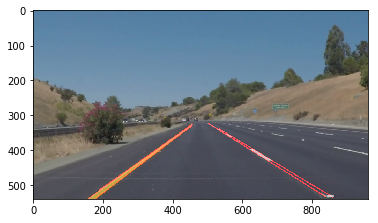

In [46]:
yellow_output = 'mysolidYellowLeft.mp4'
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)

%time yellow_clip.write_videofile(yellow_output, audio=False)

In [47]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

[0] is the line now!
[[253 686 630 432]]
[0] We have -ve slope here is -0.67374005305 (right line) avg: -0.67374005305
[1] is the line now!
[[281 685 629 432]]
[0] We have -ve slope here is -0.727011494253 (right line) avg: -0.727011494253
[2] is the line now!
[[ 663  427 1093  675]]
[1] We have +ve slope here is 0.576744186047 (left line) avg: 0.288372093023
[3] is the line now!
[[226 686 409 680]]
[1] We have -ve slope here is -0.0327868852459 (right line) avg: -0.379899189749
[4] is the line now!
[[ 573  669 1138  669]]
[5] is the line now!
[[ 964  677 1085  677]]
[6] is the line now!
[[ 913  580 1070  675]]
[2] We have +ve slope here is 0.605095541401 (left line) avg: 0.393946575816
[7] is the line now!
[[267 686 648 429]]
[2] We have -ve slope here is -0.674540682415 (right line) avg: -0.478113020638
[8] is the line now!
[[190 683 628 668]]
[3] We have -ve slope here is -0.0342465753425 (right line) avg: -0.367146409314
[9] is the line now!
[[ 629  668 1091  676]]
[3] We have +ve 

  0%|          | 0/251 [00:00<?, ?it/s]

[0] is the line now!
[[253 686 630 432]]
[0] We have -ve slope here is -0.67374005305 (right line) avg: -0.67374005305
[1] is the line now!
[[281 685 629 432]]
[0] We have -ve slope here is -0.727011494253 (right line) avg: -0.727011494253
[2] is the line now!
[[ 663  427 1093  675]]
[1] We have +ve slope here is 0.576744186047 (left line) avg: 0.288372093023
[3] is the line now!
[[226 686 409 680]]
[1] We have -ve slope here is -0.0327868852459 (right line) avg: -0.379899189749
[4] is the line now!
[[ 573  669 1138  669]]
[5] is the line now!
[[ 964  677 1085  677]]
[6] is the line now!
[[ 913  580 1070  675]]
[2] We have +ve slope here is 0.605095541401 (left line) avg: 0.393946575816
[7] is the line now!
[[267 686 648 429]]
[2] We have -ve slope here is -0.674540682415 (right line) avg: -0.478113020638
[8] is the line now!
[[190 683 628 668]]
[3] We have -ve slope here is -0.0342465753425 (right line) avg: -0.367146409314
[9] is the line now!
[[ 629  668 1091  676]]
[3] We have +ve 

  1%|          | 2/251 [00:00<00:15, 16.14it/s]

[1] We have -ve slope here is -0.0498614958449 (right line) avg: -0.374657523879
[4] is the line now!
[[ 653  428 1098  674]]
[1] We have +ve slope here is 0.552808988764 (left line) avg: 0.276404494382
[5] is the line now!
[[ 957  606 1075  677]]
[2] We have +ve slope here is 0.601694915254 (left line) avg: 0.384834634673
[6] is the line now!
[[ 999  677 1080  677]]
[7] is the line now!
[[360 613 643 429]]
[2] We have -ve slope here is -0.650176678445 (right line) avg: -0.466497242068
[8] is the line now!
[[281 684 645 429]]
[3] We have -ve slope here is -0.700549450549 (right line) avg: -0.525010294188
[9] is the line now!
[[ 663  426 1094  674]]
[3] We have +ve slope here is 0.575406032483 (left line) avg: 0.432477484125
[10] is the line now!
[[772 668 943 676]]
[4] We have +ve slope here is 0.046783625731 (left line) avg: 0.355338712446
[11] is the line now!
[[275 671 529 671]]
[12] is the line now!
[[809 668 979 676]]
[4] We have +ve slope here is 0.0470588235294 (left line) avg: 

  1%|          | 3/251 [00:00<00:19, 12.77it/s]

[0] is the line now!
[[250 685 643 430]]
[0] We have -ve slope here is -0.648854961832 (right line) avg: -0.648854961832
[1] is the line now!
[[560 669 840 669]]
[2] is the line now!
[[281 685 647 429]]
[0] We have -ve slope here is -0.699453551913 (right line) avg: -0.699453551913
[3] is the line now!
[[762 668 790 668]]
[4] is the line now!
[[ 974  677 1081  677]]
[5] is the line now!
[[278 685 614 450]]
[1] We have -ve slope here is -0.699404761905 (right line) avg: -0.699429156909
[6] is the line now!
[[227 686 407 680]]
[1] We have -ve slope here is -0.0333333333333 (right line) avg: -0.366381245121
[7] is the line now!
[[304 654 619 434]]
[2] We have -ve slope here is -0.698412698413 (right line) avg: -0.477058396218
[8] is the line now!
[[276 672 504 672]]
[9] is the line now!
[[201 684 704 667]]
[2] We have -ve slope here is -0.0337972166998 (right line) avg: -0.329304669712
[10] is the line now!
[[ 645  667 1096  675]]
[3] We have +ve slope here is 0.0177383592018 (left line) 

  2%|▏         | 5/251 [00:00<00:18, 13.14it/s]

[0] is the line now!
[[261 685 637 432]]
[0] We have -ve slope here is -0.672872340426 (right line) avg: -0.672872340426
[1] is the line now!
[[281 686 647 430]]
[0] We have -ve slope here is -0.699453551913 (right line) avg: -0.699453551913
[2] is the line now!
[[283 669 308 669]]
[3] is the line now!
[[579 669 823 669]]
[4] is the line now!
[[230 687 403 681]]
[1] We have -ve slope here is -0.0346820809249 (right line) avg: -0.367067816419
[5] is the line now!
[[ 942  677 1084  677]]
[6] is the line now!
[[273 676 733 668]]
[1] We have -ve slope here is -0.0173913043478 (right line) avg: -0.192229560383
[7] is the line now!
[[274 675 660 424]]
[2] We have -ve slope here is -0.650259067358 (right line) avg: -0.344906062708
[8] is the line now!
[[ 683  428 1069  678]]
[2] We have +ve slope here is 0.647668393782 (left line) avg: 0.215889464594
[9] is the line now!
[[ 907  705 1162  665]]
[3] We have -ve slope here is -0.156862745098 (right line) avg: -0.297895233306
[10] is the line no

  3%|▎         | 7/251 [00:00<00:17, 13.72it/s]


[2] is the line now!
[[588 668 815 668]]
[3] is the line now!
[[ 910  675 1094  675]]
[4] is the line now!
[[282 685 646 430]]
[1] We have -ve slope here is -0.700549450549 (right line) avg: -0.699205206558
[5] is the line now!
[[208 685 379 682]]
[1] We have -ve slope here is -0.0175438596491 (right line) avg: -0.358374533104
[6] is the line now!
[[ 989  677 1076  677]]
[7] is the line now!
[[276 674 729 667]]
[2] We have -ve slope here is -0.0154525386313 (right line) avg: -0.244067201613
[8] is the line now!
[[ 881  672 1110  672]]
[9] is the line now!
[[ 680  428 1078  676]]
[2] We have +ve slope here is 0.623115577889 (left line) avg: 0.20770519263
[10] is the line now!
[[279 672 503 672]]
[11] is the line now!
[[258 685 672 427]]
[3] We have -ve slope here is -0.623188405797 (right line) avg: -0.338847502659
[12] is the line now!
[[591 465 644 430]]
[3] We have -ve slope here is -0.660377358491 (right line) avg: -0.419229966617
[13] is the line now!
[[682 428 846 538]]
[4] We ha

  4%|▎         | 9/251 [00:00<00:17, 14.20it/s]

[[280 675 446 675]]
[5] is the line now!
[[230 686 411 679]]
[1] We have -ve slope here is -0.0386740331492 (right line) avg: -0.368784530387
[6] is the line now!
[[ 987  677 1079  677]]
[7] is the line now!
[[685 427 896 569]]
[1] We have +ve slope here is 0.672985781991 (left line) avg: 0.336492890995
[8] is the line now!
[[190 682 619 668]]
[2] We have -ve slope here is -0.032634032634 (right line) avg: -0.256734364469
[9] is the line now!
[[762 668 933 676]]
[2] We have +ve slope here is 0.046783625731 (left line) avg: 0.239923135907
[10] is the line now!
[[300 684 636 431]]
[3] We have -ve slope here is -0.752976190476 (right line) avg: -0.380794820971
[11] is the line now!
[[880 672 890 672]]
[12] is the line now!
[[549 491 662 428]]
[3] We have -ve slope here is -0.557522123894 (right line) avg: -0.424976646702
[13] is the line now!
[[ 669  428 1095  674]]
[4] We have +ve slope here is 0.577464788732 (left line) avg: 0.307431466472
[14] is the line now!
[[211 685 369 682]]
[4] W

  4%|▍         | 11/251 [00:00<00:16, 14.56it/s]

[[317 671 633 433]]
[9] We have -ve slope here is -0.753164556962 (right line) avg: -0.416542107899
[24] is the line now!
[[563 700 608 700]]
[0] is the line now!
[[299 684 644 424]]
[0] We have -ve slope here is -0.753623188406 (right line) avg: -0.753623188406
[1] is the line now!
[[272 685 645 424]]
[0] We have -ve slope here is -0.699731903485 (right line) avg: -0.699731903485
[2] is the line now!
[[296 669 583 669]]
[3] is the line now!
[[ 668  424 1072  676]]
[1] We have +ve slope here is 0.623762376238 (left line) avg: 0.311881188119
[4] is the line now!
[[ 656  424 1091  675]]
[1] We have +ve slope here is 0.577011494253 (left line) avg: 0.444446341186
[5] is the line now!
[[303 684 647 425]]
[2] We have -ve slope here is -0.752906976744 (right line) avg: -0.717456927905
[6] is the line now!
[[ 732  667 1040  677]]
[2] We have +ve slope here is 0.0324675324675 (left line) avg: 0.307120071613
[7] is the line now!
[[ 666  424 1070  676]]
[3] We have +ve slope here is 0.6237623762

  5%|▌         | 13/251 [00:00<00:15, 14.88it/s]

[0] is the line now!
[[342 652 645 424]]
[0] We have -ve slope here is -0.752475247525 (right line) avg: -0.752475247525
[1] is the line now!
[[646 667 741 667]]
[2] is the line now!
[[271 685 644 424]]
[0] We have -ve slope here is -0.699731903485 (right line) avg: -0.699731903485
[3] is the line now!
[[219 686 416 679]]
[1] We have -ve slope here is -0.0355329949239 (right line) avg: -0.367632449205
[4] is the line now!
[[ 921  676 1090  676]]
[5] is the line now!
[[ 677  428 1076  677]]
[1] We have +ve slope here is 0.624060150376 (left line) avg: 0.312030075188
[6] is the line now!
[[ 671  429 1096  674]]
[2] We have +ve slope here is 0.576470588235 (left line) avg: 0.40017691287
[7] is the line now!
[[ 795  668 1080  677]]
[2] We have +ve slope here is 0.0315789473684 (left line) avg: 0.27731092437
[8] is the line now!
[[546 492 666 428]]
[3] We have -ve slope here is -0.533333333333 (right line) avg: -0.409057670237
[9] is the line now!
[[243 686 575 669]]
[3] We have -ve slope h

  6%|▌         | 15/251 [00:01<00:17, 13.18it/s]

[0] is the line now!
[[297 685 634 431]]
[0] We have -ve slope here is -0.753709198813 (right line) avg: -0.753709198813
[1] is the line now!
[[295 669 842 669]]
[2] is the line now!
[[272 685 635 431]]
[0] We have -ve slope here is -0.699724517906 (right line) avg: -0.699724517906


  7%|▋         | 17/251 [00:01<00:16, 13.96it/s]

[3] is the line now!
[[ 974  677 1080  677]]
[4] is the line now!
[[751 668 779 668]]
[5] is the line now!
[[339 683 662 667]]
[1] We have -ve slope here is -0.0495356037152 (right line) avg: -0.374630060811
[6] is the line now!
[[221 686 544 670]]
[1] We have -ve slope here is -0.0495356037152 (right line) avg: -0.212082832263
[7] is the line now!
[[489 531 652 429]]
[2] We have -ve slope here is -0.625766871166 (right line) avg: -0.349977511897
[8] is the line now!
[[543 449 645 429]]
[2] We have -ve slope here is -0.196078431373 (right line) avg: -0.298677818389
[9] is the line now!
[[184 682 503 687]]
[3] We have +ve slope here is 0.0156739811912 (left line) avg: 0.00391849529781
[10] is the line now!
[[680 426 886 560]]
[3] We have +ve slope here is 0.650485436893 (left line) avg: 0.165560230697
[11] is the line now!
[[694 667 973 676]]
[4] We have +ve slope here is 0.0322580645161 (left line) avg: 0.138899797461
[12] is the line now!
[[241 686 653 429]]
[4] We have -ve slope here

  8%|▊         | 19/251 [00:01<00:16, 14.23it/s]

[0] is the line now!
[[300 684 643 426]]
[0] We have -ve slope here is -0.752186588921 (right line) avg: -0.752186588921
[1] is the line now!
[[271 685 641 426]]
[0] We have -ve slope here is -0.7 (right line) avg: -0.7
[2] is the line now!
[[602 668 791 668]]
[3] is the line now!
[[ 914  676 1092  676]]
[4] is the line now!
[[873 672 887 672]]
[5] is the line now!
[[294 684 651 425]]
[1] We have -ve slope here is -0.725490196078 (right line) avg: -0.712745098039
[6] is the line now!
[[270 685 593 669]]
[1] We have -ve slope here is -0.0495356037152 (right line) avg: -0.381140350877
[7] is the line now!
[[ 888  673 1140  673]]
[8] is the line now!
[[ 660  425 1093  675]]
[2] We have +ve slope here is 0.577367205543 (left line) avg: 0.192455735181
[9] is the line now!
[[371 682 571 669]]
[2] We have -ve slope here is -0.065 (right line) avg: -0.275760233918
[10] is the line now!
[[292 672 673 424]]
[3] We have -ve slope here is -0.650918635171 (right line) avg: -0.369549834231
[11] is t

  8%|▊         | 21/251 [00:01<00:15, 14.82it/s]

[2] We have +ve slope here is 0.0165289256198 (left line) avg: 0.00550964187328
[8] is the line now!
[[315 655 656 425]]
[2] We have -ve slope here is -0.674486803519 (right line) avg: -0.586438144763
[9] is the line now!
[[ 660  425 1094  675]]
[3] We have +ve slope here is 0.576036866359 (left line) avg: 0.148141447995
[10] is the line now!
[[252 686 402 681]]
[3] We have -ve slope here is -0.0333333333333 (right line) avg: -0.448161941906
[11] is the line now!
[[529 453 679 424]]
[4] We have -ve slope here is -0.193333333333 (right line) avg: -0.397196220191
[12] is the line now!
[[300 684 602 457]]
[4] We have -ve slope here is -0.751655629139 (right line) avg: -0.468088101981
[13] is the line now!
[[568 477 680 427]]
[5] We have -ve slope here is -0.446428571429 (right line) avg: -0.464478180222
[14] is the line now!
[[682 424 871 556]]
[5] We have +ve slope here is 0.698412698413 (left line) avg: 0.239853323064
[15] is the line now!
[[706 668 734 668]]
[16] is the line now!
[[273

  9%|▉         | 23/251 [00:01<00:18, 12.18it/s]

[0] is the line now!
[[270 684 629 433]]
[0] We have -ve slope here is -0.699164345404 (right line) avg: -0.699164345404
[1] is the line now!
[[297 684 643 424]]
[0] We have -ve slope here is -0.751445086705 (right line) avg: -0.751445086705
[2] is the line now!
[[585 668 810 668]]
[3] is the line now!
[[ 656  425 1090  676]]
[1] We have +ve slope here is 0.578341013825 (left line) avg: 0.289170506912
[4] is the line now!
[[204 684 387 681]]
[1] We have -ve slope here is -0.016393442623 (right line) avg: -0.383919264664
[5] is the line now!
[[ 652  426 1071  677]]
[2] We have +ve slope here is 0.599045346062 (left line) avg: 0.392462119962
[6] is the line now!
[[ 907  675 1095  675]]
[7] is the line now!
[[ 916  676 1089  676]]
[8] is the line now!
[[287 674 731 667]]
[2] We have -ve slope here is -0.0157657657658 (right line) avg: -0.261201431698
[9] is the line now!
[[271 684 655 425]]
[3] We have -ve slope here is -0.674479166667 (right line) avg: -0.36452086544
[10] is the line now

 10%|▉         | 25/251 [00:01<00:17, 13.15it/s]

[0] is the line now!
[[599 667 786 667]]
[1] is the line now!
[[270 684 640 425]]
[0] We have -ve slope here is -0.7 (right line) avg: -0.7
[2] is the line now!
[[295 684 640 424]]
[0] We have -ve slope here is -0.753623188406 (right line) avg: -0.753623188406
[3] is the line now!
[[ 664  425 1052  667]]
[1] We have +ve slope here is 0.623711340206 (left line) avg: 0.311855670103
[4] is the line now!
[[ 944  676 1088  676]]
[5] is the line now!
[[299 683 643 424]]
[1] We have -ve slope here is -0.752906976744 (right line) avg: -0.753265082575
[6] is the line now!
[[220 685 539 669]]
[2] We have -ve slope here is -0.0501567398119 (right line) avg: -0.518895634987
[7] is the line now!
[[ 670  424 1065  661]]
[2] We have +ve slope here is 0.6 (left line) avg: 0.407903780069
[8] is the line now!
[[ 679  424 1066  675]]
[3] We have +ve slope here is 0.64857881137 (left line) avg: 0.468072537894
[9] is the line now!
[[217 684 341 682]]
[3] We have -ve slope here is -0.0161290322581 (right li

 11%|█         | 27/251 [00:01<00:15, 14.01it/s]

[0] is the line now!
[[628 667 766 667]]
[1] is the line now!
[[297 684 641 425]]
[0] We have -ve slope here is -0.752906976744 (right line) avg: -0.752906976744
[2] is the line now!
[[271 685 628 426]]
[0] We have -ve slope here is -0.725490196078 (right line) avg: -0.725490196078
[3] is the line now!
[[235 686 393 681]]
[1] We have -ve slope here is -0.0316455696203 (right line) avg: -0.378567882849
[4] is the line now!
[[259 685 645 424]]
[1] We have -ve slope here is -0.676165803109 (right line) avg: -0.527366842979
[5] is the line now!
[[ 930  676 1086  676]]
[6] is the line now!
[[294 685 640 424]]
[2] We have -ve slope here is -0.754335260116 (right line) avg: -0.603022982025
[7] is the line now!
[[515 510 670 424]]
[2] We have -ve slope here is -0.554838709677 (right line) avg: -0.586961557909
[8] is the line now!
[[187 682 615 668]]
[3] We have -ve slope here is -0.0327102803738 (right line) avg: -0.448398738525
[9] is the line now!
[[ 773  668 1055  677]]
[3] We have +ve slop

 12%|█▏        | 29/251 [00:02<00:14, 14.83it/s]

[0] is the line now!
[[588 668 821 668]]
[1] is the line now!
[[285 685 643 425]]
[0] We have -ve slope here is -0.72625698324 (right line) avg: -0.72625698324
[2] is the line now!
[[266 685 638 425]]
[0] We have -ve slope here is -0.698924731183 (right line) avg: -0.698924731183
[3] is the line now!
[[ 996  677 1075  677]]
[4] is the line now!
[[299 682 627 426]]
[1] We have -ve slope here is -0.780487804878 (right line) avg: -0.73970626803
[5] is the line now!
[[324 683 519 670]]
[1] We have -ve slope here is -0.0666666666667 (right line) avg: -0.403186467349
[6] is the line now!
[[508 514 670 424]]
[2] We have -ve slope here is -0.555555555556 (right line) avg: -0.453976163418
[7] is the line now!
[[256 685 642 425]]
[2] We have -ve slope here is -0.673575129534 (right line) avg: -0.52717581879
[8] is the line now!
[[683 667 968 676]]
[3] We have +ve slope here is 0.0315789473684 (left line) avg: 0.00789473684211
[9] is the line now!
[[367 682 566 669]]
[3] We have -ve slope here is

 12%|█▏        | 31/251 [00:02<00:14, 15.12it/s]

[0] is the line now!
[[264 684 636 424]]
[0] We have -ve slope here is -0.698924731183 (right line) avg: -0.698924731183
[1] is the line now!
[[284 685 640 427]]
[0] We have -ve slope here is -0.724719101124 (right line) avg: -0.724719101124
[2] is the line now!
[[625 667 765 667]]
[3] is the line now!
[[ 998  677 1078  677]]
[4] is the line now!
[[290 684 645 426]]
[1] We have -ve slope here is -0.72676056338 (right line) avg: -0.725739832252
[5] is the line now!
[[273 685 615 668]]
[1] We have -ve slope here is -0.0497076023392 (right line) avg: -0.387723717296
[6] is the line now!
[[235 685 577 668]]
[2] We have -ve slope here is -0.0497076023392 (right line) avg: -0.275051678977
[7] is the line now!
[[443 569 639 426]]
[2] We have -ve slope here is -0.729591836735 (right line) avg: -0.426565064896
[8] is the line now!
[[521 456 667 425]]
[3] We have -ve slope here is -0.212328767123 (right line) avg: -0.373005990453
[9] is the line now!
[[672 425 886 559]]
[3] We have +ve slope her

 13%|█▎        | 33/251 [00:02<00:14, 15.32it/s]


[20] is the line now!
[[684 424 848 543]]
[9] We have +ve slope here is 0.725609756098 (left line) avg: 0.285710567067
[21] is the line now!
[[563 699 585 699]]
[22] is the line now!
[[520 507 683 424]]
[9] We have -ve slope here is -0.509202453988 (right line) avg: -0.457895424987
[23] is the line now!
[[204 684 387 681]]
[10] We have -ve slope here is -0.016393442623 (right line) avg: -0.417758881136
[0] is the line now!
[[264 684 636 424]]
[0] We have -ve slope here is -0.698924731183 (right line) avg: -0.698924731183
[1] is the line now!
[[284 685 639 427]]
[0] We have -ve slope here is -0.72676056338 (right line) avg: -0.72676056338
[2] is the line now!
[[1124  669 1137  669]]
[3] is the line now!
[[629 667 756 667]]
[4] is the line now!
[[229 686 412 679]]
[1] We have -ve slope here is -0.0382513661202 (right line) avg: -0.38250596475
[5] is the line now!
[[ 908  675 1057  677]]
[1] We have +ve slope here is 0.0134228187919 (left line) avg: 0.00671140939597
[6] is the line now!


 14%|█▍        | 35/251 [00:02<00:14, 15.35it/s]


[[ 666  426 1017  636]]
[1] We have +ve slope here is 0.598290598291 (left line) avg: 0.455005648272
[5] is the line now!
[[250 686 401 681]]
[2] We have -ve slope here is -0.0331125827815 (right line) avg: -0.4612093489
[6] is the line now!
[[ 946  677 1083  677]]
[7] is the line now!
[[ 611  668 1091  676]]
[2] We have +ve slope here is 0.0166666666667 (left line) avg: 0.308892654404
[8] is the line now!
[[360 629 647 428]]
[3] We have -ve slope here is -0.700348432056 (right line) avg: -0.520994119689
[9] is the line now!
[[309 667 651 427]]
[3] We have -ve slope here is -0.701754385965 (right line) avg: -0.566184186258
[10] is the line now!
[[261 685 633 425]]
[4] We have -ve slope here is -0.698924731183 (right line) avg: -0.592732295243
[11] is the line now!
[[234 686 557 670]]
[4] We have -ve slope here is -0.0495356037152 (right line) avg: -0.484092956937
[12] is the line now!
[[396 564 682 425]]
[5] We have -ve slope here is -0.486013986014 (right line) avg: -0.48441312845
[1

 15%|█▍        | 37/251 [00:02<00:14, 15.11it/s]

[12] is the line now!
[[261 685 635 424]]
[4] We have -ve slope here is -0.697860962567 (right line) avg: -0.542175042656
[13] is the line now!
[[272 685 655 427]]
[4] We have -ve slope here is -0.67362924282 (right line) avg: -0.568465882689
[14] is the line now!
[[274 673 482 673]]
[15] is the line now!
[[564 699 603 700]]
[5] We have +ve slope here is 0.025641025641 (left line) avg: 0.259842145872
[16] is the line now!
[[253 685 668 426]]
[5] We have -ve slope here is -0.624096385542 (right line) avg: -0.577737633164
[17] is the line now!
[[236 686 652 427]]
[6] We have -ve slope here is -0.622596153846 (right line) avg: -0.584145993262
[18] is the line now!
[[ 606  668 1070  716]]
[6] We have +ve slope here is 0.103448275862 (left line) avg: 0.237500164442
[19] is the line now!
[[804 668 932 676]]
[7] We have +ve slope here is 0.0625 (left line) avg: 0.215625143886
[20] is the line now!
[[671 426 988 632]]
[7] We have +ve slope here is 0.649842271293 (left line) avg: 0.269902284812

 16%|█▌        | 39/251 [00:02<00:13, 15.60it/s]

[0] is the line now!
[[287 682 638 427]]
[0] We have -ve slope here is -0.726495726496 (right line) avg: -0.726495726496
[1] is the line now!
[[607 668 767 668]]
[2] is the line now!
[[259 686 633 424]]
[0] We have -ve slope here is -0.700534759358 (right line) avg: -0.700534759358
[3] is the line now!
[[260 686 598 669]]
[1] We have -ve slope here is -0.0502958579882 (right line) avg: -0.375415308673
[4] is the line now!
[[ 902  675 1075  678]]
[1] We have +ve slope here is 0.0173410404624 (left line) avg: 0.00867052023121
[5] is the line now!
[[276 671 541 671]]
[6] is the line now!
[[478 534 675 425]]
[2] We have -ve slope here is -0.553299492386 (right line) avg: -0.434710036577
[7] is the line now!
[[255 685 319 643]]
[2] We have -ve slope here is -0.65625 (right line) avg: -0.508556691052
[8] is the line now!
[[ 813  669 1000  678]]
[3] We have +ve slope here is 0.048128342246 (left line) avg: 0.0185349757349
[9] is the line now!
[[513 512 670 425]]
[3] We have -ve slope here is 

 16%|█▋        | 41/251 [00:02<00:13, 15.75it/s]

[0] is the line now!
[[282 685 637 428]]
[0] We have -ve slope here is -0.723943661972 (right line) avg: -0.723943661972
[1] is the line now!
[[258 685 631 424]]
[0] We have -ve slope here is -0.699731903485 (right line) avg: -0.699731903485
[2] is the line now!
[[1135  669 1141  669]]
[3] is the line now!
[[247 686 646 427]]
[1] We have -ve slope here is -0.649122807018 (right line) avg: -0.674427355251
[4] is the line now!
[[611 668 771 668]]
[5] is the line now!
[[ 902  675 1075  678]]
[1] We have +ve slope here is 0.0173410404624 (left line) avg: 0.00867052023121
[6] is the line now!
[[262 683 658 426]]
[2] We have -ve slope here is -0.64898989899 (right line) avg: -0.665948203164
[7] is the line now!
[[227 686 550 670]]
[2] We have -ve slope here is -0.0495356037152 (right line) avg: -0.460477336681
[8] is the line now!
[[206 685 401 681]]
[3] We have -ve slope here is -0.0205128205128 (right line) avg: -0.350486207639
[9] is the line now!
[[581 471 680 429]]
[3] We have -ve slope

 17%|█▋        | 43/251 [00:02<00:13, 15.82it/s]

[5] We have -ve slope here is -0.261904761905 (right line) avg: -0.329598002348
[13] is the line now!
[[273 686 657 427]]
[5] We have -ve slope here is -0.674479166667 (right line) avg: -0.387078196401
[14] is the line now!
[[586 427 703 427]]
[15] is the line now!
[[1127  669 1140  669]]
[16] is the line now!
[[586 441 697 434]]
[6] We have -ve slope here is -0.0630630630631 (right line) avg: -0.34079032021
[17] is the line now!
[[ 787  669 1064  660]]
[6] We have -ve slope here is -0.0324909747292 (right line) avg: -0.29674755657
[18] is the line now!
[[592 431 685 425]]
[7] We have -ve slope here is -0.0645161290323 (right line) avg: -0.267718628128
[19] is the line now!
[[ 924  701 1254  718]]
[7] We have +ve slope here is 0.0515151515152 (left line) avg: 0.227400954818
[20] is the line now!
[[183 682 575 669]]
[8] We have -ve slope here is -0.0331632653061 (right line) avg: -0.241656921148
[21] is the line now!
[[546 493 660 432]]
[8] We have -ve slope here is -0.535087719298 (rig

 18%|█▊        | 45/251 [00:03<00:15, 13.49it/s]


[24] is the line now!
[[254 685 660 432]]
[9] We have -ve slope here is -0.62315270936 (right line) avg: -0.376924241588
[25] is the line now!
[[589 432 676 426]]
[10] We have -ve slope here is -0.0689655172414 (right line) avg: -0.34892799392
[0] is the line now!
[[283 686 653 427]]
[0] We have -ve slope here is -0.7 (right line) avg: -0.7
[1] is the line now!
[[261 685 641 429]]
[0] We have -ve slope here is -0.673684210526 (right line) avg: -0.673684210526
[2] is the line now!
[[580 669 825 669]]
[3] is the line now!
[[ 663  427 1094  675]]
[1] We have +ve slope here is 0.575406032483 (left line) avg: 0.287703016241
[4] is the line now!
[[ 654  427 1073  678]]
[1] We have +ve slope here is 0.599045346062 (left line) avg: 0.443374181152
[5] is the line now!
[[222 686 410 680]]
[2] We have -ve slope here is -0.031914893617 (right line) avg: -0.45976110489
[6] is the line now!
[[ 902  675 1152  675]]
[7] is the line now!
[[ 628  668 1092  676]]
[2] We have +ve slope here is 0.01724137

 19%|█▊        | 47/251 [00:03<00:14, 13.75it/s]

[0] is the line now!
[[314 667 644 428]]
[0] We have -ve slope here is -0.724242424242 (right line) avg: -0.724242424242
[1] is the line now!
[[262 685 641 429]]
[0] We have -ve slope here is -0.675461741425 (right line) avg: -0.675461741425
[2] is the line now!
[[564 669 838 669]]
[3] is the line now!
[[ 662  427 1093  675]]
[1] We have +ve slope here is 0.575406032483 (left line) avg: 0.287703016241
[4] is the line now!
[[ 651  424 1073  677]]
[1] We have +ve slope here is 0.599526066351 (left line) avg: 0.443614541296
[5] is the line now!
[[232 686 407 680]]
[2] We have -ve slope here is -0.0342857142857 (right line) avg: -0.461736399045
[6] is the line now!
[[ 691  667 1005  677]]
[2] We have +ve slope here is 0.031847133758 (left line) avg: 0.306358738783
[7] is the line now!
[[289 668 652 424]]
[3] We have -ve slope here is -0.67217630854 (right line) avg: -0.514346376419
[8] is the line now!
[[546 501 653 424]]
[3] We have -ve slope here is -0.719626168224 (right line) avg: -0.5

 20%|█▉        | 49/251 [00:03<00:14, 13.94it/s]

[0] We have -ve slope here is -0.672680412371 (right line) avg: -0.672680412371
[1] is the line now!
[[293 683 632 437]]
[0] We have -ve slope here is -0.725663716814 (right line) avg: -0.725663716814
[2] is the line now!
[[614 668 773 668]]
[3] is the line now!
[[ 663  427 1092  675]]
[1] We have +ve slope here is 0.578088578089 (left line) avg: 0.289044289044
[4] is the line now!
[[ 652  424 1073  677]]
[1] We have +ve slope here is 0.600950118765 (left line) avg: 0.444997203905
[5] is the line now!
[[257 686 599 669]]
[2] We have -ve slope here is -0.0497076023392 (right line) avg: -0.500345011989
[6] is the line now!
[[ 947  677 1087  677]]
[7] is the line now!
[[ 856  671 1129  671]]
[8] is the line now!
[[374 682 574 669]]
[2] We have -ve slope here is -0.065 (right line) avg: -0.355230007993
[9] is the line now!
[[510 525 655 427]]
[3] We have -ve slope here is -0.675862068966 (right line) avg: -0.435388023236
[10] is the line now!
[[572 429 684 429]]
[11] is the line now!
[[266

 20%|██        | 51/251 [00:03<00:13, 14.41it/s]


[[272 686 639 429]]
[1] We have -ve slope here is -0.700272479564 (right line) avg: -0.713130590065
[5] is the line now!
[[231 686 573 669]]
[1] We have -ve slope here is -0.0497076023392 (right line) avg: -0.381419096202
[6] is the line now!
[[294 685 649 428]]
[2] We have -ve slope here is -0.723943661972 (right line) avg: -0.495593951459
[7] is the line now!
[[872 672 884 672]]
[8] is the line now!
[[279 686 663 427]]
[2] We have -ve slope here is -0.674479166667 (right line) avg: -0.555222356528
[9] is the line now!
[[572 429 683 429]]
[10] is the line now!
[[204 685 384 682]]
[3] We have -ve slope here is -0.0166666666667 (right line) avg: -0.420583434063
[11] is the line now!
[[ 905  715 1091  715]]
[12] is the line now!
[[390 600 645 428]]
[3] We have -ve slope here is -0.674509803922 (right line) avg: -0.484065026527
[13] is the line now!
[[562 447 707 437]]
[4] We have -ve slope here is -0.0689655172414 (right line) avg: -0.40104512467
[14] is the line now!
[[ 910  717 1256  

 21%|██        | 53/251 [00:03<00:13, 14.84it/s]


[[610 442 722 438]]
[6] We have -ve slope here is -0.0357142857143 (right line) avg: -0.36566014001
[18] is the line now!
[[819 669 932 676]]
[7] We have +ve slope here is 0.0619469026549 (left line) avg: 0.21281147329
[19] is the line now!
[[ 738  692 1063  709]]
[7] We have +ve slope here is 0.0523076923077 (left line) avg: 0.192748500667
[20] is the line now!
[[264 685 646 428]]
[8] We have -ve slope here is -0.67277486911 (right line) avg: -0.399783998799
[21] is the line now!
[[555 448 674 438]]
[8] We have -ve slope here is -0.0840336134454 (right line) avg: -0.364700622648
[22] is the line now!
[[1047  678 1173  665]]
[9] We have -ve slope here is -0.103174603175 (right line) avg: -0.338548020701
[23] is the line now!
[[340 683 636 426]]
[9] We have -ve slope here is -0.868243243243 (right line) avg: -0.391517542955
[24] is the line now!
[[337 683 522 671]]
[10] We have -ve slope here is -0.0648648648649 (right line) avg: -0.361821844947
[25] is the line now!
[[424 589 655 427]

 22%|██▏       | 55/251 [00:03<00:12, 15.26it/s]

[0] is the line now!
[[272 683 636 429]]
[0] We have -ve slope here is -0.697802197802 (right line) avg: -0.697802197802
[1] is the line now!
[[586 668 796 668]]
[2] is the line now!
[[293 684 646 428]]
[0] We have -ve slope here is -0.725212464589 (right line) avg: -0.725212464589
[3] is the line now!
[[218 685 359 682]]
[1] We have -ve slope here is -0.0212765957447 (right line) avg: -0.373244530167
[4] is the line now!
[[ 903  675 1066  678]]
[1] We have +ve slope here is 0.0184049079755 (left line) avg: 0.00920245398773
[5] is the line now!
[[291 684 643 429]]
[2] We have -ve slope here is -0.724431818182 (right line) avg: -0.490306959505
[6] is the line now!
[[ 701  439 1068  677]]
[2] We have +ve slope here is 0.648501362398 (left line) avg: 0.222302090124
[7] is the line now!
[[ 856  671 1128  671]]
[8] is the line now!
[[369 681 482 672]]
[3] We have -ve slope here is -0.0796460176991 (right line) avg: -0.387641724054
[9] is the line now!
[[513 459 689 428]]
[3] We have -ve slo

 23%|██▎       | 57/251 [00:03<00:14, 13.49it/s]

[0] is the line now!
[[270 685 636 429]]
[0] We have -ve slope here is -0.699453551913 (right line) avg: -0.699453551913
[1] is the line now!
[[296 685 635 429]]
[0] We have -ve slope here is -0.755162241888 (right line) avg: -0.755162241888
[2] is the line now!
[[595 668 790 668]]
[3] is the line now!
[[286 675 450 675]]
[4] is the line now!
[[ 663  426 1065  677]]
[1] We have +ve slope here is 0.624378109453 (left line) avg: 0.312189054726
[5] is the line now!
[[ 661  427 1091  675]]
[1] We have +ve slope here is 0.576744186047 (left line) avg: 0.444466620386
[6] is the line now!
[[ 914  676 1090  676]]
[7] is the line now!
[[272 685 654 427]]
[2] We have -ve slope here is -0.675392670157 (right line) avg: -0.728572384644
[8] is the line now!
[[343 683 542 670]]
[2] We have -ve slope here is -0.0653266331658 (right line) avg: -0.507490467485
[9] is the line now!
[[612 441 727 439]]
[3] We have -ve slope here is -0.0173913043478 (right line) avg: -0.384965676701
[10] is the line now!


 24%|██▎       | 59/251 [00:04<00:13, 13.76it/s]

[0] is the line now!
[[271 685 638 428]]
[0] We have -ve slope here is -0.700272479564 (right line) avg: -0.700272479564
[1] is the line now!
[[293 685 633 429]]
[0] We have -ve slope here is -0.752941176471 (right line) avg: -0.752941176471
[2] is the line now!
[[596 668 788 668]]
[3] is the line now!
[[259 685 659 426]]
[1] We have -ve slope here is -0.6475 (right line) avg: -0.700220588235
[4] is the line now!
[[264 685 664 426]]
[1] We have -ve slope here is -0.6475 (right line) avg: -0.673860294118
[5] is the line now!
[[ 906  675 1097  675]]
[6] is the line now!
[[652 427 674 440]]
[2] We have +ve slope here is 0.590909090909 (left line) avg: 0.19696969697
[7] is the line now!
[[ 666  430 1091  676]]
[2] We have +ve slope here is 0.578823529412 (left line) avg: 0.324254307784
[8] is the line now!
[[ 964  614 1069  677]]
[3] We have +ve slope here is 0.6 (left line) avg: 0.393190730838
[9] is the line now!
[[262 685 643 428]]
[3] We have -ve slope here is -0.674540682415 (right li

 24%|██▍       | 61/251 [00:04<00:13, 14.21it/s]

[[605 668 758 668]]
[6] is the line now!
[[ 663  425 1058  671]]
[2] We have +ve slope here is 0.622784810127 (left line) avg: 0.207594936709
[7] is the line now!
[[ 678  429 1087  674]]
[2] We have +ve slope here is 0.59902200489 (left line) avg: 0.338070626103
[8] is the line now!
[[ 943  677 1086  677]]
[9] is the line now!
[[341 633 660 426]]
[3] We have -ve slope here is -0.648902821317 (right line) avg: -0.321247131904
[10] is the line now!
[[823 669 937 676]]
[3] We have +ve slope here is 0.0614035087719 (left line) avg: 0.26890384677
[11] is the line now!
[[186 682 317 612]]
[4] We have -ve slope here is -0.534351145038 (right line) avg: -0.363867934531
[12] is the line now!
[[573 429 707 429]]
[13] is the line now!
[[522 459 642 434]]
[4] We have -ve slope here is -0.208333333333 (right line) avg: -0.332761014291
[14] is the line now!
[[252 686 653 426]]
[5] We have -ve slope here is -0.648379052369 (right line) avg: -0.385364020637
[15] is the line now!
[[ 686  428 1071  678]

 25%|██▌       | 63/251 [00:04<00:13, 14.34it/s]


[1] is the line now!
[[265 685 631 429]]
[0] We have -ve slope here is -0.699453551913 (right line) avg: -0.699453551913
[2] is the line now!
[[570 669 836 669]]
[3] is the line now!
[[279 676 441 676]]
[4] is the line now!
[[218 686 409 680]]
[1] We have -ve slope here is -0.0314136125654 (right line) avg: -0.365433582239
[5] is the line now!
[[ 914  676 1087  676]]
[6] is the line now!
[[285 672 512 672]]
[7] is the line now!
[[ 672  667 1152  675]]
[1] We have +ve slope here is 0.0166666666667 (left line) avg: 0.00833333333333
[8] is the line now!
[[475 539 663 430]]
[2] We have -ve slope here is -0.579787234043 (right line) avg: -0.436884799507
[9] is the line now!
[[286 685 641 427]]
[2] We have -ve slope here is -0.72676056338 (right line) avg: -0.533510054131
[10] is the line now!
[[ 685  425 1060  677]]
[3] We have +ve slope here is 0.672 (left line) avg: 0.17425
[11] is the line now!
[[517 512 655 432]]
[3] We have -ve slope here is -0.579710144928 (right line) avg: -0.545060

 26%|██▌       | 65/251 [00:04<00:13, 14.25it/s]

[12] is the line now!
[[286 685 581 471]]
[5] We have -ve slope here is -0.725423728814 (right line) avg: -0.481944675868
[13] is the line now!
[[ 895  673 1083  676]]
[5] We have +ve slope here is 0.0159574468085 (left line) avg: 0.01565502606
[14] is the line now!
[[595 444 710 440]]
[6] We have -ve slope here is -0.0347826086957 (right line) avg: -0.418064380558
[15] is the line now!
[[691 424 815 517]]
[6] We have +ve slope here is 0.75 (left line) avg: 0.120561450909
[16] is the line now!
[[210 685 504 685]]
[17] is the line now!
[[572 429 667 429]]
[18] is the line now!
[[1009  676 1131  670]]
[7] We have -ve slope here is -0.0491803278689 (right line) avg: -0.371953873972
[19] is the line now!
[[287 668 662 424]]
[7] We have -ve slope here is -0.650666666667 (right line) avg: -0.406792973059
[20] is the line now!
[[575 699 603 699]]
[21] is the line now!
[[687 428 914 575]]
[8] We have +ve slope here is 0.647577092511 (left line) avg: 0.17911874442
[22] is the line now!
[[592 42

 27%|██▋       | 67/251 [00:04<00:12, 14.75it/s]

[7] We have +ve slope here is 0.0315789473684 (left line) avg: 0.25804046858
[22] is the line now!
[[682 425 889 554]]
[8] We have +ve slope here is 0.623188405797 (left line) avg: 0.298612461604
[23] is the line now!
[[327 656 662 430]]
[8] We have -ve slope here is -0.674626865672 (right line) avg: -0.424496320595
[24] is the line now!
[[517 457 696 425]]
[9] We have -ve slope here is -0.178770949721 (right line) avg: -0.399923783507
[0] is the line now!
[[266 685 647 428]]
[0] We have -ve slope here is -0.674540682415 (right line) avg: -0.674540682415
[1] is the line now!
[[297 681 646 428]]
[0] We have -ve slope here is -0.724928366762 (right line) avg: -0.724928366762
[2] is the line now!
[[ 959  677 1082  677]]
[3] is the line now!
[[227 686 568 669]]
[1] We have -ve slope here is -0.049853372434 (right line) avg: -0.387390869598
[4] is the line now!
[[605 668 787 668]]
[5] is the line now!
[[686 431 907 574]]
[1] We have +ve slope here is 0.647058823529 (left line) avg: 0.323529

 27%|██▋       | 69/251 [00:04<00:11, 15.18it/s]

[0] is the line now!
[[296 684 649 428]]
[0] We have -ve slope here is -0.725212464589 (right line) avg: -0.725212464589
[1] is the line now!
[[267 685 648 428]]
[0] We have -ve slope here is -0.674540682415 (right line) avg: -0.674540682415
[2] is the line now!
[[601 668 789 668]]
[3] is the line now!
[[284 676 435 676]]
[4] is the line now!
[[ 677  431 1099  674]]
[1] We have +ve slope here is 0.575829383886 (left line) avg: 0.287914691943
[5] is the line now!
[[ 957  677 1082  677]]
[6] is the line now!
[[211 685 375 682]]
[1] We have -ve slope here is -0.0182926829268 (right line) avg: -0.346416682671
[7] is the line now!
[[ 672  431 1005  631]]
[2] We have +ve slope here is 0.600600600601 (left line) avg: 0.392143328162
[8] is the line now!
[[ 872  672 1132  672]]
[9] is the line now!
[[569 431 711 431]]
[10] is the line now!
[[586 448 739 445]]
[2] We have -ve slope here is -0.0196078431373 (right line) avg: -0.237480402826
[11] is the line now!
[[265 685 654 433]]
[3] We have -v

 28%|██▊       | 71/251 [00:04<00:11, 15.26it/s]


[[677 427 825 512]]
[5] We have +ve slope here is 0.574324324324 (left line) avg: 0.416366199903
[13] is the line now!
[[579 450 721 445]]
[5] We have -ve slope here is -0.0352112676056 (right line) avg: -0.504959819231
[14] is the line now!
[[573 432 713 432]]
[15] is the line now!
[[ 663  667 1166  676]]
[6] We have +ve slope here is 0.0178926441352 (left line) avg: 0.359441406222
[16] is the line now!
[[298 685 655 426]]
[6] We have -ve slope here is -0.725490196078 (right line) avg: -0.536464158781
[17] is the line now!
[[ 669  431 1010  620]]
[7] We have +ve slope here is 0.554252199413 (left line) avg: 0.383792755371
[18] is the line now!
[[526 461 694 426]]
[7] We have -ve slope here is -0.208333333333 (right line) avg: -0.4954478056
[19] is the line now!
[[464 564 592 468]]
[8] We have -ve slope here is -0.75 (right line) avg: -0.523731382756
[20] is the line now!
[[ 652  434 1102  673]]
[8] We have +ve slope here is 0.531111111111 (left line) avg: 0.400161461564
[21] is the l

 29%|██▉       | 73/251 [00:05<00:11, 15.17it/s]


[2] We have +ve slope here is 0.0315789473684 (left line) avg: 0.302482880367
[8] is the line now!
[[285 682 655 433]]
[2] We have -ve slope here is -0.672972972973 (right line) avg: -0.691904233
[9] is the line now!
[[223 686 565 669]]
[3] We have -ve slope here is -0.0497076023392 (right line) avg: -0.531355075335
[10] is the line now!
[[281 684 645 429]]
[3] We have -ve slope here is -0.700549450549 (right line) avg: -0.573653669139
[11] is the line now!
[[568 431 629 431]]
[12] is the line now!
[[574 452 739 447]]
[4] We have -ve slope here is -0.030303030303 (right line) avg: -0.464983541371
[13] is the line now!
[[312 680 647 428]]
[4] We have -ve slope here is -0.75223880597 (right line) avg: -0.522434594291
[14] is the line now!
[[301 685 642 668]]
[5] We have -ve slope here is -0.049853372434 (right line) avg: -0.443671057315
[15] is the line now!
[[497 467 694 426]]
[5] We have -ve slope here is -0.208121827411 (right line) avg: -0.404412852331
[16] is the line now!
[[548 44

 30%|██▉       | 75/251 [00:05<00:12, 14.50it/s]

[0] is the line now!
[[308 684 650 426]]
[0] We have -ve slope here is -0.754385964912 (right line) avg: -0.754385964912
[1] is the line now!
[[283 684 650 427]]
[0] We have -ve slope here is -0.700272479564 (right line) avg: -0.700272479564
[2] is the line now!
[[1138  668 1145  668]]
[3] is the line now!
[[ 967  677 1082  677]]
[4] is the line now!
[[592 668 802 668]]
[5] is the line now!
[[303 671 527 671]]
[6] is the line now!
[[501 471 678 427]]
[1] We have -ve slope here is -0.248587570621 (right line) avg: -0.474430025093
[7] is the line now!
[[204 684 502 684]]
[8] is the line now!
[[568 432 685 432]]
[9] is the line now!
[[ 874  672 1161  672]]
[10] is the line now!
[[573 452 743 449]]
[1] We have -ve slope here is -0.0176470588235 (right line) avg: -0.246038541958
[11] is the line now!
[[285 683 656 433]]
[2] We have -ve slope here is -0.673854447439 (right line) avg: -0.388643843785
[12] is the line now!
[[361 682 485 672]]
[2] We have -ve slope here is -0.0806451612903 (rig

 31%|███       | 77/251 [00:05<00:12, 13.65it/s]

[0] is the line now!
[[313 684 641 437]]
[0] We have -ve slope here is -0.753048780488 (right line) avg: -0.753048780488
[1] is the line now!
[[287 685 647 424]]
[0] We have -ve slope here is -0.725 (right line) avg: -0.725
[2] is the line now!
[[1139  668 1146  668]]
[3] is the line now!
[[284 685 637 438]]
[1] We have -ve slope here is -0.699716713881 (right line) avg: -0.712358356941
[4] is the line now!
[[ 956  677 1082  677]]
[5] is the line now!
[[608 668 782 668]]
[6] is the line now!
[[231 686 574 669]]
[1] We have -ve slope here is -0.0495626822157 (right line) avg: -0.380960519578
[7] is the line now!
[[667 430 880 543]]
[2] We have +ve slope here is 0.530516431925 (left line) avg: 0.176838810642
[8] is the line now!
[[283 685 655 434]]
[2] We have -ve slope here is -0.674731182796 (right line) avg: -0.478884073984
[9] is the line now!
[[351 683 400 681]]
[3] We have -ve slope here is -0.0408163265306 (right line) avg: -0.369367137121
[10] is the line now!
[[ 675  428 1088  6

 31%|███▏      | 79/251 [00:05<00:12, 13.84it/s]

[0] is the line now!
[[339 667 644 429]]
[0] We have -ve slope here is -0.780327868852 (right line) avg: -0.780327868852
[1] is the line now!
[[612 668 780 668]]
[2] is the line now!
[[283 685 637 437]]
[0] We have -ve slope here is -0.700564971751 (right line) avg: -0.700564971751
[3] is the line now!
[[ 953  677 1082  677]]
[4] is the line now!
[[239 686 581 669]]
[1] We have -ve slope here is -0.0497076023392 (right line) avg: -0.375136287045
[5] is the line now!
[[288 685 646 435]]
[1] We have -ve slope here is -0.698324022346 (right line) avg: -0.536730154696
[6] is the line now!
[[281 685 654 434]]
[2] We have -ve slope here is -0.672922252011 (right line) avg: -0.582127520467
[7] is the line now!
[[667 429 874 539]]
[2] We have +ve slope here is 0.531400966184 (left line) avg: 0.177133655395
[8] is the line now!
[[553 459 708 451]]
[3] We have -ve slope here is -0.0516129032258 (right line) avg: -0.449498866157
[9] is the line now!
[[671 428 842 530]]
[3] We have +ve slope here 

 32%|███▏      | 81/251 [00:05<00:11, 14.20it/s]


[[313 669 834 669]]
[2] is the line now!
[[318 684 608 457]]
[0] We have -ve slope here is -0.78275862069 (right line) avg: -0.78275862069
[3] is the line now!
[[ 907  675 1193  675]]
[4] is the line now!
[[736 668 764 668]]
[5] is the line now!
[[ 665  428 1121  670]]
[1] We have +ve slope here is 0.530701754386 (left line) avg: 0.265350877193
[6] is the line now!
[[ 888  673 1175  673]]
[7] is the line now!
[[305 675 453 675]]
[8] is the line now!
[[278 685 650 434]]
[1] We have -ve slope here is -0.674731182796 (right line) avg: -0.728744901743
[9] is the line now!
[[321 682 609 457]]
[2] We have -ve slope here is -0.78125 (right line) avg: -0.746246601162
[10] is the line now!
[[669 428 976 605]]
[2] We have +ve slope here is 0.57654723127 (left line) avg: 0.369082995219
[11] is the line now!
[[333 684 531 671]]
[3] We have -ve slope here is -0.0656565656566 (right line) avg: -0.576099092285
[12] is the line now!
[[ 961  677 1082  677]]
[13] is the line now!
[[286 685 644 434]]
[3

 33%|███▎      | 83/251 [00:05<00:11, 14.31it/s]


[[316 684 634 436]]
[0] We have -ve slope here is -0.779874213836 (right line) avg: -0.779874213836
[3] is the line now!
[[304 677 429 677]]
[4] is the line now!
[[ 669  428 1097  675]]
[1] We have +ve slope here is 0.577102803738 (left line) avg: 0.288551401869
[5] is the line now!
[[305 675 448 675]]
[6] is the line now!
[[ 673  427 1114  671]]
[1] We have +ve slope here is 0.553287981859 (left line) avg: 0.420919691864
[7] is the line now!
[[320 683 637 436]]
[2] We have -ve slope here is -0.779179810726 (right line) avg: -0.779642746133
[8] is the line now!
[[541 461 749 454]]
[2] We have -ve slope here is -0.0336538461538 (right line) avg: -0.530979779473
[9] is the line now!
[[ 914  676 1169  676]]
[10] is the line now!
[[ 874  672 1163  672]]
[11] is the line now!
[[324 684 535 670]]
[3] We have -ve slope here is -0.0663507109005 (right line) avg: -0.41482251233
[12] is the line now!
[[291 684 631 437]]
[3] We have -ve slope here is -0.726470588235 (right line) avg: -0.49273453

 34%|███▍      | 85/251 [00:05<00:11, 14.39it/s]


[[295 683 636 436]]
[0] We have -ve slope here is -0.724340175953 (right line) avg: -0.724340175953
[2] is the line now!
[[316 669 842 669]]
[3] is the line now!
[[ 915  676 1089  676]]
[4] is the line now!
[[ 660  428 1116  670]]
[1] We have +ve slope here is 0.530701754386 (left line) avg: 0.265350877193
[5] is the line now!
[[233 685 409 679]]
[1] We have -ve slope here is -0.0340909090909 (right line) avg: -0.379215542522
[6] is the line now!
[[527 465 763 457]]
[2] We have -ve slope here is -0.0338983050847 (right line) avg: -0.26410979671
[7] is the line now!
[[ 887  673 1174  673]]
[8] is the line now!
[[309 674 752 667]]
[2] We have -ve slope here is -0.0158013544018 (right line) avg: -0.18134031594
[9] is the line now!
[[198 683 661 667]]
[3] We have -ve slope here is -0.0345572354212 (right line) avg: -0.144644545811
[10] is the line now!
[[299 682 640 435]]
[3] We have -ve slope here is -0.724340175953 (right line) avg: -0.289568453346
[11] is the line now!
[[ 681  426 1088

 35%|███▍      | 87/251 [00:06<00:11, 14.39it/s]


[2] is the line now!
[[302 683 629 437]]
[0] We have -ve slope here is -0.752293577982 (right line) avg: -0.752293577982
[3] is the line now!
[[ 664  667 1166  675]]
[1] We have +ve slope here is 0.0159362549801 (left line) avg: 0.00796812749004
[4] is the line now!
[[ 912  675 1091  675]]
[5] is the line now!
[[216 685 367 682]]
[1] We have -ve slope here is -0.0198675496689 (right line) avg: -0.386080563825
[6] is the line now!
[[ 895  673 1186  673]]
[7] is the line now!
[[ 761  667 1071  677]]
[2] We have +ve slope here is 0.0322580645161 (left line) avg: 0.0160647731654
[8] is the line now!
[[452 583 634 436]]
[2] We have -ve slope here is -0.807692307692 (right line) avg: -0.526617811781
[9] is the line now!
[[454 489 580 449]]
[3] We have -ve slope here is -0.31746031746 (right line) avg: -0.474328438201
[10] is the line now!
[[306 684 498 671]]
[3] We have -ve slope here is -0.0677083333333 (right line) avg: -0.372673411984
[11] is the line now!
[[417 523 517 523]]
[12] is the

 35%|███▌      | 89/251 [00:06<00:11, 14.38it/s]

[3] We have -ve slope here is -0.0674603174603 (right line) avg: -0.364543900038
[10] is the line now!
[[562 435 718 435]]
[11] is the line now!
[[244 597 498 602]]
[3] We have +ve slope here is 0.0196850393701 (left line) avg: 0.00492125984252
[12] is the line now!
[[432 500 629 428]]
[4] We have -ve slope here is -0.365482233503 (right line) avg: -0.364731566731
[13] is the line now!
[[ 738  667 1051  677]]
[4] We have +ve slope here is 0.0319488817891 (left line) avg: 0.0103267842318
[14] is the line now!
[[444 494 838 522]]
[5] We have +ve slope here is 0.0710659898477 (left line) avg: 0.0204499851678
[15] is the line now!
[[284 576 621 426]]
[5] We have -ve slope here is -0.445103857567 (right line) avg: -0.378126948537
[16] is the line now!
[[201 684 502 684]]
[17] is the line now!
[[325 683 641 436]]
[6] We have -ve slope here is -0.78164556962 (right line) avg: -0.435772465835
[18] is the line now!
[[ 682  428 1094  675]]
[6] We have +ve slope here is 0.599514563107 (left line)

 36%|███▋      | 91/251 [00:06<00:11, 13.75it/s]

[0] is the line now!
[[308 683 634 437]]
[0] We have -ve slope here is -0.754601226994 (right line) avg: -0.754601226994
[1] is the line now!
[[159 668 808 668]]
[2] is the line now!
[[332 683 636 437]]
[0] We have -ve slope here is -0.809210526316 (right line) avg: -0.809210526316
[3] is the line now!
[[ 977  677 1081  677]]
[4] is the line now!
[[152 677 746 667]]
[1] We have -ve slope here is -0.016835016835 (right line) avg: -0.413022771575
[5] is the line now!
[[ 889  673 1138  669]]
[1] We have -ve slope here is -0.0160642570281 (right line) avg: -0.214543514302
[6] is the line now!
[[ 668  429 1094  675]]
[2] We have +ve slope here is 0.577464788732 (left line) avg: 0.192488262911
[7] is the line now!
[[108 674 599 424]]
[2] We have -ve slope here is -0.50916496945 (right line) avg: -0.312750666018
[8] is the line now!
[[ 670  428 1111  672]]
[3] We have +ve slope here is 0.553287981859 (left line) avg: 0.282688192648
[9] is the line now!
[[ 98 674 588 425]]
[3] We have -ve slop

 37%|███▋      | 93/251 [00:06<00:11, 13.48it/s]

[0] is the line now!
[[311 683 628 436]]
[0] We have -ve slope here is -0.779179810726 (right line) avg: -0.779179810726
[1] is the line now!
[[629 667 759 667]]
[2] is the line now!
[[ 983  677 1079  677]]
[3] is the line now!
[[ 669  426 1112  671]]
[0] We have +ve slope here is 0.553047404063 (left line) avg: 0.553047404063
[4] is the line now!
[[ 667  427 1096  674]]
[1] We have +ve slope here is 0.575757575758 (left line) avg: 0.56440248991
[5] is the line now!
[[335 682 629 436]]
[1] We have -ve slope here is -0.836734693878 (right line) avg: -0.807957252302
[6] is the line now!
[[467 490 788 473]]
[2] We have -ve slope here is -0.0529595015576 (right line) avg: -0.556291335387
[7] is the line now!
[[192 645 379 645]]
[8] is the line now!
[[238 686 599 668]]
[2] We have -ve slope here is -0.0498614958449 (right line) avg: -0.387481388873
[9] is the line now!
[[190 636 436 649]]
[3] We have +ve slope here is 0.0528455284553 (left line) avg: 0.436513249547
[10] is the line now!
[[2

 38%|███▊      | 95/251 [00:06<00:12, 12.46it/s]

[11] is the line now!
[[218 685 502 685]]
[12] is the line now!
[[141 671 529 671]]
[13] is the line now!
[[309 684 648 429]]
[3] We have -ve slope here is -0.752212389381 (right line) avg: -0.380011046368
[14] is the line now!
[[296 601 540 601]]
[15] is the line now!
[[356 573 576 561]]
[4] We have -ve slope here is -0.0545454545455 (right line) avg: -0.314917928004
[16] is the line now!
[[528 463 662 427]]
[4] We have -ve slope here is -0.268656716418 (right line) avg: -0.305665685686
[17] is the line now!
[[352 542 511 534]]
[5] We have -ve slope here is -0.0503144654088 (right line) avg: -0.263107148973
[18] is the line now!
[[ 636  667 1172  676]]
[5] We have +ve slope here is 0.0167910447761 (left line) avg: 0.30993491216
[19] is the line now!
[[359 682 484 672]]
[6] We have -ve slope here is -0.08 (right line) avg: -0.236948984834
[20] is the line now!
[[416 508 796 475]]
[6] We have -ve slope here is -0.0868421052632 (right line) avg: -0.215505144896
[21] is the line now!
[[55

 39%|███▊      | 97/251 [00:06<00:12, 12.73it/s]

[12] is the line now!
[[276 590 456 580]]
[4] We have -ve slope here is -0.0555555555556 (right line) avg: -0.356645550793
[13] is the line now!
[[341 557 493 547]]
[5] We have -ve slope here is -0.0657894736842 (right line) avg: -0.308169537941
[14] is the line now!
[[377 533 783 490]]
[5] We have -ve slope here is -0.105911330049 (right line) avg: -0.274459836626
[15] is the line now!
[[249 595 648 601]]
[6] We have +ve slope here is 0.015037593985 (left line) avg: 0.198261091466
[16] is the line now!
[[187 682 616 668]]
[6] We have -ve slope here is -0.032634032634 (right line) avg: -0.239913293199
[17] is the line now!
[[390 521 801 478]]
[7] We have -ve slope here is -0.104622871046 (right line) avg: -0.22300199043
[18] is the line now!
[[262 592 567 577]]
[7] We have -ve slope here is -0.0491803278689 (right line) avg: -0.201274282609
[19] is the line now!
[[473 481 640 430]]
[8] We have -ve slope here is -0.305389221557 (right line) avg: -0.212842609159
[20] is the line now!
[[4

 39%|███▉      | 99/251 [00:06<00:11, 13.04it/s]

[4] is the line now!
[[ 915  676 1180  676]]
[5] is the line now!
[[474 480 637 430]]
[1] We have -ve slope here is -0.306748466258 (right line) avg: -0.587172142536
[6] is the line now!
[[247 594 575 548]]
[1] We have -ve slope here is -0.140243902439 (right line) avg: -0.363708022488
[7] is the line now!
[[1006  677 1169  672]]
[2] We have -ve slope here is -0.0306748466258 (right line) avg: -0.252696963867
[8] is the line now!
[[172 633 506 610]]
[2] We have -ve slope here is -0.0688622754491 (right line) avg: -0.191418734394
[9] is the line now!
[[281 688 552 670]]
[3] We have -ve slope here is -0.0664206642066 (right line) avg: -0.160169216847
[10] is the line now!
[[571 431 703 431]]
[11] is the line now!
[[469 516 786 494]]
[3] We have -ve slope here is -0.0694006309148 (right line) avg: -0.137477070364
[12] is the line now!
[[424 522 823 488]]
[4] We have -ve slope here is -0.0852130325815 (right line) avg: -0.127024262808
[13] is the line now!
[[622 668 890 672]]
[4] We have +

 40%|████      | 101/251 [00:07<00:11, 13.01it/s]

[0] is the line now!
[[ 939  677 1184  677]]
[1] is the line now!
[[150 678 764 668]]
[0] We have -ve slope here is -0.0162866449511 (right line) avg: -0.0162866449511
[2] is the line now!
[[302 682 614 438]]
[0] We have -ve slope here is -0.782051282051 (right line) avg: -0.782051282051
[3] is the line now!
[[353 543 802 504]]
[1] We have -ve slope here is -0.086859688196 (right line) avg: -0.434455485124
[4] is the line now!
[[324 684 617 438]]
[1] We have -ve slope here is -0.839590443686 (right line) avg: -0.637022964405
[5] is the line now!
[[198 684 661 668]]
[2] We have -ve slope here is -0.0345572354212 (right line) avg: -0.436201054744
[6] is the line now!
[[561 699 630 702]]
[2] We have +ve slope here is 0.0434782608696 (left line) avg: 0.0144927536232
[7] is the line now!
[[247 594 439 617]]
[3] We have +ve slope here is 0.119791666667 (left line) avg: 0.0408174818841
[8] is the line now!
[[604 503 799 503]]
[9] is the line now!
[[342 651 635 430]]
[3] We have -ve slope here

 41%|████      | 103/251 [00:07<00:11, 12.89it/s]

[0] is the line now!
[[336 585 847 531]]
[0] We have -ve slope here is -0.105675146771 (right line) avg: -0.105675146771
[1] is the line now!
[[316 684 629 431]]
[0] We have -ve slope here is -0.808306709265 (right line) avg: -0.808306709265
[2] is the line now!
[[295 684 607 440]]
[1] We have -ve slope here is -0.782051282051 (right line) avg: -0.795178995658
[3] is the line now!
[[639 527 855 527]]
[4] is the line now!
[[ 924  676 1086  676]]
[5] is the line now!
[[ 819  669 1074  678]]
[1] We have +ve slope here is 0.0352941176471 (left line) avg: 0.0176470588235
[6] is the line now!
[[465 483 639 430]]
[2] We have -ve slope here is -0.304597701149 (right line) avg: -0.631651897489
[7] is the line now!
[[ 902  674 1145  670]]
[2] We have -ve slope here is -0.0164609053498 (right line) avg: -0.426588233442
[8] is the line now!
[[127 690 321 683]]
[3] We have -ve slope here is -0.0360824742268 (right line) avg: -0.328961793638
[9] is the line now!
[[ 662  427 1107  673]]
[3] We have +

 42%|████▏     | 105/251 [00:07<00:10, 13.69it/s]

[0] is the line now!
[[284 613 401 599]]
[0] We have -ve slope here is -0.119658119658 (right line) avg: -0.119658119658
[1] is the line now!
[[160 638 905 533]]
[0] We have -ve slope here is -0.140939597315 (right line) avg: -0.140939597315
[2] is the line now!
[[ 908  676 1094  676]]
[3] is the line now!
[[312 684 637 431]]
[1] We have -ve slope here is -0.778461538462 (right line) avg: -0.459700567888
[4] is the line now!
[[258 623 909 531]]
[1] We have -ve slope here is -0.141321044547 (right line) avg: -0.300510806218
[5] is the line now!
[[163 639 887 537]]
[2] We have -ve slope here is -0.140883977901 (right line) avg: -0.247301863445
[6] is the line now!
[[291 682 611 441]]
[2] We have -ve slope here is -0.753125 (right line) avg: -0.41590957563
[7] is the line now!
[[484 558 855 538]]
[3] We have -ve slope here is -0.0539083557951 (right line) avg: -0.325409270671
[8] is the line now!
[[470 482 635 431]]
[3] We have -ve slope here is -0.309090909091 (right line) avg: -0.321329

 43%|████▎     | 107/251 [00:07<00:10, 13.34it/s]

[0] is the line now!
[[378 668 829 668]]
[1] is the line now!
[[296 684 920 574]]
[0] We have -ve slope here is -0.176282051282 (right line) avg: -0.176282051282
[2] is the line now!
[[ 912  675 1179  675]]
[3] is the line now!
[[311 684 925 576]]
[0] We have -ve slope here is -0.175895765472 (right line) avg: -0.175895765472
[4] is the line now!
[[787 596 917 573]]
[1] We have -ve slope here is -0.176923076923 (right line) avg: -0.176409421198
[5] is the line now!
[[ 633  430 1092  674]]
[1] We have +ve slope here is 0.531590413943 (left line) avg: 0.265795206972
[6] is the line now!
[[ 639  430 1070  650]]
[2] We have +ve slope here is 0.510440835267 (left line) avg: 0.347343749737
[7] is the line now!
[[149 678 496 672]]
[2] We have -ve slope here is -0.0172910662824 (right line) avg: -0.123369969559
[8] is the line now!
[[229 686 403 680]]
[3] We have -ve slope here is -0.0344827586207 (right line) avg: -0.101148166825
[9] is the line now!
[[ 770  667 1055  676]]
[3] We have +ve sl

 43%|████▎     | 109/251 [00:07<00:11, 12.87it/s]

[0] is the line now!
[[221 686 414 679]]
[0] We have -ve slope here is -0.0362694300518 (right line) avg: -0.0362694300518
[1] is the line now!
[[ 917  673 1189  673]]
[2] is the line now!
[[440 640 519 640]]
[3] is the line now!
[[ 806  644 1128  644]]
[4] is the line now!
[[163 679 458 674]]
[0] We have -ve slope here is -0.0169491525424 (right line) avg: -0.0169491525424
[5] is the line now!
[[ 733  667 1090  667]]
[6] is the line now!
[[ 711  661 1126  661]]
[7] is the line now!
[[ 813  650 1130  655]]
[1] We have +ve slope here is 0.0157728706625 (left line) avg: 0.00788643533123
[8] is the line now!
[[ 800  637 1089  637]]
[9] is the line now!
[[ 312  684 1082  630]]
[1] We have -ve slope here is -0.0701298701299 (right line) avg: -0.0435395113361
[10] is the line now!
[[ 394  642 1071  677]]
[2] We have +ve slope here is 0.0516986706056 (left line) avg: 0.022490513756
[11] is the line now!
[[ 673  425 1077  677]]
[2] We have +ve slope here is 0.623762376238 (left line) avg: 0.22

 44%|████▍     | 111/251 [00:07<00:10, 13.50it/s]

[0] is the line now!
[[ 751  669 1138  669]]
[1] is the line now!
[[762 668 979 661]]
[0] We have -ve slope here is -0.0322580645161 (right line) avg: -0.0322580645161
[2] is the line now!
[[218 686 324 684]]
[0] We have -ve slope here is -0.0188679245283 (right line) avg: -0.0188679245283
[3] is the line now!
[[ 949  676 1093  676]]
[4] is the line now!
[[561 699 594 700]]
[1] We have +ve slope here is 0.030303030303 (left line) avg: 0.0151515151515
[5] is the line now!
[[590 442 715 439]]
[1] We have -ve slope here is -0.024 (right line) avg: -0.0214339622642
[6] is the line now!
[[475 478 639 428]]
[2] We have -ve slope here is -0.30487804878 (right line) avg: -0.115915324436
[7] is the line now!
[[ 946  673 1183  673]]
[8] is the line now!
[[ 951  677 1086  677]]
[9] is the line now!
[[ 98 673 378 697]]
[2] We have +ve slope here is 0.0857142857143 (left line) avg: 0.0386724386724
[10] is the line now!
[[341 632 422 571]]
[3] We have -ve slope here is -0.753086419753 (right line) a

 45%|████▌     | 113/251 [00:08<00:09, 14.49it/s]

[0] is the line now!
[[210 684 351 682]]
[0] We have -ve slope here is -0.0141843971631 (right line) avg: -0.0141843971631
[1] is the line now!
[[235 685 616 428]]
[0] We have -ve slope here is -0.674540682415 (right line) avg: -0.674540682415
[2] is the line now!
[[ 94 672 257 672]]
[3] is the line now!
[[236 685 618 428]]
[1] We have -ve slope here is -0.67277486911 (right line) avg: -0.673657775762
[4] is the line now!
[[262 684 370 608]]
[1] We have -ve slope here is -0.703703703704 (right line) avg: -0.688680739733
[5] is the line now!
[[ 956  672 1164  672]]
[6] is the line now!
[[620 435 719 435]]
[7] is the line now!
[[ 947  667 1155  667]]
[8] is the line now!
[[ 745  621 1167  665]]
[2] We have +ve slope here is 0.104265402844 (left line) avg: 0.0347551342812
[9] is the line now!
[[608 428 705 428]]
[10] is the line now!
[[ 679  427 1092  665]]
[2] We have +ve slope here is 0.576271186441 (left line) avg: 0.215260485001
[11] is the line now!
[[155 677 250 677]]
[12] is the li

 46%|████▌     | 115/251 [00:08<00:09, 14.04it/s]

[0] is the line now!
[[814 668 849 668]]
[1] is the line now!
[[238 685 350 609]]
[0] We have -ve slope here is -0.678571428571 (right line) avg: -0.678571428571
[2] is the line now!
[[263 684 356 616]]
[0] We have -ve slope here is -0.731182795699 (right line) avg: -0.731182795699
[3] is the line now!
[[714 667 963 659]]
[1] We have -ve slope here is -0.0321285140562 (right line) avg: -0.381655654878
[4] is the line now!
[[104 672 380 696]]
[1] We have +ve slope here is 0.0869565217391 (left line) avg: 0.0434782608696
[5] is the line now!
[[269 680 641 429]]
[2] We have -ve slope here is -0.674731182796 (right line) avg: -0.479347497517
[6] is the line now!
[[ 679  433 1124  669]]
[2] We have +ve slope here is 0.530337078652 (left line) avg: 0.205764533464
[7] is the line now!
[[243 681 622 425]]
[3] We have -ve slope here is -0.675461741425 (right line) avg: -0.528376058494
[8] is the line now!
[[1128  669 1189  673]]
[3] We have +ve slope here is 0.0655737704918 (left line) avg: 0.1

 47%|████▋     | 117/251 [00:08<00:09, 14.77it/s]

[1] is the line now!
[[216 687 597 667]]
[0] We have -ve slope here is -0.0524934383202 (right line) avg: -0.0524934383202
[2] is the line now!
[[591 446 735 443]]
[0] We have -ve slope here is -0.0208333333333 (right line) avg: -0.0208333333333
[3] is the line now!
[[ 89 675 458 675]]
[4] is the line now!
[[1043  676 1167  670]]
[1] We have -ve slope here is -0.0483870967742 (right line) avg: -0.0346102150538
[5] is the line now!
[[467 482 627 430]]
[1] We have -ve slope here is -0.325 (right line) avg: -0.179805107527
[6] is the line now!
[[281 708 838 630]]
[2] We have -ve slope here is -0.140035906643 (right line) avg: -0.166548707232
[7] is the line now!
[[ 665  425 1081  675]]
[2] We have +ve slope here is 0.600961538462 (left line) avg: 0.200320512821
[8] is the line now!
[[ 661  426 1105  672]]
[3] We have +ve slope here is 0.554054054054 (left line) avg: 0.288753898129
[9] is the line now!
[[568 699 596 699]]
[10] is the line now!
[[225 688 596 669]]
[3] We have -ve slope here

 47%|████▋     | 119/251 [00:08<00:09, 14.48it/s]

[1] We have -ve slope here is -0.0178571428571 (right line) avg: -0.345389697434
[5] is the line now!
[[210 686 378 683]]
[2] We have -ve slope here is -0.0178571428571 (right line) avg: -0.236212179242
[6] is the line now!
[[ 671  428 1070  677]]
[2] We have +ve slope here is 0.624060150376 (left line) avg: 0.395337301587
[7] is the line now!
[[454 489 620 435]]
[3] We have -ve slope here is -0.325301204819 (right line) avg: -0.258484435636
[8] is the line now!
[[ 883  673 1189  673]]
[9] is the line now!
[[566 453 743 447]]
[3] We have -ve slope here is -0.0338983050847 (right line) avg: -0.202337902998
[10] is the line now!
[[127 677 439 677]]
[11] is the line now!
[[ 672  427 1087  676]]
[4] We have +ve slope here is 0.6 (left line) avg: 0.43626984127
[12] is the line now!
[[909 676 987 677]]
[4] We have +ve slope here is 0.0128205128205 (left line) avg: 0.35157997558
[13] is the line now!
[[550 440 729 440]]
[14] is the line now!
[[1058  677 1171  664]]
[5] We have -ve slope here 

 48%|████▊     | 121/251 [00:08<00:09, 14.41it/s]

[1] is the line now!
[[196 684 686 667]]
[0] We have -ve slope here is -0.034693877551 (right line) avg: -0.034693877551
[2] is the line now!
[[ 916  677 1197  677]]
[3] is the line now!
[[ 660  427 1092  676]]
[1] We have +ve slope here is 0.576388888889 (left line) avg: 0.588675213675
[4] is the line now!
[[561 452 746 449]]
[1] We have -ve slope here is -0.0162162162162 (right line) avg: -0.0254550468836
[5] is the line now!
[[225 687 406 681]]
[2] We have -ve slope here is -0.0331491712707 (right line) avg: -0.0280197550127
[6] is the line now!
[[853 671 868 671]]
[7] is the line now!
[[ 91 673 319 685]]
[2] We have +ve slope here is 0.0526315789474 (left line) avg: 0.409994002099
[8] is the line now!
[[619 445 739 445]]
[9] is the line now!
[[518 671 543 671]]
[10] is the line now!
[[469 481 614 434]]
[3] We have -ve slope here is -0.324137931034 (right line) avg: -0.102049299018
[11] is the line now!
[[ 662  427 1093  676]]
[3] We have +ve slope here is 0.577726218097 (left line)

 49%|████▉     | 123/251 [00:08<00:08, 14.75it/s]

[0] We have +ve slope here is 0.576112412178 (left line) avg: 0.576112412178
[2] is the line now!
[[ 740  667 1177  674]]
[1] We have +ve slope here is 0.0160183066362 (left line) avg: 0.296065359407
[3] is the line now!
[[213 684 393 681]]
[1] We have -ve slope here is -0.0166666666667 (right line) avg: -0.00833333333333
[4] is the line now!
[[143 676 152 676]]
[5] is the line now!
[[544 452 745 448]]
[2] We have -ve slope here is -0.0199004975124 (right line) avg: -0.0121890547264
[6] is the line now!
[[572 441 732 443]]
[2] We have +ve slope here is 0.0125 (left line) avg: 0.201543572938
[7] is the line now!
[[130 675 142 675]]
[8] is the line now!
[[883 673 893 673]]
[9] is the line now!
[[ 910  676 1092  676]]
[10] is the line now!
[[ 861  671 1164  666]]
[3] We have -ve slope here is -0.016501650165 (right line) avg: -0.013267203586
[11] is the line now!
[[ 656  424 1092  675]]
[3] We have +ve slope here is 0.575688073394 (left line) avg: 0.295079698052
[12] is the line now!
[[ 8

 50%|████▉     | 125/251 [00:08<00:08, 15.15it/s]

[0] is the line now!
[[ 876  672 1167  672]]
[1] is the line now!
[[559 443 716 443]]
[2] is the line now!
[[273 668 805 668]]
[3] is the line now!
[[207 684 399 681]]
[0] We have -ve slope here is -0.015625 (right line) avg: -0.015625
[4] is the line now!
[[537 454 749 450]]
[0] We have -ve slope here is -0.0188679245283 (right line) avg: -0.0188679245283
[5] is the line now!
[[ 918  677 1197  677]]
[6] is the line now!
[[557 699 571 699]]
[7] is the line now!
[[ 95 673 368 696]]
[1] We have +ve slope here is 0.0842490842491 (left line) avg: 0.0421245421245
[8] is the line now!
[[196 683 412 679]]
[1] We have -ve slope here is -0.0185185185185 (right line) avg: -0.0186932215234
[9] is the line now!
[[589 434 659 424]]
[2] We have -ve slope here is -0.142857142857 (right line) avg: -0.0600811953013
[10] is the line now!
[[807 669 843 669]]
[11] is the line now!
[[712 444 858 546]]
[2] We have +ve slope here is 0.698630136986 (left line) avg: 0.260959740412
[12] is the line now!
[[ 867 

 51%|█████     | 127/251 [00:08<00:08, 14.98it/s]

[0] is the line now!
[[629 667 757 667]]
[1] is the line now!
[[224 686 415 679]]
[0] We have -ve slope here is -0.0366492146597 (right line) avg: -0.0366492146597
[2] is the line now!
[[272 671 532 671]]
[3] is the line now!
[[529 457 755 453]]
[0] We have -ve slope here is -0.0176991150442 (right line) avg: -0.0176991150442
[4] is the line now!
[[ 883  673 1189  673]]
[5] is the line now!
[[580 699 598 699]]
[6] is the line now!
[[249 686 610 668]]
[1] We have -ve slope here is -0.0498614958449 (right line) avg: -0.0337803054446
[7] is the line now!
[[ 91 673 375 697]]
[1] We have +ve slope here is 0.0845070422535 (left line) avg: 0.0422535211268
[8] is the line now!
[[587 455 735 460]]
[2] We have +ve slope here is 0.0337837837838 (left line) avg: 0.0394302753458
[9] is the line now!
[[692 665 874 671]]
[2] We have +ve slope here is 0.032967032967 (left line) avg: 0.0372758612195
[10] is the line now!
[[714 447 923 588]]
[3] We have +ve slope here is 0.674641148325 (left line) avg: 

 51%|█████▏    | 129/251 [00:09<00:08, 14.52it/s]

[2] We have +ve slope here is 0.0845070422535 (left line) avg: 0.0437635559948
[7] is the line now!
[[651 668 936 677]]
[2] We have +ve slope here is 0.0315789473684 (left line) avg: 0.039702019786
[8] is the line now!
[[667 424 977 617]]
[3] We have +ve slope here is 0.622580645161 (left line) avg: 0.18542167613
[9] is the line now!
[[227 686 300 685]]
[3] We have -ve slope here is -0.013698630137 (right line) avg: -0.0273466985523
[10] is the line now!
[[577 458 657 459]]
[4] We have +ve slope here is 0.0125 (left line) avg: 0.150837340904
[11] is the line now!
[[ 885  674 1188  674]]
[12] is the line now!
[[665 424 965 618]]
[4] We have +ve slope here is 0.646666666667 (left line) avg: 0.250003206056
[13] is the line now!
[[571 440 664 424]]
[5] We have -ve slope here is -0.172043010753 (right line) avg: -0.0514627505857
[14] is the line now!
[[199 684 698 667]]
[5] We have -ve slope here is -0.0340681362725 (right line) avg: -0.0485636482002
[15] is the line now!
[[554 447 718 447]

 52%|█████▏    | 131/251 [00:09<00:08, 14.78it/s]

[0] is the line now!
[[140 678 768 668]]
[0] We have -ve slope here is -0.015923566879 (right line) avg: -0.015923566879
[1] is the line now!
[[246 687 625 432]]
[0] We have -ve slope here is -0.672823218997 (right line) avg: -0.672823218997
[2] is the line now!
[[211 686 349 684]]
[1] We have -ve slope here is -0.0144927536232 (right line) avg: -0.34365798631
[3] is the line now!
[[501 469 734 461]]
[1] We have -ve slope here is -0.0343347639485 (right line) avg: -0.188996375129
[4] is the line now!
[[244 687 621 433]]
[2] We have -ve slope here is -0.67374005305 (right line) avg: -0.350577601103
[5] is the line now!
[[ 674  425 1078  677]]
[2] We have +ve slope here is 0.623762376238 (left line) avg: 0.207920792079
[6] is the line now!
[[673 425 915 588]]
[3] We have +ve slope here is 0.673553719008 (left line) avg: 0.324329023811
[7] is the line now!
[[125 677 139 677]]
[8] is the line now!
[[ 664  426 1082  677]]
[3] We have +ve slope here is 0.6004784689 (left line) avg: 0.3933663

 53%|█████▎    | 133/251 [00:09<00:07, 14.92it/s]


[13] is the line now!
[[ 665  424 1078  672]]
[4] We have +ve slope here is 0.600484261501 (left line) avg: 0.518785829706
[14] is the line now!
[[754 668 784 668]]
[15] is the line now!
[[ 958  677 1083  677]]
[16] is the line now!
[[553 444 664 424]]
[4] We have -ve slope here is -0.18018018018 (right line) avg: -0.317379270173
[17] is the line now!
[[118 674 231 685]]
[5] We have +ve slope here is 0.0973451327434 (left line) avg: 0.448545713546
[18] is the line now!
[[ 876  672 1164  672]]
[19] is the line now!
[[540 457 728 457]]
[20] is the line now!
[[241 685 618 431]]
[5] We have -ve slope here is -0.67374005305 (right line) avg: -0.376772733986
[21] is the line now!
[[524 453 726 453]]
[22] is the line now!
[[694 667 807 668]]
[6] We have +ve slope here is 0.00884955752212 (left line) avg: 0.385731976971
[23] is the line now!
[[ 669  431 1037  661]]
[6] We have +ve slope here is 0.625 (left line) avg: 0.419913123118
[24] is the line now!
[[319 683 475 673]]
[7] We have -ve slo

 54%|█████▍    | 135/251 [00:09<00:07, 15.03it/s]

[4] is the line now!
[[494 474 743 465]]
[1] We have -ve slope here is -0.0361445783133 (right line) avg: -0.354483898655
[5] is the line now!
[[ 882  673 1186  673]]
[6] is the line now!
[[ 917  578 1161  719]]
[1] We have +ve slope here is 0.577868852459 (left line) avg: 0.612554058131
[7] is the line now!
[[415 678 598 669]]
[2] We have -ve slope here is -0.0491803278689 (right line) avg: -0.252716041726
[8] is the line now!
[[ 91 673 236 686]]
[2] We have +ve slope here is 0.0896551724138 (left line) avg: 0.438254429559
[9] is the line now!
[[ 721  452 1022  640]]
[3] We have +ve slope here is 0.624584717608 (left line) avg: 0.484837001571
[10] is the line now!
[[562 441 659 424]]
[3] We have -ve slope here is -0.175257731959 (right line) avg: -0.233351464285
[11] is the line now!
[[355 683 473 673]]
[4] We have -ve slope here is -0.0847457627119 (right line) avg: -0.20363032397
[12] is the line now!
[[819 669 932 676]]
[4] We have +ve slope here is 0.0619469026549 (left line) avg:

 55%|█████▌    | 139/251 [00:09<00:07, 14.14it/s]


[1] is the line now!
[[455 488 800 476]]
[0] We have -ve slope here is -0.0347826086957 (right line) avg: -0.0347826086957
[2] is the line now!
[[771 668 974 678]]
[1] We have +ve slope here is 0.0492610837438 (left line) avg: 0.0246305418719
[3] is the line now!
[[560 444 686 424]]
[1] We have -ve slope here is -0.15873015873 (right line) avg: -0.0967563837129
[4] is the line now!
[[ 98 673 230 686]]
[2] We have +ve slope here is 0.0984848484848 (left line) avg: 0.0492486440762
[5] is the line now!
[[457 487 789 476]]
[2] We have -ve slope here is -0.0331325301205 (right line) avg: -0.0755484325154
[6] is the line now!
[[1134  669 1146  669]]
[7] is the line now!
[[348 683 646 668]]
[3] We have -ve slope here is -0.0503355704698 (right line) avg: -0.069245217004
[8] is the line now!
[[549 482 663 427]]
[3] We have -ve slope here is -0.482456140351 (right line) avg: -0.172547947841
[9] is the line now!
[[528 453 607 453]]
[10] is the line now!
[[146 677 431 677]]
[11] is the line now!

 56%|█████▌    | 141/251 [00:09<00:07, 14.39it/s]

[0] is the line now!
[[192 684 653 668]]
[0] We have -ve slope here is -0.0347071583514 (right line) avg: -0.0347071583514
[1] is the line now!
[[ 919  677 1080  677]]
[2] is the line now!
[[744 668 772 668]]
[3] is the line now!
[[220 687 339 684]]
[0] We have -ve slope here is -0.0252100840336 (right line) avg: -0.0252100840336
[4] is the line now!
[[235 687 623 435]]
[1] We have -ve slope here is -0.649484536082 (right line) avg: -0.337347310058
[5] is the line now!
[[418 507 730 491]]
[1] We have -ve slope here is -0.0512820512821 (right line) avg: -0.19431468067
[6] is the line now!
[[443 508 824 488]]
[2] We have -ve slope here is -0.0524934383202 (right line) avg: -0.14704093322
[7] is the line now!
[[230 687 637 433]]
[2] We have -ve slope here is -0.624078624079 (right line) avg: -0.30605349684
[8] is the line now!
[[455 489 808 513]]
[3] We have +ve slope here is 0.0679886685552 (left line) avg: 0.0169971671388
[9] is the line now!
[[583 470 744 472]]
[3] We have +ve slope he

 57%|█████▋    | 143/251 [00:10<00:07, 13.60it/s]

[0] is the line now!
[[1148  667 1155  667]]
[1] is the line now!
[[607 668 821 668]]
[2] is the line now!
[[228 686 570 669]]
[0] We have -ve slope here is -0.0497076023392 (right line) avg: -0.0497076023392
[3] is the line now!
[[396 529 739 529]]
[4] is the line now!
[[ 668  427 1011  649]]
[0] We have +ve slope here is 0.6472303207 (left line) avg: 0.6472303207
[5] is the line now!
[[ 664  427 1030  647]]
[1] We have +ve slope here is 0.601092896175 (left line) avg: 0.624161608437
[6] is the line now!
[[477 519 890 534]]
[1] We have +ve slope here is 0.0363196125908 (left line) avg: 0.330240610514
[7] is the line now!
[[574 443 683 424]]
[2] We have -ve slope here is -0.174311926606 (right line) avg: -0.0912423770946
[8] is the line now!
[[469 525 780 536]]
[2] We have +ve slope here is 0.0353697749196 (left line) avg: 0.231950331983
[9] is the line now!
[[462 528 656 429]]
[3] We have -ve slope here is -0.510309278351 (right line) avg: -0.196009102409
[10] is the line now!
[[479 5

 59%|█████▊    | 147/251 [00:10<00:08, 12.79it/s]

[0] is the line now!
[[482 672 740 668]]
[0] We have -ve slope here is -0.015503875969 (right line) avg: -0.015503875969
[1] is the line now!
[[ 314  581 1006  593]]
[0] We have +ve slope here is 0.0173410404624 (left line) avg: 0.0173410404624
[2] is the line now!
[[ 400  571 1126  648]]
[1] We have +ve slope here is 0.106060606061 (left line) avg: 0.0617008232615
[3] is the line now!
[[ 372  573 1130  652]]
[1] We have +ve slope here is 0.104221635884 (left line) avg: 0.0829612295727
[4] is the line now!
[[194 683 644 434]]
[2] We have -ve slope here is -0.553333333333 (right line) avg: -0.194780361757
[5] is the line now!
[[464 536 677 524]]
[2] We have -ve slope here is -0.056338028169 (right line) avg: -0.148632917228
[6] is the line now!
[[213 685 651 433]]
[3] We have -ve slope here is -0.575342465753 (right line) avg: -0.255310304359
[7] is the line now!
[[401 581 828 536]]
[3] We have -ve slope here is -0.105386416862 (right line) avg: -0.217829332485
[8] is the line now!
[[22

 59%|█████▉    | 149/251 [00:10<00:08, 12.41it/s]

[16] is the line now!
[[113 674 885 566]]
[6] We have -ve slope here is -0.139896373057 (right line) avg: -0.242048456954
[17] is the line now!
[[305 628 766 628]]
[18] is the line now!
[[294 580 388 580]]
[19] is the line now!
[[239 598 694 424]]
[7] We have -ve slope here is -0.382417582418 (right line) avg: -0.259594597637
[20] is the line now!
[[277 603 752 620]]
[7] We have +ve slope here is 0.0357894736842 (left line) avg: 0.0370218241745
[21] is the line now!
[[ 173  657 1074  673]]
[8] We have +ve slope here is 0.0177580466149 (left line) avg: 0.0348814044456
[22] is the line now!
[[475 651 743 637]]
[8] We have -ve slope here is -0.0522388059701 (right line) avg: -0.236555065229
[23] is the line now!
[[1087  652 1121  653]]
[9] We have +ve slope here is 0.0294117647059 (left line) avg: 0.0343344404716
[24] is the line now!
[[1069  652 1122  654]]
[9] We have +ve slope here is 0.0377358490566 (left line) avg: 0.0346745813301
[25] is the line now!
[[212 684 645 424]]
[10] We hav

 60%|██████    | 151/251 [00:10<00:08, 11.64it/s]

[0] is the line now!
[[215 685 633 434]]
[0] We have -ve slope here is -0.6004784689 (right line) avg: -0.6004784689
[1] is the line now!
[[245 685 630 435]]
[0] We have -ve slope here is -0.649350649351 (right line) avg: -0.649350649351
[2] is the line now!
[[246 686 639 666]]
[1] We have -ve slope here is -0.0508905852417 (right line) avg: -0.350120617296
[3] is the line now!
[[ 871  671 1161  671]]
[4] is the line now!
[[ 992  677 1150  677]]
[5] is the line now!
[[ 657  666 1172  675]]
[1] We have +ve slope here is 0.0174757281553 (left line) avg: 0.00873786407767
[6] is the line now!
[[270 595 675 432]]
[2] We have -ve slope here is -0.402469135802 (right line) avg: -0.367570123465
[7] is the line now!
[[257 676 628 435]]
[2] We have -ve slope here is -0.649595687332 (right line) avg: -0.461578644754
[8] is the line now!
[[217 685 637 433]]
[3] We have -ve slope here is -0.6 (right line) avg: -0.496183983565
[9] is the line now!
[[542 453 641 432]]
[3] We have -ve slope here is -0

 62%|██████▏   | 155/251 [00:11<00:08, 11.80it/s]


[0] We have -ve slope here is -0.62315270936 (right line) avg: -0.62315270936
[2] is the line now!
[[248 667 782 667]]
[3] is the line now!
[[ 910  675 1128  675]]
[4] is the line now!
[[238 685 644 432]]
[1] We have -ve slope here is -0.62315270936 (right line) avg: -0.62315270936
[5] is the line now!
[[220 685 323 683]]
[1] We have -ve slope here is -0.0194174757282 (right line) avg: -0.321285092544
[6] is the line now!
[[ 883  672 1162  672]]
[7] is the line now!
[[ 647  431 1057  677]]
[2] We have +ve slope here is 0.6 (left line) avg: 0.2
[8] is the line now!
[[342 682 537 669]]
[2] We have -ve slope here is -0.0666666666667 (right line) avg: -0.236412283918
[9] is the line now!
[[512 460 657 429]]
[3] We have -ve slope here is -0.213793103448 (right line) avg: -0.230757488801
[10] is the line now!
[[217 684 659 429]]
[3] We have -ve slope here is -0.576923076923 (right line) avg: -0.317298885831
[11] is the line now!
[[ 661  429 1073  676]]
[4] We have +ve slope here is 0.599514

 63%|██████▎   | 157/251 [00:11<00:07, 12.62it/s]

[0] is the line now!
[[159 669 269 669]]
[1] is the line now!
[[242 684 626 435]]
[0] We have -ve slope here is -0.6484375 (right line) avg: -0.6484375
[2] is the line now!
[[ 517  669 1055  669]]
[3] is the line now!
[[222 684 620 436]]
[0] We have -ve slope here is -0.623115577889 (right line) avg: -0.623115577889
[4] is the line now!
[[149 675 437 675]]
[5] is the line now!
[[ 716  667 1058  678]]
[1] We have +ve slope here is 0.0321637426901 (left line) avg: 0.016081871345
[6] is the line now!
[[149 674 685 424]]
[1] We have -ve slope here is -0.466417910448 (right line) avg: -0.544766744169
[7] is the line now!
[[324 633 953 676]]
[2] We have +ve slope here is 0.0683624801272 (left line) avg: 0.0335087409391
[8] is the line now!
[[ 910  594 1043  677]]
[2] We have +ve slope here is 0.624060150376 (left line) avg: 0.230359210751
[9] is the line now!
[[ 990  645 1009  644]]
[3] We have -ve slope here is -0.0526315789474 (right line) avg: -0.421732952863
[10] is the line now!
[[336 6

 64%|██████▍   | 161/251 [00:11<00:06, 13.99it/s]

[0] is the line now!
[[235 685 628 430]]
[0] We have -ve slope here is -0.648854961832 (right line) avg: -0.648854961832
[1] is the line now!
[[216 683 618 432]]
[0] We have -ve slope here is -0.624378109453 (right line) avg: -0.624378109453
[2] is the line now!
[[190 681 618 667]]
[1] We have -ve slope here is -0.0327102803738 (right line) avg: -0.328544194913
[3] is the line now!
[[211 684 614 433]]
[1] We have -ve slope here is -0.622828784119 (right line) avg: -0.475686489516
[4] is the line now!
[[118 674 672 428]]
[2] We have -ve slope here is -0.4440433213 (right line) avg: -0.465138766777
[5] is the line now!
[[208 684 402 680]]
[2] We have -ve slope here is -0.020618556701 (right line) avg: -0.316965363419
[6] is the line now!
[[368 594 647 427]]
[3] We have -ve slope here is -0.598566308244 (right line) avg: -0.387365599625
[7] is the line now!
[[526 452 649 426]]
[3] We have -ve slope here is -0.211382113821 (right line) avg: -0.343369728174
[8] is the line now!
[[235 684 50

 65%|██████▍   | 163/251 [00:11<00:06, 14.19it/s]

[0] is the line now!
[[217 683 643 427]]
[0] We have -ve slope here is -0.600938967136 (right line) avg: -0.600938967136
[1] is the line now!
[[204 682 624 430]]
[0] We have -ve slope here is -0.6 (right line) avg: -0.6
[2] is the line now!
[[1154  675 1169  675]]
[3] is the line now!
[[228 684 616 432]]
[1] We have -ve slope here is -0.649484536082 (right line) avg: -0.624742268041
[4] is the line now!
[[687 666 860 669]]
[1] We have +ve slope here is 0.0173410404624 (left line) avg: 0.00867052023121
[5] is the line now!
[[343 597 644 437]]
[2] We have -ve slope here is -0.531561461794 (right line) avg: -0.593681999292
[6] is the line now!
[[684 428 869 557]]
[2] We have +ve slope here is 0.697297297297 (left line) avg: 0.238212779253
[7] is the line now!
[[675 427 881 556]]
[3] We have +ve slope here is 0.626213592233 (left line) avg: 0.335212982498
[8] is the line now!
[[490 512 636 440]]
[3] We have -ve slope here is -0.493150684932 (right line) avg: -0.568549170702
[9] is the line

 67%|██████▋   | 167/251 [00:11<00:06, 13.66it/s]

[0] is the line now!
[[230 686 657 430]]
[0] We have -ve slope here is -0.599531615925 (right line) avg: -0.599531615925
[1] is the line now!
[[500 518 652 431]]
[0] We have -ve slope here is -0.572368421053 (right line) avg: -0.572368421053
[2] is the line now!
[[ 673  427 1025  647]]
[1] We have +ve slope here is 0.625 (left line) avg: 0.3125
[3] is the line now!
[[212 685 377 586]]
[1] We have -ve slope here is -0.6 (right line) avg: -0.586184210526
[4] is the line now!
[[ 667  428 1008  649]]
[2] We have +ve slope here is 0.648093841642 (left line) avg: 0.424364613881
[5] is the line now!
[[505 463 684 425]]
[2] We have -ve slope here is -0.212290502793 (right line) avg: -0.461552974615
[6] is the line now!
[[429 556 686 425]]
[3] We have -ve slope here is -0.509727626459 (right line) avg: -0.473596637576
[7] is the line now!
[[220 686 633 448]]
[3] We have -ve slope here is -0.576271186441 (right line) avg: -0.499265274792
[8] is the line now!
[[ 672  434 1025  646]]
[4] We have +

 67%|██████▋   | 169/251 [00:12<00:06, 13.43it/s]

[0] is the line now!
[[250 686 657 432]]
[0] We have -ve slope here is -0.624078624079 (right line) avg: -0.624078624079
[1] is the line now!
[[285 649 662 431]]
[0] We have -ve slope here is -0.57824933687 (right line) avg: -0.57824933687
[2] is the line now!
[[596 668 792 668]]
[3] is the line now!
[[493 536 629 452]]
[1] We have -ve slope here is -0.617647058824 (right line) avg: -0.597948197847
[4] is the line now!
[[ 906  675 1193  675]]
[5] is the line now!
[[210 684 398 681]]
[1] We have -ve slope here is -0.0159574468085 (right line) avg: -0.306952822328
[6] is the line now!
[[ 917  676 1073  678]]
[2] We have +ve slope here is 0.0128205128205 (left line) avg: 0.0042735042735
[7] is the line now!
[[244 686 586 669]]
[2] We have -ve slope here is -0.0497076023392 (right line) avg: -0.221204415665
[8] is the line now!
[[ 654  425 1074  677]]
[3] We have +ve slope here is 0.6 (left line) avg: 0.153205128205
[9] is the line now!
[[ 890  673 1164  673]]
[10] is the line now!
[[489 4

 69%|██████▉   | 173/251 [00:12<00:05, 14.07it/s]

[0] is the line now!
[[249 686 669 424]]
[0] We have -ve slope here is -0.62380952381 (right line) avg: -0.62380952381
[1] is the line now!
[[305 667 664 425]]
[0] We have -ve slope here is -0.674094707521 (right line) avg: -0.674094707521
[2] is the line now!
[[267 676 757 668]]
[1] We have -ve slope here is -0.0163265306122 (right line) avg: -0.345210619067
[3] is the line now!
[[433 676 441 676]]
[4] is the line now!
[[ 902  675 1065  678]]
[1] We have +ve slope here is 0.0184049079755 (left line) avg: 0.00920245398773
[5] is the line now!
[[265 686 626 668]]
[2] We have -ve slope here is -0.0498614958449 (right line) avg: -0.246760911326
[6] is the line now!
[[485 475 614 443]]
[2] We have -ve slope here is -0.248062015504 (right line) avg: -0.247194612719
[7] is the line now!
[[461 485 632 439]]
[3] We have -ve slope here is -0.269005847953 (right line) avg: -0.252647421527
[8] is the line now!
[[243 686 668 431]]
[3] We have -ve slope here is -0.6 (right line) avg: -0.33948556614

 71%|███████   | 177/251 [00:12<00:05, 14.49it/s]

[0] is the line now!
[[278 684 648 425]]
[0] We have -ve slope here is -0.7 (right line) avg: -0.7
[1] is the line now!
[[251 684 651 424]]
[0] We have -ve slope here is -0.65 (right line) avg: -0.65
[2] is the line now!
[[ 904  674 1042  677]]
[1] We have +ve slope here is 0.0217391304348 (left line) avg: 0.0108695652174
[3] is the line now!
[[ 674  666 1188  674]]
[1] We have +ve slope here is 0.0155642023346 (left line) avg: 0.013216883776
[4] is the line now!
[[188 681 616 667]]
[2] We have -ve slope here is -0.0327102803738 (right line) avg: -0.444236760125
[5] is the line now!
[[ 674  426 1059  676]]
[2] We have +ve slope here is 0.649350649351 (left line) avg: 0.225261472301
[6] is the line now!
[[225 685 312 683]]
[3] We have -ve slope here is -0.0229885057471 (right line) avg: -0.33892469653
[7] is the line now!
[[ 673  427 1086  675]]
[3] We have +ve slope here is 0.600484261501 (left line) avg: 0.319067169601
[8] is the line now!
[[344 624 640 439]]
[4] We have -ve slope her

 72%|███████▏  | 181/251 [00:12<00:04, 14.93it/s]


[4] We have -ve slope here is -0.0174825174825 (right line) avg: -0.381055413108
[12] is the line now!
[[788 668 959 676]]
[4] We have +ve slope here is 0.046783625731 (left line) avg: 0.378979530395
[13] is the line now!
[[540 497 668 429]]
[5] We have -ve slope here is -0.53125 (right line) avg: -0.406087844257
[14] is the line now!
[[511 460 651 425]]
[5] We have -ve slope here is -0.25 (right line) avg: -0.380073203547
[15] is the line now!
[[521 509 677 426]]
[6] We have -ve slope here is -0.532051282051 (right line) avg: -0.401784357619
[16] is the line now!
[[209 685 379 682]]
[6] We have -ve slope here is -0.0176470588235 (right line) avg: -0.346907600649
[17] is the line now!
[[1057  655 1090  675]]
[7] We have +ve slope here is 0.606060606061 (left line) avg: 0.407364664853
[18] is the line now!
[[1063  673 1177  673]]
[19] is the line now!
[[486 532 637 441]]
[7] We have -ve slope here is -0.602649006623 (right line) avg: -0.378875276395
[20] is the line now!
[[ 676  429 10

 74%|███████▎  | 185/251 [00:13<00:04, 15.66it/s]

[0] is the line now!
[[261 685 647 425]]
[0] We have -ve slope here is -0.673575129534 (right line) avg: -0.673575129534
[1] is the line now!
[[284 685 625 446]]
[0] We have -ve slope here is -0.700879765396 (right line) avg: -0.700879765396
[2] is the line now!
[[284 669 848 669]]
[3] is the line now!
[[282 685 618 450]]
[1] We have -ve slope here is -0.699404761905 (right line) avg: -0.70014226365
[4] is the line now!
[[274 676 435 676]]
[5] is the line now!
[[221 686 405 680]]
[1] We have -ve slope here is -0.0326086956522 (right line) avg: -0.366375479651
[6] is the line now!
[[299 675 444 675]]
[7] is the line now!
[[665 667 950 676]]
[2] We have +ve slope here is 0.0315789473684 (left line) avg: 0.0105263157895
[8] is the line now!
[[305 671 514 671]]
[9] is the line now!
[[ 965  676 1186  673]]
[2] We have -ve slope here is -0.0135746606335 (right line) avg: -0.248775206645
[10] is the line now!
[[571 479 653 424]]
[3] We have -ve slope here is -0.670731707317 (right line) avg: 

 75%|███████▌  | 189/251 [00:13<00:03, 15.55it/s]

[0] is the line now!
[[299 683 653 426]]
[0] We have -ve slope here is -0.725988700565 (right line) avg: -0.725988700565
[1] is the line now!
[[269 685 654 426]]
[0] We have -ve slope here is -0.672727272727 (right line) avg: -0.672727272727
[2] is the line now!
[[608 668 771 668]]
[3] is the line now!
[[ 951  677 1083  677]]
[4] is the line now!
[[234 686 576 669]]
[1] We have -ve slope here is -0.0497076023392 (right line) avg: -0.361217437533
[5] is the line now!
[[ 666  424 1085  676]]
[1] We have +ve slope here is 0.601431980907 (left line) avg: 0.300715990453
[6] is the line now!
[[ 884  673 1139  669]]
[2] We have -ve slope here is -0.0156862745098 (right line) avg: -0.246040383192
[7] is the line now!
[[536 504 668 431]]
[2] We have -ve slope here is -0.55303030303 (right line) avg: -0.348370356471
[8] is the line now!
[[532 455 665 424]]
[3] We have -ve slope here is -0.233082706767 (right line) avg: -0.319548444045
[9] is the line now!
[[1207  700 1228  700]]
[10] is the line

 76%|███████▌  | 191/251 [00:13<00:03, 15.80it/s]

[[ 662  424 1091  671]]
[1] We have +ve slope here is 0.575757575758 (left line) avg: 0.287878787879
[4] is the line now!
[[ 655  425 1054  664]]
[1] We have +ve slope here is 0.598997493734 (left line) avg: 0.443438140807
[5] is the line now!
[[248 686 590 669]]
[2] We have -ve slope here is -0.0497076023392 (right line) avg: -0.517130368008
[6] is the line now!
[[ 912  676 1093  676]]
[7] is the line now!
[[ 855  671 1120  671]]
[8] is the line now!
[[335 663 650 426]]
[2] We have -ve slope here is -0.752380952381 (right line) avg: -0.595547229465
[9] is the line now!
[[206 685 383 682]]
[3] We have -ve slope here is -0.0169491525424 (right line) avg: -0.450897710235
[10] is the line now!
[[516 459 648 426]]
[3] We have -ve slope here is -0.25 (right line) avg: -0.400673282676
[11] is the line now!
[[ 974  677 1189  674]]
[4] We have -ve slope here is -0.0139534883721 (right line) avg: -0.323329323815
[12] is the line now!
[[506 525 658 434]]
[4] We have -ve slope here is -0.59868421

 78%|███████▊  | 195/251 [00:13<00:03, 16.22it/s]

[0] is the line now!
[[610 667 780 667]]
[1] is the line now!
[[321 676 643 425]]
[0] We have -ve slope here is -0.77950310559 (right line) avg: -0.77950310559
[2] is the line now!
[[287 683 541 499]]
[0] We have -ve slope here is -0.724409448819 (right line) avg: -0.724409448819
[3] is the line now!
[[ 905  674 1069  677]]
[1] We have +ve slope here is 0.0182926829268 (left line) avg: 0.00914634146341
[4] is the line now!
[[284 684 639 426]]
[1] We have -ve slope here is -0.72676056338 (right line) avg: -0.7255850061
[5] is the line now!
[[218 685 325 683]]
[2] We have -ve slope here is -0.018691588785 (right line) avg: -0.489953866995
[6] is the line now!
[[ 896  673 1188  673]]
[7] is the line now!
[[400 615 644 425]]
[2] We have -ve slope here is -0.77868852459 (right line) avg: -0.58619875286
[8] is the line now!
[[552 492 669 427]]
[3] We have -ve slope here is -0.555555555556 (right line) avg: -0.578537953534
[9] is the line now!
[[306 684 515 670]]
[3] We have -ve slope here is

 79%|███████▉  | 199/251 [00:14<00:03, 16.06it/s]

[0] is the line now!
[[312 684 643 425]]
[0] We have -ve slope here is -0.78247734139 (right line) avg: -0.78247734139
[1] is the line now!
[[306 669 840 669]]
[2] is the line now!
[[252 685 659 431]]
[0] We have -ve slope here is -0.624078624079 (right line) avg: -0.624078624079
[3] is the line now!
[[223 686 406 680]]
[1] We have -ve slope here is -0.0327868852459 (right line) avg: -0.328432754662
[4] is the line now!
[[ 963  677 1082  677]]
[5] is the line now!
[[287 683 641 426]]
[1] We have -ve slope here is -0.725988700565 (right line) avg: -0.527210727614
[6] is the line now!
[[ 735  458 1096  675]]
[2] We have +ve slope here is 0.601108033241 (left line) avg: 0.200369344414
[7] is the line now!
[[198 683 683 667]]
[2] We have -ve slope here is -0.0329896907216 (right line) avg: -0.362470381983
[8] is the line now!
[[ 871  672 1160  672]]
[9] is the line now!
[[518 456 648 424]]
[3] We have -ve slope here is -0.246153846154 (right line) avg: -0.333391248026
[10] is the line now!

 81%|████████  | 203/251 [00:14<00:03, 16.00it/s]

[0] is the line now!
[[285 684 642 425]]
[0] We have -ve slope here is -0.725490196078 (right line) avg: -0.725490196078
[1] is the line now!
[[ 232  669 1100  669]]
[2] is the line now!
[[307 684 653 424]]
[0] We have -ve slope here is -0.751445086705 (right line) avg: -0.751445086705
[3] is the line now!
[[ 665  428 1112  676]]
[1] We have +ve slope here is 0.5548098434 (left line) avg: 0.2774049217
[4] is the line now!
[[ 968  677 1083  677]]
[5] is the line now!
[[ 683  426 1083  676]]
[1] We have +ve slope here is 0.625 (left line) avg: 0.45120246085
[6] is the line now!
[[693 667 806 668]]
[2] We have +ve slope here is 0.00884955752212 (left line) avg: 0.303751493074
[7] is the line now!
[[321 677 629 428]]
[2] We have -ve slope here is -0.808441558442 (right line) avg: -0.770443910617
[8] is the line now!
[[ 630  667 1139  676]]
[3] We have +ve slope here is 0.0176817288802 (left line) avg: 0.232234052026
[9] is the line now!
[[295 684 480 672]]
[3] We have -ve slope here is -0.

 82%|████████▏ | 207/251 [00:14<00:02, 15.96it/s]


[7] is the line now!
[[217 686 417 679]]
[2] We have -ve slope here is -0.035 (right line) avg: -0.495510569505
[8] is the line now!
[[851 671 868 671]]
[9] is the line now!
[[299 685 638 439]]
[2] We have -ve slope here is -0.725663716814 (right line) avg: -0.572228285275
[10] is the line now!
[[191 683 629 668]]
[3] We have -ve slope here is -0.0342465753425 (right line) avg: -0.437732857792
[11] is the line now!
[[698 668 850 670]]
[3] We have +ve slope here is 0.0131578947368 (left line) avg: 0.0091260495597
[12] is the line now!
[[521 455 634 427]]
[4] We have -ve slope here is -0.247787610619 (right line) avg: -0.399743808357
[13] is the line now!
[[ 685  425 1074  678]]
[4] We have +ve slope here is 0.650385604113 (left line) avg: 0.13737796047
[14] is the line now!
[[564 485 666 428]]
[5] We have -ve slope here is -0.558823529412 (right line) avg: -0.4262570952
[15] is the line now!
[[206 685 379 682]]
[5] We have -ve slope here is -0.0173410404624 (right line) avg: -0.3581044

 84%|████████▍ | 211/251 [00:14<00:02, 15.74it/s]

[0] is the line now!
[[317 684 649 425]]
[0] We have -ve slope here is -0.780120481928 (right line) avg: -0.780120481928
[1] is the line now!
[[290 684 645 426]]
[0] We have -ve slope here is -0.72676056338 (right line) avg: -0.72676056338
[2] is the line now!
[[633 667 744 667]]
[3] is the line now!
[[ 921  676 1089  676]]
[4] is the line now!
[[226 686 406 680]]
[1] We have -ve slope here is -0.0333333333333 (right line) avg: -0.380046948357
[5] is the line now!
[[ 796  668 1080  677]]
[1] We have +ve slope here is 0.0316901408451 (left line) avg: 0.0158450704225
[6] is the line now!
[[312 670 648 425]]
[2] We have -ve slope here is -0.729166666667 (right line) avg: -0.496420187793
[7] is the line now!
[[ 889  673 1178  673]]
[8] is the line now!
[[326 679 652 425]]
[2] We have -ve slope here is -0.779141104294 (right line) avg: -0.590660493294
[9] is the line now!
[[191 682 619 668]]
[3] We have -ve slope here is -0.0327102803738 (right line) avg: -0.451172940064
[10] is the line no

 85%|████████▍ | 213/251 [00:14<00:02, 15.35it/s]

[1] is the line now!
[[319 683 622 446]]
[0] We have -ve slope here is -0.782178217822 (right line) avg: -0.782178217822
[2] is the line now!
[[315 668 824 668]]
[3] is the line now!
[[ 805  507 1015  633]]
[1] We have +ve slope here is 0.6 (left line) avg: 0.3
[4] is the line now!
[[ 932  676 1085  676]]
[5] is the line now!
[[ 670  428 1110  672]]
[1] We have +ve slope here is 0.554545454545 (left line) avg: 0.427272727273
[6] is the line now!
[[324 683 537 669]]
[2] We have -ve slope here is -0.0657276995305 (right line) avg: -0.543361378391
[7] is the line now!
[[321 683 631 441]]
[2] We have -ve slope here is -0.78064516129 (right line) avg: -0.622455972691
[8] is the line now!
[[294 683 617 449]]
[3] We have -ve slope here is -0.724458204334 (right line) avg: -0.647956530602
[9] is the line now!
[[199 683 320 683]]
[10] is the line now!
[[608 667 782 667]]
[11] is the line now!
[[567 441 621 428]]
[3] We have -ve slope here is -0.240740740741 (right line) avg: -0.546152583137
[12

 86%|████████▋ | 217/251 [00:15<00:02, 16.35it/s]

[0] is the line now!
[[301 685 645 426]]
[0] We have -ve slope here is -0.752906976744 (right line) avg: -0.752906976744
[1] is the line now!
[[409 619 649 425]]
[0] We have -ve slope here is -0.808333333333 (right line) avg: -0.808333333333
[2] is the line now!
[[194 684 661 668]]
[1] We have -ve slope here is -0.03426124197 (right line) avg: -0.421297287652
[3] is the line now!
[[ 727  668 1041  678]]
[1] We have +ve slope here is 0.031847133758 (left line) avg: 0.015923566879
[4] is the line now!
[[326 684 641 438]]
[2] We have -ve slope here is -0.780952380952 (right line) avg: -0.541182318752
[5] is the line now!
[[221 686 338 684]]
[2] We have -ve slope here is -0.017094017094 (right line) avg: -0.366486218199
[6] is the line now!
[[786 669 957 677]]
[3] We have +ve slope here is 0.046783625731 (left line) avg: 0.023638581592
[7] is the line now!
[[202 685 691 668]]
[3] We have -ve slope here is -0.0347648261759 (right line) avg: -0.283555870193
[8] is the line now!
[[ 674  429 1

 88%|████████▊ | 221/251 [00:15<00:01, 16.36it/s]

[0] is the line now!
[[333 683 639 426]]
[0] We have -ve slope here is -0.839869281046 (right line) avg: -0.839869281046
[1] is the line now!
[[327 668 828 668]]
[2] is the line now!
[[308 683 636 427]]
[0] We have -ve slope here is -0.780487804878 (right line) avg: -0.780487804878
[3] is the line now!
[[214 685 367 682]]
[1] We have -ve slope here is -0.0196078431373 (right line) avg: -0.400047824008
[4] is the line now!
[[343 675 443 675]]
[5] is the line now!
[[319 674 756 667]]
[1] We have -ve slope here is -0.0160183066362 (right line) avg: -0.208033065322
[6] is the line now!
[[1024  677 1076  677]]
[7] is the line now!
[[386 640 643 425]]
[2] We have -ve slope here is -0.836575875486 (right line) avg: -0.417547335377
[8] is the line now!
[[ 679  426 1106  673]]
[2] We have +ve slope here is 0.578454332553 (left line) avg: 0.192818110851
[9] is the line now!
[[533 508 658 430]]
[3] We have -ve slope here is -0.624 (right line) avg: -0.469160501533
[10] is the line now!
[[ 977  67

 90%|████████▉ | 225/251 [00:15<00:01, 15.48it/s]

[0] is the line now!
[[307 684 635 428]]
[0] We have -ve slope here is -0.780487804878 (right line) avg: -0.780487804878
[1] is the line now!
[[331 684 637 428]]
[0] We have -ve slope here is -0.83660130719 (right line) avg: -0.83660130719
[2] is the line now!
[[ 670  430 1095  675]]
[1] We have +ve slope here is 0.576470588235 (left line) avg: 0.288235294118
[3] is the line now!
[[617 668 771 668]]
[4] is the line now!
[[ 911  676 1048  678]]
[1] We have +ve slope here is 0.014598540146 (left line) avg: 0.151416917132
[5] is the line now!
[[234 686 576 669]]
[2] We have -ve slope here is -0.0497076023392 (right line) avg: -0.574303405573
[6] is the line now!
[[ 735  464 1110  672]]
[2] We have +ve slope here is 0.554666666667 (left line) avg: 0.28583350031
[7] is the line now!
[[287 685 637 440]]
[3] We have -ve slope here is -0.7 (right line) avg: -0.60572755418
[8] is the line now!
[[594 465 657 424]]
[3] We have -ve slope here is -0.650793650794 (right line) avg: -0.616994078333
[9

 90%|█████████ | 227/251 [00:15<00:01, 15.07it/s]


[5] is the line now!
[[1040  645 1060  644]]
[1] We have -ve slope here is -0.05 (right line) avg: -0.402067374652
[6] is the line now!
[[221 686 525 671]]
[2] We have -ve slope here is -0.0493421052632 (right line) avg: -0.284492284856
[7] is the line now!
[[ 648  426 1110  671]]
[2] We have +ve slope here is 0.530303030303 (left line) avg: 0.176767676768
[8] is the line now!
[[ 647  426 1096  675]]
[3] We have +ve slope here is 0.554565701559 (left line) avg: 0.271217182966
[9] is the line now!
[[335 681 637 428]]
[3] We have -ve slope here is -0.837748344371 (right line) avg: -0.422806299734
[10] is the line now!
[[205 685 502 685]]
[11] is the line now!
[[ 678  428 1065  660]]
[4] We have +ve slope here is 0.599483204134 (left line) avg: 0.336870387199
[12] is the line now!
[[ 655  424 1062  659]]
[4] We have +ve slope here is 0.577395577396 (left line) avg: 0.384975425239
[13] is the line now!
[[304 684 645 427]]
[5] We have -ve slope here is -0.75366568915 (right line) avg: -0.4

 92%|█████████▏| 231/251 [00:16<00:01, 15.25it/s]

[0] is the line now!
[[325 684 631 428]]
[0] We have -ve slope here is -0.83660130719 (right line) avg: -0.83660130719
[1] is the line now!
[[316 684 649 424]]
[0] We have -ve slope here is -0.780780780781 (right line) avg: -0.780780780781
[2] is the line now!
[[634 667 751 667]]
[3] is the line now!
[[298 684 641 426]]
[1] We have -ve slope here is -0.752186588921 (right line) avg: -0.766483684851
[4] is the line now!
[[ 927  676 1087  676]]
[5] is the line now!
[[239 686 396 681]]
[1] We have -ve slope here is -0.031847133758 (right line) avg: -0.399165409304
[6] is the line now!
[[ 778  668 1063  677]]
[2] We have +ve slope here is 0.0315789473684 (left line) avg: 0.0105263157895
[7] is the line now!
[[303 683 645 425]]
[2] We have -ve slope here is -0.754385964912 (right line) avg: -0.517572261174
[8] is the line now!
[[236 686 597 668]]
[3] We have -ve slope here is -0.0498614958449 (right line) avg: -0.400644569842
[9] is the line now!
[[530 450 653 424]]
[3] We have -ve slope he

 94%|█████████▎| 235/251 [00:16<00:01, 15.57it/s]

[0] is the line now!
[[322 682 609 450]]
[0] We have -ve slope here is -0.808362369338 (right line) avg: -0.808362369338
[1] is the line now!
[[314 668 829 668]]
[2] is the line now!
[[294 683 638 424]]
[0] We have -ve slope here is -0.752906976744 (right line) avg: -0.752906976744
[3] is the line now!
[[ 958  676 1085  676]]
[4] is the line now!
[[301 684 515 670]]
[1] We have -ve slope here is -0.0654205607477 (right line) avg: -0.409163768746
[5] is the line now!
[[297 682 639 424]]
[1] We have -ve slope here is -0.754385964912 (right line) avg: -0.581774866829
[6] is the line now!
[[ 663  426 1107  672]]
[2] We have +ve slope here is 0.554054054054 (left line) avg: 0.184684684685
[7] is the line now!
[[606 667 783 667]]
[8] is the line now!
[[315 683 624 442]]
[2] We have -ve slope here is -0.779935275081 (right line) avg: -0.647828336246
[9] is the line now!
[[ 659  427 1089  675]]
[3] We have +ve slope here is 0.576744186047 (left line) avg: 0.282699560025
[10] is the line now!
[

 94%|█████████▍| 237/251 [00:16<00:00, 14.72it/s]


[3] We have -ve slope here is -0.0654205607477 (right line) avg: -0.622659086595
[9] is the line now!
[[ 774  668 1052  677]]
[3] We have +ve slope here is 0.0323741007194 (left line) avg: 0.223145442435
[10] is the line now!
[[201 683 294 631]]
[4] We have -ve slope here is -0.559139784946 (right line) avg: -0.609955226265
[11] is the line now!
[[560 483 659 428]]
[4] We have -ve slope here is -0.555555555556 (right line) avg: -0.599075292123
[12] is the line now!
[[196 683 506 683]]
[13] is the line now!
[[378 681 563 669]]
[5] We have -ve slope here is -0.0648648648649 (right line) avg: -0.510040220913
[14] is the line now!
[[ 677  425 1107  673]]
[5] We have +ve slope here is 0.576744186047 (left line) avg: 0.28207856637
[15] is the line now!
[[536 447 641 424]]
[6] We have -ve slope here is -0.219047619048 (right line) avg: -0.468469849218
[16] is the line now!
[[808 668 979 676]]
[6] We have +ve slope here is 0.046783625731 (left line) avg: 0.248465003422
[17] is the line now!
[

 96%|█████████▌| 241/251 [00:16<00:00, 15.60it/s]

[0] is the line now!
[[295 685 638 427]]
[0] We have -ve slope here is -0.752186588921 (right line) avg: -0.752186588921
[1] is the line now!
[[322 684 641 426]]
[0] We have -ve slope here is -0.808777429467 (right line) avg: -0.808777429467
[2] is the line now!
[[318 669 827 669]]
[3] is the line now!
[[ 946  677 1087  677]]
[4] is the line now!
[[245 686 402 681]]
[1] We have -ve slope here is -0.031847133758 (right line) avg: -0.420312281613
[5] is the line now!
[[853 671 869 671]]
[6] is the line now!
[[190 683 636 668]]
[1] We have -ve slope here is -0.0336322869955 (right line) avg: -0.226972284304
[7] is the line now!
[[325 683 642 426]]
[2] We have -ve slope here is -0.81072555205 (right line) avg: -0.421556706886
[8] is the line now!
[[473 549 579 472]]
[2] We have -ve slope here is -0.72641509434 (right line) avg: -0.523176169371
[9] is the line now!
[[1093  675 1098  675]]
[10] is the line now!
[[273 685 641 437]]
[3] We have -ve slope here is -0.673913043478 (right line) av

 98%|█████████▊| 245/251 [00:16<00:00, 16.15it/s]

[0] is the line now!
[[292 684 632 428]]
[0] We have -ve slope here is -0.752941176471 (right line) avg: -0.752941176471
[1] is the line now!
[[320 683 635 428]]
[0] We have -ve slope here is -0.809523809524 (right line) avg: -0.809523809524
[2] is the line now!
[[591 668 808 668]]
[3] is the line now!
[[ 907  675 1193  675]]
[4] is the line now!
[[ 918  676 1091  676]]
[5] is the line now!
[[ 658  424 1149  719]]
[1] We have +ve slope here is 0.600814663951 (left line) avg: 0.300407331976
[6] is the line now!
[[202 684 392 681]]
[1] We have -ve slope here is -0.0157894736842 (right line) avg: -0.412656641604
[7] is the line now!
[[494 531 648 435]]
[2] We have -ve slope here is -0.623376623377 (right line) avg: -0.482896635528
[8] is the line now!
[[ 680  427 1159  715]]
[2] We have +ve slope here is 0.601252609603 (left line) avg: 0.400689091185
[9] is the line now!
[[233 686 573 669]]
[3] We have -ve slope here is -0.05 (right line) avg: -0.374672476646
[10] is the line now!
[[522 4

 99%|█████████▉| 249/251 [00:17<00:00, 14.66it/s]

[0] is the line now!
[[293 684 631 430]]
[0] We have -ve slope here is -0.751479289941 (right line) avg: -0.751479289941
[1] is the line now!
[[616 668 773 668]]
[2] is the line now!
[[315 684 644 427]]
[0] We have -ve slope here is -0.781155015198 (right line) avg: -0.781155015198
[3] is the line now!
[[ 910  676 1195  676]]
[4] is the line now!
[[ 654  426 1102  674]]
[1] We have +ve slope here is 0.553571428571 (left line) avg: 0.276785714286
[5] is the line now!
[[250 686 592 669]]
[1] We have -ve slope here is -0.0497076023392 (right line) avg: -0.415431308768
[6] is the line now!
[[ 911  578 1082  677]]
[2] We have +ve slope here is 0.578947368421 (left line) avg: 0.377506265664
[7] is the line now!
[[289 685 626 431]]
[2] We have -ve slope here is -0.753709198813 (right line) avg: -0.52819060545
[8] is the line now!
[[317 684 568 481]]
[3] We have -ve slope here is -0.808764940239 (right line) avg: -0.598334189147
[9] is the line now!
[[525 510 668 424]]
[3] We have -ve slope he

100%|██████████| 251/251 [00:17<00:00, 15.14it/s]


[0] is the line now!
[[313 684 640 428]]
[0] We have -ve slope here is -0.782874617737 (right line) avg: -0.782874617737
[1] is the line now!
[[287 684 639 428]]
[0] We have -ve slope here is -0.727272727273 (right line) avg: -0.727272727273
[2] is the line now!
[[603 668 780 668]]
[3] is the line now!
[[299 676 439 676]]
[4] is the line now!
[[ 912  676 1195  676]]
[5] is the line now!
[[ 883  673 1160  673]]
[6] is the line now!
[[231 686 573 669]]
[1] We have -ve slope here is -0.0497076023392 (right line) avg: -0.388490164806
[7] is the line now!
[[ 682  428 1081  677]]
[1] We have +ve slope here is 0.624060150376 (left line) avg: 0.312030075188
[8] is the line now!
[[297 685 654 426]]
[2] We have -ve slope here is -0.725490196078 (right line) avg: -0.500823508563
[9] is the line now!
[[ 945  677 1171  674]]
[2] We have -ve slope here is -0.0132743362832 (right line) avg: -0.338307117803
[10] is the line now!
[[310 684 638 428]]
[3] We have -ve slope here is -0.780487804878 (right 

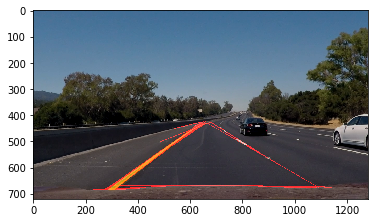

In [48]:
challenge_output = 'mychallenge.mp4'
clip2 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

In [49]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))